In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
# sys.path.insert(0, '/nas/xd/projects/transformers/notebooks/lxy/')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader
from LLAMATokenizer import LLAMATokenizer
# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In utils/hub.py: default_cache_path: /raid3/xd/.cache/torch/hub->/nas/xd/.cache/torch/transformers/


In [3]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [3]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _cxt2str, _item2str, _s, _be
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils'): from model_utils import *
# from model_utils_lxy import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000027
utils ... done 0:00:00.002818
child_utils ... Loading tokenizer ... done 0:00:04.700431
done 0:00:07.098449
tasks ... done 0:00:00.002571
model_utils ... done 0:00:05.413490
weight_analysis ... done 0:00:00.000025


In [4]:
torch.set_grad_enabled(False);

In [5]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [6]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', #'EleutherAI/gpt-j-6B',
                   #'EleutherAI/gpt-neox-20b/cpu', 'EleutherAI/gpt-neox-20b'
                  ]#, 'gpt2-xl', 'gpt2']
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:2]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 8
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 8; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer

EleutherAI/gpt-j-6B/cpu ... done 0:01:40.316621


In [7]:
import openai
from log import logger
import timeout_decorator
def get_openai_model(engine):
    stack = []
    with open("/nas/xd/projects/openai_keys_lxy.txt", "r") as f:
        for line in f.readlines():
            stack.append(line.strip().split()[0])
    @timeout_decorator.timeout(30)
    def forward(input_ids, retry_count = 0):#, attention_mask=None):
        text = tokenizer.decode(input_ids[0])
        tmp = '\n'.join(text.split('\n')[:2])
        if retry_count >= 6:
            logger.error("prompt = {}, 生成失败,出现retry_count >= 6 的问题, 需要手动查看异常".format(tmp))
            return "Generate False"
        if not stack:
            logger.error("prompt = {}, 生成失败, key已经用完，需重新申请账号".format(tmp))
            return "Generate False"
        proxy_key = "brd-customer-hl_c1b0ccff-zone-openai2-ip-178.171.126.110:sf23ma3ozhu3@zproxy.lum-superproxy.io:22225"
        openai.proxy = {"http": 'http://'+proxy_key, "https": 'https://' + proxy_key}
        openai.api_key = stack[0]
        try:
            response = openai.Completion.create(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5)
#             print('aaa')
            time.sleep(1)
            logger.info("prompt = {}, 生成成功。".format(tmp))
        except openai.error.OpenAIError as e:
            message = e.user_message
            logger.warning(message)
            if 'Incorrect API key provided' in message or 'deactivated' in message or 'You exceeded your current quota' in message:
                stack.remove(openai.api_key)
            time.sleep(2)
            return forward(input_ids, retry_count + 1)
        except timeout_decorator.timeout_decorator.TimeoutError as e:
            logger.warning(e)
            return forward(input_ids, retry_count + 1)
        return Outputs(logits=response.choices[0].logprobs)
    return forward
tokenizer0 = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
engines = ['text-curie-001', 'davinci', 'text-davinci-001', 'text-davinci-002', 'text-davinci-003', 'code-davinci-002'] #+ \
#     ['curie', 'curie:2020-05-03', 'curie-instruct-beta', 'text-curie-001'] + \
#     ['davinci', 'davinci:2020-05-03', 'davinci-instruct-beta', 'davinci-instruct-beta:2.0.0', 'text-davinci-001', 'text-davinci-002']
for engine in engines:
    models[engine] = get_openai_model(engine), tokenizer0

In [11]:
text = '''The apple: The apple is john's.
The chips: The chips are john's.
The coffee: The coffee is john's.
The shoes: The shoes are john's.
The blueberries: The blueberries are john's.
The tea: The tea is john's
'''
input_ids = tokenizer.encode(text, return_tensors = 'pt')
forward = get_openai_model('text-davinci-002')
t1 = time.time()
aa = forward(input_ids)
t2 = time.time()
print(t2 - t1)

In [7]:
model_name = gpt_model_names[0]  # engines[-1]
model, tokenizer = models[model_name]
model_name_gpu = model_name.replace('/cpu', '')
model_gpu = models[model_name_gpu][0] if model_name_gpu in models else model

In [8]:
blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim
# we = model.transformer.wte.weight.data
# wu = model.lm_head.weight.data

# es = [we]
# for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
# model.es = es
# weBTAs = [es[i].T @ es[i] for i in range(2)]
# model.weBTAs = weBTAs

In [10]:
# device = torch.device('cpu')
assert model.device == torch.device('cpu'), 'Clone PARTS OF CPU model to GPU device for ATTRIBUTION'
device = torch.device('cuda:0')
_ = clone_model_to(model, device)

cloning GPTJBlock0.ln_1 to cuda:0 ... done 0:00:02.949044
cloning GPTJAttention.out_proj to cuda:0 ... done 0:00:00.048910
cloning GPTJBlock1.ln_1 to cuda:0 ... done 0:00:00.001243
cloning GPTJAttention.out_proj to cuda:0 ... done 0:00:00.040029
cloning GPTJBlock2.ln_1 to cuda:0 ... done 0:00:00.001043
cloning GPTJAttention.out_proj to cuda:0 ... done 0:00:00.056578
cloning GPTJBlock3.ln_1 to cuda:0 ... done 0:00:00.001307
cloning GPTJAttention.out_proj to cuda:0 ... done 0:00:00.033960
cloning GPTJBlock4.ln_1 to cuda:0 ... done 0:00:00.000912
cloning GPTJAttention.out_proj to cuda:0 ... done 0:00:00.034669
cloning GPTJBlock5.ln_1 to cuda:0 ... done 0:00:00.001043
cloning GPTJAttention.out_proj to cuda:0 ... done 0:00:00.050805
cloning GPTJBlock6.ln_1 to cuda:0 ... done 0:00:00.001060
cloning GPTJAttention.out_proj to cuda:0 ... done 0:00:00.033683
cloning GPTJBlock7.ln_1 to cuda:0 ... done 0:00:00.001150
cloning GPTJAttention.out_proj to cuda:0 ... done 0:00:00.032632
cloning GPTJBloc

In [225]:
intermediary_heads = [(8, 1), (12, 10), (13, 13)]
circuit_ends = {
    'thing->type': ([(15, 8), (21, 5)], [(5, 12), (7, 2)]),
    'thing->capability': ([(13, 15)], [(6, 5), (3, 7), (5, 12)]),
    'capital->country': ([(19, 12)], [(5, 12)]), # inverse 3-7 by nrk 
    'opposite': ([(16, 14)], [(7, 9)]),
    'fr->en': ([(16, 15), (21, 14)], [(5, 12)]),
    'copy': ([(16, 7)], [(8, 7), (6, 2)]), # (1, 7), (3, 12), (6, 10)
    # did->does 6-2
}

In [223]:
predicting_heads, relating_heads = defaultdict(list), defaultdict(list)
for taskname, (pred_heads, rel_heads) in circuit_ends.items():
    for pred_head in pred_heads: predicting_heads[pred_head].append(taskname)
    for rel_head in rel_heads: relating_heads[rel_head].append(taskname)

In [399]:
for block in blocks: remove_composed_heads(block.attn)
# blocks[4].attn.composed_heads = [((4, 8), (4, 6))]; blocks[4].attn.ranges_i = ['ans]->*']  # opposite
blocks[6].attn.composed_heads = [('ans]->ans0]', (6, 2))]; blocks[6].attn.ranges_i = ['ans]->*']  # opposite
blocks[1].attn.composed_heads = [('ans]->ans0]', (1, 7))]; blocks[1].attn.ranges_i = ['ans]->*']  # opposite
blocks[8].attn.composed_heads = [('ans]->ans0]', (8, 7))]; blocks[8].attn.ranges_i = ['ans]->*']  # opposite
# blocks[6].attn.composed_heads = [((4, 8), (6, 10))]; blocks[6].attn.ranges_i = ['ans]->*']  # opposite
# blocks[8].attn.composed_heads = [((7, 2), (8, 7))]
# blocks[6].attn.composed_heads = [((7, 2), (6, 2))]
# blocks[4].attn.composed_heads = [((3, 12), (4, 8))]
# blocks[3].attn.composed_heads = [((3, 12), (3, 6))]
blocks[11].attn.composed_heads = [('bos->query]', (11, 12))]; blocks[11].attn.ranges_i = ['bos->*']
for block in blocks:
    if getattr(block.attn, 'composed_heads', None) is not None:
        compose_heads(model, block.attn, block.attn.composed_heads)

In [ ]:
relating_heads = [(6, 2), (8, 7), (7, 2), (5, 12)]#(7, 9)]
intermediary_heads = [(8, 1), (12, 10), (13, 13)]
predicting_heads = [(13, 7), (16, 7), (15, 8), (21, 5)]#, (16, 14)]
for circuit in product(relating_heads, intermediary_heads, predicting_heads):
    eigv_pos = plot_eigv(weightprod(model, list(circuit), 'e vo vo qk e', weBTA=model.weBTAs[0]), plot=False)[0]
    print(circuit, eigv_pos)

In [ ]:
def result2dict(result): return {k: v for k, v in result.__dict__.items() if k not in ['task', 'data_tuples']}  # 
with gzip.open(f'results/results-genders_of_persons-types_of_things.pkl.gz', 'wb') as f:
    pickle.dump({k: result2dict(r) for k, r in results.items()}, f)
# with gzip.open(f'results.pkl.gz', 'rb') as f: results = pickle.load(f)

In [346]:
res_key = keys[0]; res_key
fpath = f'results/{res_key}_attn_attrs.npz'
np.savez_compressed(fpath, *dump_attn_attrs_to_arrays(root, result.data_tuples))

'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]'

In [344]:
_root = deepcopy(root)
def fn(node): node.data = asdict(node.data)
traverse_tree(_root, fn, include_dummy=True)
pickle.dump(_root, gzip.open(f'results/{res_key}_tree.pkl.gz', 'wb'))

In [41]:
def _b(noun): # by lxy
    prompt_fn = lambda s: \
f'''The apple: The apple is john's.
The chips: The chips are john's.
The coffee: The coffee is john's.
The shoes: The shoes are john's.
The blueberries: The blueberries are john's.
The tea: The tea is john's.
{s}: {s}'''
    def extract_fn(text):
        text = text.strip()
        if text.endswith('.'): text = text[:-1]
        if text.split(' ')[0] not in ('is', 'are'): return 'is'
        return text.split(' ')[0]
    return noun + ' ' + extract_fn(query_openai(prompt_fn(noun), 'text-davinci-003')) # by lxy

In [9]:
tasks = [
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(genders_of_persons).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
    ), 
    (lambda: [TreeSet(types_of_things).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
    ), 
    (lambda: [TreeSet(countries_of_cities).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
    ),
    (lambda: fork_vocab(TreeSet(capabilities_of_things), [['equal', 'child', 'sibling']] * 2), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(SymSet(person_adjs), [['equal'], ['opposite']]), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['prev']]), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['next']]), MlM_gen, None, None,
    ), 
#     (lambda: [TreeSet(types_of_characters).use('child'), TreeSet(types_of_things).use('child')], partial(MlM_gen, cxt_sample_fn=enumerate_sample, query=1),
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {i[1]}", f"{the_(i[1])} is {i[0]}'s"]), lambda q, _: f"{q}", " likes"
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}", f"{_be(the_(i[1]))} {i[0]}'s"]), lambda q, _: f"{the_(q)} likes",
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}", f"{_be(the_(i[1]))} {i[0]}'s"]), lambda q, _: f"What {the_(q)} has is a kind of",
    ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}", f"{i[1]} attracts {the_(i[0], uppercase=False)}"]), lambda q, _: f'{the_(q)} wanna go to',
    ), # t: 19-12 >> 16-10 = 12-7
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(capabilities_of_things).use(['child'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}", f"{_be(the_(i[1]))} {i[0]}'s"]), lambda q, _: f'{the_(q)} has'
    ),
#     (lambda: [TreeSet(genders_of_persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{i[1].capitalize()} is {i[0]}"]), lambda q, _: f"Yes, {q} looks", " like"
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), SymSet(person_adjs).use(['opposite'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{capitalize(i[1])} {i[0]}"]), lambda q, _: f"{the_(q)} is",
    ), # t: 16-14, somewhat 14-7 # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [TreeSet(genders_of_persons).use('equal'), PoSet(temporal_posets).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {wrap_noun2(i[1])}', f'{wrap_noun2(i[1]).capitalize()} arrived {i[0]}']), lambda q, _: f"So {q}'s arrival time", ' is'
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['prev'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}', f'{capitalize(prep_(i[1]))} arrived {i[0]}']), lambda q, _: f'{the_(q)} arrived'
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['next'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}', f'{capitalize(prep_(i[1]))} arrived {i[0]}']), lambda q, _: f'{the_(q)} arrived'
    ),
]

In [286]:
nodes = {}
def fn(node): nodes[node2key(node)] = node
traverse_tree(r.root, fn)
print(nodes.keys())

dict_keys(['', '41-m', '39-m', '9-m', '15-m', '10-m', '28-m', '35-62', '35-62 > 30-34 attn/ans0s', '35-62 > 9-0 attn/ans0s', '35-62 > 27-24 attn/ans0s', '35-62 > 19-21 attn/ans0s', '35-62 > 33-63 attn/ans0s', '35-62 > 24-47 attn/ans0s', '35-62 > 25-43 attn/ans0s', '35-62 > 28-2 attn/ans0s', '35-62 > 21-49 attn/ans0s', '35-62 > 25-37 attn/ans0s', '35-62 > 22-40 attn/ans0s', '35-62 > 23-52 attn/ans0s', '35-62 > 26-m', '35-62 > 30-m', '35-62 > 26-45', '35-62 > 29-54', '35-62 > 20-33 attn', '35-62 > 15-38 attn', '35-62 > 13-31 attn', '35-62 > 9-42 attn', '0-m', '29-39 attn/ans0s', '25-43 attn/ans0s', '39-35 attn/ans0s', '30-34 attn/ans0s', '30-34 attn/ans0s > 20-m', '30-34 attn/ans0s > 23-m', '30-34 attn/ans0s > 24-m', '30-34 attn/ans0s > 18-m', '30-34 attn/ans0s > 21-60', '30-34 attn/ans0s > 0-m', '30-34 attn/ans0s > 16-m', '30-34 attn/ans0s > 19-29', '30-34 attn/ans0s > 19-m', '30-34 attn/ans0s > 27-m', '30-34 attn/ans0s > 18-23', '30-34 attn/ans0s > 15-38', '30-34 attn/ans0s > 15-0', '3

In [287]:
node = r.root#.children[10].children[8]
node = nodes['22-40 attn/ans0s']
node.name

'@18 22-40 31 B->A0 97/62/-6.6 attn/ans0s'

In [ ]:
# layer=[29, 30, 21], head=[39, 34, 49], 
plot_attn_attrs(r.data_tuples[-3:], model, tokenizer, node, topi=[0], attn_patterns=['B->T'], k_shot=k_shot+3+1, mix=False)

In [ ]:
show_predictions_by_data_tuples(model, tokenizer, r.data_tuples[-3:], k_shot)

In [13]:
results = {}
key = None

In [13]:
key = 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]' # 18-5  11-4,13-11 B->A0+ 10-11?
# key = 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]'
# key = 'MlM_gen[cxt_sample_fn=enumerate_sample,query=1][types_of_characters.TreeSet.equal,types_of_characters.TreeSet.equal][cxt_len=3,abstract]'

In [111]:
for name, param in model.transformer.h[30].attn.named_children(): print(name)

rotary_emb
query_key_value
dense
attn_dropout
resid_dropout
q_proj
k_proj
v_proj
out_proj_cuda7


In [299]:
for dt in r.data_tuples: dt[-1].attn_attr.clear()

In [31]:
from argparse import Namespace
from SwissArmyTransformer import get_tokenizer
args = Namespace(tokenizer_type='icetk-glm-130B')
tokenizer = get_tokenizer(args)
llamatokenizer = LLAMATokenizer(model_path="/nas2/xd/data/models/llama_model/tokenizer.model")

In [ ]:
results = {}
key = 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]'

In [12]:
with open('/nas/xd/projects/transformers/notebooks/lxy/task_accuary_gptj.pickle', 'rb') as file:   #用with的优点是可以不用写关闭文件操作
    dict_gptj = pickle.load(file)
    
with open('~/.cachier/.openai_utils.query_openai', 'rb') as file:  
    dict_gptj = pickle.load(file)

In [13]:
desp = sorted(dict_gptj.items(), key = lambda x: x[1]['mean_acc'], reverse = True)

In [14]:
desp_filter = [(key, value) for key, value in desp if value['mean_acc'] >=0.6]

In [15]:
desp_filter

[('MlM_gen[types_of_things.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3]',
  {'texts': ('There are red, a wolf, red. Which is not red? The wolf\nThere are a pineapple, blue, blue. Which is not blue? The pineapple\nThere are pink, grapes, pink. Which is not pink? The grapes\nThere are a donkey, a donkey, jeans. Which is not donkey? The jeans\nThere are a cat, a cat, a mango. Which is not cat? The mango\nThere are a handgun, a papaya, a papaya. Which is not papaya? The handgun\nThere are a mouse, juice, a mouse. Which is not mouse? The juice\nThere are jeans, a durian, jeans. Which is not jeans? The durian\nThere are a bee, a bee, a motorcycle. Which is not bee? The motorcycle\nThere are a shotgun, a mouse, a mouse. Which is not mouse? The shotgun\nThere are a taxi, shoes, a taxi. Which is not taxi? The shoes\nThere are pants, pants, tea. Which is not pants? The tea\n',),
   'mean_loss': 0.09096916834823787,
   'mean_acc': 0.9861111111111112,
   'answer_probs': array([0.168

In [18]:
keys = [key for key, value in desp_filter]

In [19]:
keys

['MlM_gen[types_of_things.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3]',
 'MlM_gen[genders_of_persons.TreeSet.neg_equal,genders_of_persons.TreeSet.equal][cxt_len=3]',
 'MlM_gen[types_of_things.TreeSet.child,types_of_things.TreeSet.equal][cxt_len=3]',
 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]',
 'MlM_gen[genders_of_persons.TreeSet.child,genders_of_persons.TreeSet.equal][cxt_len=3]',
 'rm_query[MlM_gen][genders_of_persons.TreeSet.neg_equal,genders_of_persons.TreeSet.equal][cxt_len=3]',
 'g2c[MlM_gen][types_of_things.TreeSet.neg_sibling,genders_of_persons.TreeSet.sibling][cxt_len=3,rev_item2str]',
 'rm_query[MlM_gen][types_of_things.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3]',
 'g2c[MlM_gen][types_of_things.TreeSet.sibling,genders_of_persons.TreeSet.sibling][cxt_len=3]',
 'g2c[MlM_gen][types_of_things.TreeSet.equal,genders_of_persons.TreeSet.sibling][cxt_len=3,rev_item2str]',
 'g2c[MlM_gen][types_of_things.TreeSet.

In [57]:
results = {}
key = None
# key = 'MlM_gen[genders_of_persons.TreeSet.neg_equal,genders_of_persons.TreeSet.equal][cxt_len=3]'

In [14]:
results

{'MlM_gen[genders_of_persons.TreeSet.neg_equal,genders_of_persons.TreeSet.equal][cxt_len=3]': {'texts': ('\nThere are Barbara, Barbara, George. Who is not Barbara? George\nThere are Ruth, Ruth, Brian. Who is not Ruth? Brian\nThere are Margaret, Kevin, Kevin. Who is not Kevin? Margaret\nThere are James, James, Deborah. Who is not James? Deborah\nThere are Robert, Sharon, Sharon. Who is not Sharon? Robert\nThere are Sharon, Christopher, Christopher. Who is not Christopher? Sharon\nThere are Barbara, Jason, Barbara. Who is not Barbara? Jason\nThere are Anthony, Deborah, Deborah. Who is not Deborah? Anthony\nThere are Robert, Susan, Robert. Who is not Robert? Susan\nThere are Robert, Robert, Sarah. Who is not Robert? Sarah\nThere are Karen, William, William. Who is not William? Karen\nThere are William, Mary, Mary. Who is not Mary? William\nThere are Helen, Helen, Edward. Who is not Helen? Edward\nThere are John, Deborah, John. Who is not John? Deborah\nThere are Karen, Jeff, Jeff. Who is 

In [138]:
results = {}; key = None
# cxt_len = 3;
nrows, k_shot = 16, 3;  save_results = True
batch_size = 2; verbose = True #not save_results or batch_size <= 8
rel1_kwargs = {'x_f': None}  # {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}
for task, rel0_i, rel1_i, do_swap_qa, do_negate, do_rm_query, rev_item2str, do_g2c, cxt_len, abstract in product(
#     tasks[:1],range(1),range(1),[False,],[True],[False,],[False,],[False,], [3], [False,]):
    tasks,range(3),range(3),[False,True],[False,True],[False,True],[False,True],[False,True], [3], [False,]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=abstract)
    trans_args = dict(rel0_i=rel0_i, rel1_i=rel1_i, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_query=do_rm_query, do_g2c=do_g2c)
    task = transform_task(task, **trans_args)
    if task is None: continue
    res_key = f'{task2str(task)}[{args2str(args)}]'# + composed_heads2str(model)
    if key is not None and res_key != key: continue
    if not validate_args(task, args, trans_args): print(f'invalid args {res_key}! skip.'); continue
    print(f'\n== {res_key} == {args2str(trans_args)}')
    r = results[res_key] if save_results and res_key in results else None
    if r is not None: print('duplicate task!'); continue 
#     args['save_label'] = True
    r = generate_and_predict_batch(model if save_results else model_gpu, tokenizer, task, nrows, k_shot, batch_size,
            custom_forward=save_results, result=r, verbose=verbose,save_label = True ,**args)
    if save_results: results[res_key] = r
#     if True or not save_results or getattr(r, 'mean_acc', 0) < 0.45: continue

#     if True or r.root is None: r.root = add_node(None, layer=L, label_type='labels')
#     r.root = attribute_tree_on(r.data_tuples, model, r.root, -1, topk=20, k_shot=k_shot, mix=True, device=device, verbose=True)


transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] ()

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_g2c)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] ()

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_g2c)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_rm_query)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_rm_query,do_g2c)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_rm_query)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_rm_query,do_g2c)

== MlM_gen[genders_of_persons.TreeSet.neg_equal,genders_of_persons.TreeSet.equal][cxt_len=3] == do_negate
There are Barbara, Barbara, George. Who is not Barbara? George
There are Ruth, Ruth, Brian. Who is not Ruth? Brian
There are Margaret, Kevin, Kevin. Who is not Kevin? Margaret
There are James, James, Deborah. Who is

data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
There are Karen, William, William. Who is different? The one like Richar


== g2c[rm_query[MlM_gen]][genders_of_persons.TreeSet.neg_child,genders_of_persons.TreeSet.child][cxt_len=3] == rel0_i=1,rel1_i=1,do_negate,do_rm_query,do_g2c
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_persons', 'genders_of_persons']
data_names = ['genders_of_per


transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] ()

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_g2c)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] ()

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_g2c)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_rm_query)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_rm_query,do_g2c)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_rm_query)

transform_task failed: invalid rel for rm_local_hop: ['equal', 'equal'] (do_rm_query,do_g2c)

== MlM_gen[types_of_things.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3] == do_negate
There are a taxi, a taxi, an elephant. Which is not taxi? The elephant
There are a jacket, a jacket, yellow. Which is not jacket? The yellow
There are T-shirt, a lemon, a lemon. Which is not lemon? The T-shirt
There are a


== g2c[rm_query[MlM_gen]][types_of_things.TreeSet.neg_equal,types_of_things.TreeSet.child][cxt_len=3] == rel1_i=1,do_negate,do_rm_query,do_g2c
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_

data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names =

data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names = ['types_of_things', 'types_of_things']
data_names =


transform_task failed: invalid rel for rm_local_hop with g2c: ['neg_equal', 'equal'] (do_negate,do_g2c)
invalid args MlM_gen[countries_of_cities.TreeSet.neg_equal,countries_of_cities.TreeSet.equal][cxt_len=3,rev_item2str]! skip.

transform_task failed: invalid rel for rm_local_hop with g2c: ['neg_equal', 'equal'] (do_negate,do_g2c)

== rm_query[MlM_gen][countries_of_cities.TreeSet.neg_equal,countries_of_cities.TreeSet.equal][cxt_len=3] == do_negate,do_rm_query
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cit


== MlM_gen[countries_of_cities.TreeSet.child,countries_of_cities.TreeSet.equal][cxt_len=3] == rel0_i=1
There are Lyon, Paris, Washington, D.C. Which is the city in the United States? Washington, D.C
There are London, Brisbane, Sao Paulo. Which is the city in the United Kingdom? London
There are Saint Petersburg, Valencia, Beijing. Which is the city in China? Beijing
There are Chiang Mai, Milan, New Delhi. Which is the city in India? New Delhi

transform_task failed: invalid rel for rm_local_hop with g2c: ['child', 'equal'] (rel0_i=1,do_g2c)
invalid args MlM_gen[countries_of_cities.TreeSet.child,countries_of_cities.TreeSet.equal][cxt_len=3,rev_item2str]! skip.

transform_task failed: invalid rel for rm_local_hop with g2c: ['child', 'equal'] (rel0_i=1,do_g2c)

transform_task failed: invalid rel for rm_query['child', 'equal'] (rel0_i=1,do_rm_query)

transform_task failed: invalid rel for rm_query['child', 'equal'] (rel0_i=1,do_rm_query,do_g2c)

transform_task failed: invalid rel for rm_q

data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
data_names = ['countries_of_cities', 'countries_of_cities']
There are Brasília, Rome, Venice. Which 

There are pencils, a knife, pencils. Which is not pencil? The knife
There are a calculator, a mop, a calculator. Which is not calculator? The mop
There are swim fins, swim fins, a helicopter. Which is not swim fins? The helicopter
There are a mop, a mop, a horse. Which is not mop? The horse


ValueError: '.' is not in list

In [140]:
with open('/nas/xd/projects/transformers/notebooks/lxy_train/task_datasets.pickle', 'wb') as f:
    pickle.dump(results, f)

In [139]:
len(results)

51

In [23]:
tokens = tokenizer.tokenize(r.texts[0])
r.texts[0]

'\nThere are Barbara, Barbara, George. Who is not Barbara? George\nThere are Ruth, Ruth, Brian. Who is not Ruth? Brian\nThere are Margaret, Kevin, Kevin. Who is not Kevin? Margaret\nThere are James, James, Deborah. Who is not James? Deborah\nThere are Robert, Sharon, Sharon. Who is not Sharon? Robert\nThere are Sharon, Christopher, Christopher. Who is not Christopher? Sharon\nThere are Barbara, Jason, Barbara. Who is not Barbara? Jason\nThere are Anthony, Deborah, Deborah. Who is not Deborah? Anthony\nThere are Robert, Susan, Robert. Who is not Robert? Susan\nThere are Robert, Robert, Sarah. Who is not Robert? Sarah\nThere are Karen, William, William. Who is not William? Karen\nThere are William, Mary, Mary. Who is not Mary? William\nThere are Helen, Helen, Edward. Who is not Helen? Edward\nThere are John, Deborah, John. Who is not John? Deborah\nThere are Karen, Jeff, Jeff. Who is not Jeff? Karen\nThere are Deborah, William, Deborah. Who is not Deborah? William\n'

In [20]:
r.data_tuples[0][3]


[Ranges(bos=(12, 13), ans=(13, 14), ans0=(6, 7), query=(11, 12), tgt=(6, 7), sep=(7, 8), ans0s=(array([6, 4, 2]), array([7, 5, 3])), example=(0, 14)),
 Ranges(bos=(27, 28), ans=(28, 29), ans0=(21, 22), query=(26, 27), tgt=(21, 22), sep=(22, 23), ans0s=(array([21, 19, 17]), array([22, 20, 18])), example=(15, 29)),
 Ranges(bos=(42, 43), ans=(43, 44), ans0=(32, 33), query=(41, 42), tgt=(32, 33), sep=(37, 38), ans0s=(array([36, 34, 32]), array([37, 35, 33])), example=(30, 44)),
 Ranges(bos=(57, 58), ans=(58, 59), ans0=(51, 52), query=(56, 57), tgt=(51, 52), sep=(52, 53), ans0s=(array([51, 49, 47]), array([52, 50, 48])), example=(45, 59)),
 Ranges(bos=(72, 73), ans=(73, 74), ans0=(62, 63), query=(71, 72), tgt=(62, 63), sep=(67, 68), ans0s=(array([66, 64, 62]), array([67, 65, 63])), example=(60, 74)),
 Ranges(bos=(87, 88), ans=(88, 89), ans0=(77, 78), query=(86, 87), tgt=(77, 78), sep=(82, 83), ans0s=(array([81, 79, 77]), array([82, 80, 78])), example=(75, 89)),
 Ranges(bos=(102, 103), ans=(

AttributeError: 'Result' object has no attribute 'textss'

In [24]:
tokens[27]

'ĠRuth'

In [30]:
torch.finfo(torch.float16).min

-65504.0

In [60]:
len(results)
results['MlM_gen[genders_of_persons.TreeSet.neg_equal,genders_of_persons.TreeSet.equal][cxt_len=3]']

51

{'texts': ('\nThere are Barbara, Barbara, George. Who is not Barbara? George\nThere are Ruth, Ruth, Brian. Who is not Ruth? Brian\nThere are Margaret, Kevin, Kevin. Who is not Kevin? Margaret\nThere are James, James, Deborah. Who is not James? Deborah\nThere are Robert, Sharon, Sharon. Who is not Sharon? Robert\nThere are Sharon, Christopher, Christopher. Who is not Christopher? Sharon\nThere are Barbara, Jason, Barbara. Who is not Barbara? Jason\nThere are Anthony, Deborah, Deborah. Who is not Deborah? Anthony\nThere are Robert, Susan, Robert. Who is not Robert? Susan\nThere are Robert, Robert, Sarah. Who is not Robert? Sarah\nThere are Karen, William, William. Who is not William? Karen\nThere are William, Mary, Mary. Who is not Mary? William\nThere are Helen, Helen, Edward. Who is not Helen? Edward\nThere are John, Deborah, John. Who is not John? Deborah\nThere are Karen, Jeff, Jeff. Who is not Jeff? Karen\nThere are Deborah, William, Deborah. Who is not Deborah? William\n',
  '\nThe

In [61]:
from lxy_train.task_dataset import TasksDataset


In [79]:
model.config.use_return_dict

True

In [67]:
for text_range_ids in zip(*results['MlM_gen[genders_of_persons.TreeSet.neg_equal,genders_of_persons.TreeSet.equal][cxt_len=3]'].values()):
    print(text_range_ids)

('\nThere are Barbara, Barbara, George. Who is not Barbara? George\nThere are Ruth, Ruth, Brian. Who is not Ruth? Brian\nThere are Margaret, Kevin, Kevin. Who is not Kevin? Margaret\nThere are James, James, Deborah. Who is not James? Deborah\nThere are Robert, Sharon, Sharon. Who is not Sharon? Robert\nThere are Sharon, Christopher, Christopher. Who is not Christopher? Sharon\nThere are Barbara, Jason, Barbara. Who is not Barbara? Jason\nThere are Anthony, Deborah, Deborah. Who is not Deborah? Anthony\nThere are Robert, Susan, Robert. Who is not Robert? Susan\nThere are Robert, Robert, Sarah. Who is not Robert? Sarah\nThere are Karen, William, William. Who is not William? Karen\nThere are William, Mary, Mary. Who is not Mary? William\nThere are Helen, Helen, Edward. Who is not Helen? Edward\nThere are John, Deborah, John. Who is not John? Deborah\nThere are Karen, Jeff, Jeff. Who is not Jeff? Karen\nThere are Deborah, William, Deborah. Who is not Deborah? William\n', [Ranges(bos=(12, 1

In [147]:
dataset = TasksDataset('/nas/xd/projects/transformers/notebooks/lxy_train/task_datasets.pickle',
            tokenizer)

In [149]:
dataset[0]

{'texts': '\nThere are Barbara, Barbara, George. Who is not Barbara? George\nThere are Ruth, Ruth, Brian. Who is not Ruth? Brian\nThere are Margaret, Kevin, Kevin. Who is not Kevin? Margaret\nThere are James, James, Deborah. Who is not James? Deborah\nThere are Robert, Sharon, Sharon. Who is not Sharon? Robert\nThere are Sharon, Christopher, Christopher. Who is not Christopher? Sharon\nThere are Barbara, Jason, Barbara. Who is not Barbara? Jason\nThere are Anthony, Deborah, Deborah. Who is not Deborah? Anthony\nThere are Robert, Susan, Robert. Who is not Robert? Susan\nThere are Robert, Robert, Sarah. Who is not Robert? Sarah\nThere are Karen, William, William. Who is not William? Karen\nThere are William, Mary, Mary. Who is not Mary? William\nThere are Helen, Helen, Edward. Who is not Helen? Edward\nThere are John, Deborah, John. Who is not John? Deborah\nThere are Karen, Jeff, Jeff. Who is not Jeff? Karen\nThere are Deborah, William, Deborah. Who is not Deborah? William\n',
 'input_i

In [151]:
tokenizer.decode(19579)

' Margaret'

In [70]:
tokenizer.pad_token = tokenizer.eos_token
# model.resize_token_embeddings(len(tokenizer))
tokenizer.pad_token_id = tokenizer.eos_token_id

In [150]:
print(dataset[0]['labels'].tolist())

[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 19579, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 36976, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 5199, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 26918, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 8982, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 9953, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 14919, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 10490, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 18678, -10

In [28]:
print(results['MlM_gen[genders_of_persons.TreeSet.neg_equal,genders_of_persons.TreeSet.equal][cxt_len=3]'].texts[0])


There are Barbara, Barbara, George. Who is not Barbara? George
There are Ruth, Ruth, Brian. Who is not Ruth? Brian
There are Margaret, Kevin, Kevin. Who is not Kevin? Margaret
There are James, James, Deborah. Who is not James? Deborah
There are Robert, Sharon, Sharon. Who is not Sharon? Robert
There are Sharon, Christopher, Christopher. Who is not Christopher? Sharon
There are Barbara, Jason, Barbara. Who is not Barbara? Jason
There are Anthony, Deborah, Deborah. Who is not Deborah? Anthony
There are Robert, Susan, Robert. Who is not Robert? Susan
There are Robert, Robert, Sarah. Who is not Robert? Sarah
There are Karen, William, William. Who is not William? Karen
There are William, Mary, Mary. Who is not Mary? William




== g2c[MlM_gen][genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3] == do_g2c
David has a plum. Barbara has a papaya. Sharon has a fox. Barbara likes plum? False
Christopher has a mango. Karen has a pig. David has a cannon. Karen likes cannon? False
Edward has a guitar. Carol has a phone. Kevin has a violin. Kevin likes violin? True
0.7494258061051369 0.5347222222222222
attribute_tree ... In attribute_tree: attribute_step , topk=10 ... In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_tensor: y inf_pct = 1.0 
In check_abnormal_te

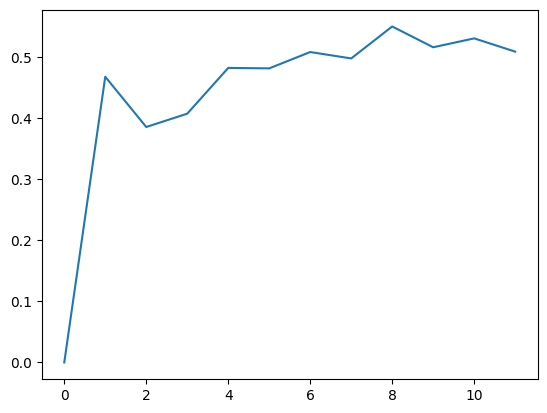

In [103]:
nrows, k_shot = 12, 3; cxt_len = 3; save_results = False
batch_size = 16; verbose = False #not save_results or batch_size <= 8
# rel0_kwargs_list = [{'skip_inv_f': True},{'skip_inv_f': False}][-1:]
# rel1_kwargs_list = [{'x_f': None, 'y_f': None, 'skip_inv_f': True}, {'x_f': _s, 'y_f': a_, 'skip_inv_f': True},
#                     {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}][-1:]
rel1_kwargs = {'x_f': None} 
for task, rel0_i, rel1_i, do_swap_qa, do_negate, do_rm_local_hop, do_rm_query, rev_item2str, do_g2c in product(
#     tasks[1:2],rel0_kwargs_list,rel1_kwargs_list,[False,], [False,],  [True,],        [False,],    [False,]):
#     tasks[1:2],range(3),range(3),[False, True],[False, True],[False, True],[False, True],[False, True],[False,True]):
    tasks[1:2],[0],[0],[ False],[False],[False, ],[False, ],[False, ],[True]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_i=rel0_i, rel1_i=rel1_i, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_local_hop=do_rm_local_hop, do_rm_query=do_rm_query, do_g2c=do_g2c)
    task = transform_task(task, **trans_args)
    if task is None: print('task is None! skip.'); continue
    res_key = f'{task2str(task)}[{args2str(args)}]'# + composed_heads2str(model)
#     if key is not None and res_key != key: continue
#     if res_key not in tmp_keys: continue
    if not validate_args(task, args, trans_args): print(f'invalid args {res_key}! skip.'); continue
#     if has_attribution_results(res_key): continue
    if res_key in results: continue # by lxy 判断重复
    print(f'\n== {res_key} == {args2str(trans_args)}')
#     count += 1
    r = None
#     args['max_length'] = 512
#     args['llama_size'] = '13B' #13B, 30B 65B      # layers 32 40 60 80
    r = generate_and_predict_batch(model_gpu, tokenizer, task, nrows, k_shot, batch_size,
                                trim=False, custom_forward = True, result=r, verbose=verbose, **args)
    if save_results: 
        results[res_key] = r
#         with open('/nas/xd/projects/transformers/notebooks/lxy/task_accuary_llama_7B_space_0329.pickle', 'wb') as f:
#             pickle.dump(results, f)

#     if True or not save_results or getattr(r, 'mean_acc', 0) < 0.45: continue

# #     load_attribution_results(r, res_key)
    if r.root is None: r.root = add_node(None, layer=L, label_type='labels')
    r.root = attribute_tree_on(r.data_tuples, model, r.root, 1, topk=10, k_shot=k_shot, mix=True, device=device, verbose=True)
#     r.root = attribute_tree_on(r.data_tuples, model, r.root, 1, topk=10, k_shot=k_shot, device=device, verbose=True)
#     with Timer('save_attribution_results'): save_attribution_results(r, res_key)
#     r.data_tuples = [dt[:-1] + [trim_outputs(dt[-1])] for dt in r.data_tuples] # to save mem. data_tuple is list!

In [122]:
predict = torch.tensor([[2,2, -100],[1,-100,-100]])
labels = torch.tensor([[1,2, -100],[1,-100,-100]])

In [123]:
mask = (labels != -100)

In [124]:
mask

tensor([[ True,  True, False],
        [ True, False, False]])

In [108]:
# 计算每一行需要计算的个数。
torch.einsum('bi->b', labels != -100)

tensor([2, 1])

In [117]:
True * True

1

In [129]:
pre = (predict == labels ) * mask

In [131]:
pre

tensor([[False,  True, False],
        [ True, False, False]])

In [135]:
torch.einsum('bi->b', (predict == labels ) * mask) / torch.einsum('bi->b', labels != -100)

tensor([0.5000, 1.0000])

In [103]:
predict[labels != -100]

IndexError: The shape of the mask [1, 2] at index 1 does not match the shape of the indexed tensor [1, 3] at index 1

In [91]:
final = (a==b).sum(dim = -1, keepdim = True)

In [93]:
final

tensor([[3],
        [3],
        [3]])

In [83]:
show_predictions_by_data_tuples(model, tokenizer, r.data_tuples, k_shot)

AttributeError: 'NoneType' object has no attribute 'data_tuples'

In [107]:
print(r.texts[0])

David has a plum. Barbara has a papaya. Sharon has a fox. Barbara likes plum? False
Christopher has a mango. Karen has a pig. David has a cannon. Karen likes cannon? False
Edward has a guitar. Carol has a phone. Kevin has a violin. Kevin likes violin? True
Anthony has a rabbit. Donald has a monkey. Deborah has a cocktail. Anthony likes monkey? False
Dorothy has juice. Laura has green. Daniel has a pineapple. Dorothy likes green? False
Christopher has a lemon. Richard has a watermelon. Jason has a cocktail. Christopher likes lemon? True
Ruth has a bee. Mark has a taxi. Donald has shoes. Donald likes shoes? True
Margaret has trousers. Elizabeth has tea. Jeff has green. Jeff likes tea? False
Mary has purple. Steven has a T-shirt. Ronald has a peach. Mary likes peach? False
Anthony has a laptop. Joseph has gray. Kenneth has an iPad. Anthony likes laptop? True
Deborah has a taxi. John has a mouse. Kenneth has a horse. Kenneth likes mouse? False
Joseph has a costume. Laura has trousers. Jeff

In [98]:
cxt, query, candidates, (tgt, *_, ans0, ans), *cls = r.all_examples[0][0]

In [102]:
ans0

'Brian'

In [72]:
tokens = tokenizer.tokenize(r.texts[0])
r.data_tuples[0][3]

[Ranges(bos=(14, 15), ans=(15, 16), ans0=(7, 8), query=(13, 14), tgt=(5, 6), sep=(8, 9), ans0s=(array([ 7, 11,  3]), array([ 8, 12,  4])), example=(0, 16)),
 Ranges(bos=(33, 34), ans=(34, 35), ans0=(30, 31), query=(32, 33), tgt=(27, 28), sep=(31, 32), ans0s=(array([25, 20, 30]), array([26, 21, 31])), example=(17, 35)),
 Ranges(bos=(53, 54), ans=(54, 55), ans0=(50, 51), query=(52, 53), tgt=(47, 48), sep=(51, 52), ans0s=(array([45, 50, 39]), array([46, 51, 41])), example=(36, 55)),
 Ranges(bos=(71, 72), ans=(72, 73), ans0=(68, 69), query=(70, 71), tgt=(66, 67), sep=(69, 70), ans0s=(array([64, 59, 68]), array([65, 60, 69])), example=(56, 73)),
 Ranges(bos=(89, 90), ans=(90, 91), ans0=(86, 87), query=(88, 89), tgt=(83, 84), sep=(87, 88), ans0s=(array([81, 76, 86]), array([82, 77, 87])), example=(74, 91)),
 Ranges(bos=(107, 108), ans=(108, 109), ans0=(99, 100), query=(106, 107), tgt=(97, 98), sep=(100, 101), ans0s=(array([ 99,  95, 104]), array([100,  96, 105])), example=(92, 109)),
 Ranges

In [68]:
#ans=(24, 25) 这里有bug
tokens = tokenizer.tokenize(r.texts[0])
r.data_tuples[0][3]

[Ranges(bos=(25, 26), ans=(24, 25), ans0=(3, 4), query=(22, 23), tgt=(1, 2), sep=(5, 6), ans0s=(array([ 9, 15,  3]), array([10, 16,  4])), example=(0, 27)),
 Ranges(bos=(54, 55), ans=(53, 54), ans0=(31, 32), query=(51, 52), tgt=(29, 30), sep=(33, 34), ans0s=(array([44, 38, 31]), array([45, 39, 32])), example=(28, 56)),
 Ranges(bos=(85, 86), ans=(84, 85), ans0=(74, 75), query=(81, 83), tgt=(58, 59), sep=(62, 63), ans0s=(array([74, 67, 60]), array([75, 68, 61])), example=(57, 87)),
 Ranges(bos=(113, 114), ans=(112, 113), ans0=(103, 104), query=(110, 111), tgt=(89, 90), sep=(93, 94), ans0s=(array([ 97, 103,  91]), array([ 98, 104,  92])), example=(88, 115)),
 Ranges(bos=(141, 142), ans=(140, 141), ans0=(131, 132), query=(138, 139), tgt=(129, 130), sep=(133, 134), ans0s=(array([125, 131, 119]), array([126, 132, 120])), example=(116, 143)),
 Ranges(bos=(169, 170), ans=(168, 169), ans0=(159, 160), query=(166, 167), tgt=(157, 158), sep=(161, 162), ans0s=(array([153, 159, 147]), array([154, 16

In [69]:
# Task: g2c[MlM_gen][types_of_things.TreeSet.neg_sibling,genders_of_persons.TreeSet.sibling][cxt_len=3,rev_item2str]
# The meat is Brian's. The revolver is Karen's. The grenade is Helen's. Who does not like gun? Paul? True
# The football is Carol's. T-shirt is Daniel's. The jeans are John's. Who does not like shirt? Deborah? True
# The wolf is Helen's. The watermelon is Joseph's. The cherries are Mark's. Who does not like blackberries? James? False
tokens[25]
L, H

'?'

(28, 16)

In [57]:
r.root.data.attr.head.size()

torch.Size([28, 16])

In [67]:
print(r.root.data.all_attn_patterns)

['bos->ans0', 'bos->ans]', 'bos->query', 'bos->ans0+', 'bos->tgt', 'bos->sep', 'bos->sep+', 'bos->query-', 'bos->bos']


In [60]:

print('Task:', key)
print('\n'.join(r.texts[0].split('\n')[:3]))
print(r.mean_loss, r.mean_acc)
print_tree(r.root)

Task: g2c[MlM_gen][types_of_things.TreeSet.neg_sibling,genders_of_persons.TreeSet.sibling][cxt_len=3,rev_item2str]
The meat is Brian's. The revolver is Karen's. The grenade is Helen's. Who does not like gun? Paul? True
The football is Carol's. T-shirt is Daniel's. The jeans are John's. Who does not like shirt? Deborah? True
The wolf is Helen's. The watermelon is Joseph's. The cherries are Mark's. Who does not like blackberries? James? False
0.6788255143910646 0.6736111111111112
 ┌@[0,1,3,4,5,6,8] 21-8,18-15,13-9,19-16,17-16,21-16 28,14-7 23 B->B 30
 ├@[2,7,9] 22-5,13-13 24,21-13 22 unk 0
 ├@0 21-8 100 B->B 0/0/-2714/-9.5
 ├@1 18-15 52 B->B 0/4/-180/-8.6
 ├@3 13-9 36 B->B 0/0/-1574/-9.4
 ├@4 19-16 34 B->B/100
 ├@5 17-16 30 B->B/100
 ├@66 11-4 1 B->S/9/33 attn/ans0s
 ├@66 11-4 1 B->S/9/33 attn:B->~<s>
 ┤
 ├@133 1-5 0 B->S/12/-18 attn/ans0s
 ├@133 1-5 0 B->S/12/-18 attn:B->~<s>
 ├@133 9-0 0 B->S/11/47 attn/ans0s
 ├@133 9-0 0 B->S/11/47 attn:B->~<s>
 ├@133 0-9 0 B->S/11/-92 attn/ans0s
 ├@1

In [40]:
# '''
# Task: MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]
# Ruth has bread. Paul has cake. Richard has pizza. Paul likes cake
# George has a violin. Mary has a rabbit. Ruth has a costume. Ruth likes costume
# Sandra has blueberries. Kenneth has a shotgun. Paul has a pear. Paul likes pear
# '''
print('Task:', key)
print('\n'.join(r.texts[0].split('\n')[:3]))
print(r.mean_loss, r.mean_acc)
print_tree(r.root)

Task: MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]
Ruth has bread. Paul has cake. Richard has pizza. Paul likes cake
George has a violin. Mary has a rabbit. Ruth has a costume. Ruth likes costume
Sandra has blueberries. Kenneth has a shotgun. Paul has a pear. Paul likes pear
0.6419002898037434 0.7777777777777778
 ┌@[0,1,2,4,5,6,8,9] 16-7,16-0,19-14,13-7,18-13,20-8,21-13 24,19-0 20 B->A0 71
 ├@[3,7] 24-10,18-9 25 B->B 12
 ├@0 16-7 100 B->A0 91/37/93/-3.2 attn/ans0s
 ├@0 16-7 100 B->A0 91/37/93/-3.2 attn:B->~<s>
 ├@1 16-0 82 B->A0 94/38/75/-3.0 attn/ans0s
 ├@1 16-0 82 B->A0 94/38/75/-3.0 attn:B->~<s>
 ├@2 19-14 50 B->A0 93/18/26/-4.1 attn/ans0s
 ├@4 13-7 46 B->A0 88/44/80/-3.2 attn/ans0s
 ├@4 13-7 46 B->A0 88/44/80/-3.2 attn:B->~<s>
 ├@5 18-13 45 B->A0 85/24/60/-3.4 attn/ans0s
 ├@5 18-13 45 B->A0 85/24/60/-3.4 attn:B->~<s>
 ├@6 20-8 41 B->A0 85/19/31/-4.0 attn/ans0s
 ├@16 14-6 14 B->A0/54/74 attn/ans0s
 ├@16 14-6 14 B->A0/54/74 attn:B->~<s>
 ├@51 25-

In [25]:
'''
Task: MlM_gen[types_of_things.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3]
There are Laura, Daniel, Laura. Who is not Laura? Daniel
There are Edward, Linda, Linda. Who is not Linda? Edward
There are Susan, Paul, Susan. Who is not Susan? Paul
'''
print('Task:', key)
print('\n'.join(r.texts[0].split('\n')[:3]))
print(r.mean_loss, r.mean_acc)
print_tree(r.root)

Task: MlM_gen[types_of_things.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3]
There are Laura, Daniel, Laura. Who is not Laura? Daniel
There are Edward, Linda, Linda. Who is not Linda? Edward
There are Susan, Paul, Susan. Who is not Susan? Paul
0.13715285260695964 0.9444444444444444
 ┌@[0,4,5,7,8,9] 19-6,16-0,19-0 29,14-6 23,18-5 22,17-1 21 B->A0 53
 ├@[2,3,6] 13-4,16-9,20-2 27 B->Q 16
 ├@[1] 24-10 B->B 9
 ├@0 19-6 100 B->A0 91/33/39/-2.3 attn/ans0s
 ├@4 16-0 33 B->A0 95/25/82/-2.7 attn/ans0s
 ├@4 16-0 33 B->A0 95/25/82/-2.7 attn:B->~<s>
 ├@13 15-7 15 B->A0/37/81 attn/ans0s
 ├@13 15-7 15 B->A0/37/81 attn:B->~<s>
 ├@14 16-12 14 B->A0/37/79 attn/ans0s
 ├@14 16-12 14 B->A0/37/79 attn:B->~<s>
 ├@473 21-15 -26 B->A0/37/82 attn/ans0s
 ├@473 21-15 -26 B->A0/37/82 attn:B->~<s>
 ├@475 20-0 -71 B->A0/55/90 attn/ans0s
 ├@475 20-0 -71 B->A0/55/90 attn:B->~<s>
 ├@2 13-4 56 B->Q 37/17/87/-2.7 attn/example
 ├@2 13-4 56 B->Q 37/17/87/-2.7 attn:B->~<s>
 ├@3 16-9 47 B->Q 67/26/94/-3.4 attn/e

[autoreload of child_utils failed: Traceback (most recent call last):
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", li

21-8
scaled_logprobs = tensor([-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09])
 ĠTrue 0.0 {'ĠPaul': 0.75, 'ĠMary': 0.25, '"': 0.0, '$': 0.0} 	 The meat is Brian's. The revolver is Karen's. The grenade is Helen's. Who does not like gun? Paul? True ĠPaul:0.836 ĠMary:-0.263 ĠMary:-0.263
 ĠTrue 0.0 {'ĠJames': 0.958, 'ĠDeborah': 0.042, '"': 0.0, '$': 0.0} 	 The football is Carol's. T-shirt is Daniel's. The jeans are John's. Who does not like shirt? Deborah? True ĠDeborah:-2.031 ĠJames:1.108 ĠJames:1.108
 ĠFalse 0.0 {'ĠJames': 0.544, 'ĠMichelle': 0.456, '"': 0.0, '$': 0.0} 	 The wolf is Helen's. The watermelon is Joseph's. The cherries are Mark's. Who does not like blackberries? James? False ĠMichelle:0.139 ĠJames:0.313 ĠJames:0.313
 ĠFalse 0.0 {'ĠJames': 0.766, 'ĠSandra': 0.234, '"': 0.0, '$': 0.0} 	 The iPad is Maria's. The taxi is Michael's. The motorcycle is Brian's. Who does not like car? James? False ĠSandra:-0.667 ĠJames:0.518 ĠJames:0.518
 ĠTrue 0.0 {'ĠJames': 0.692, 'ĠBarbara':

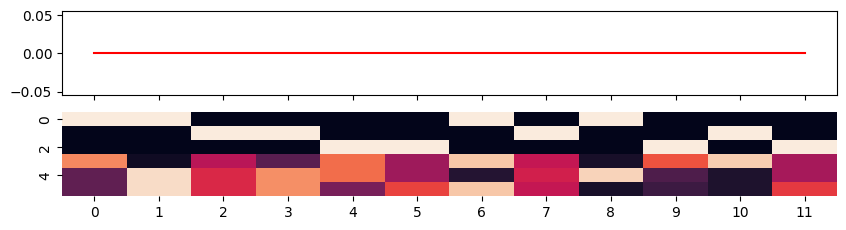

ap_scores = tensor([1.7654e-05, 8.2605e-06, 1.7519e-05, 1.7151e-05]) tensor(1.5146e-05)


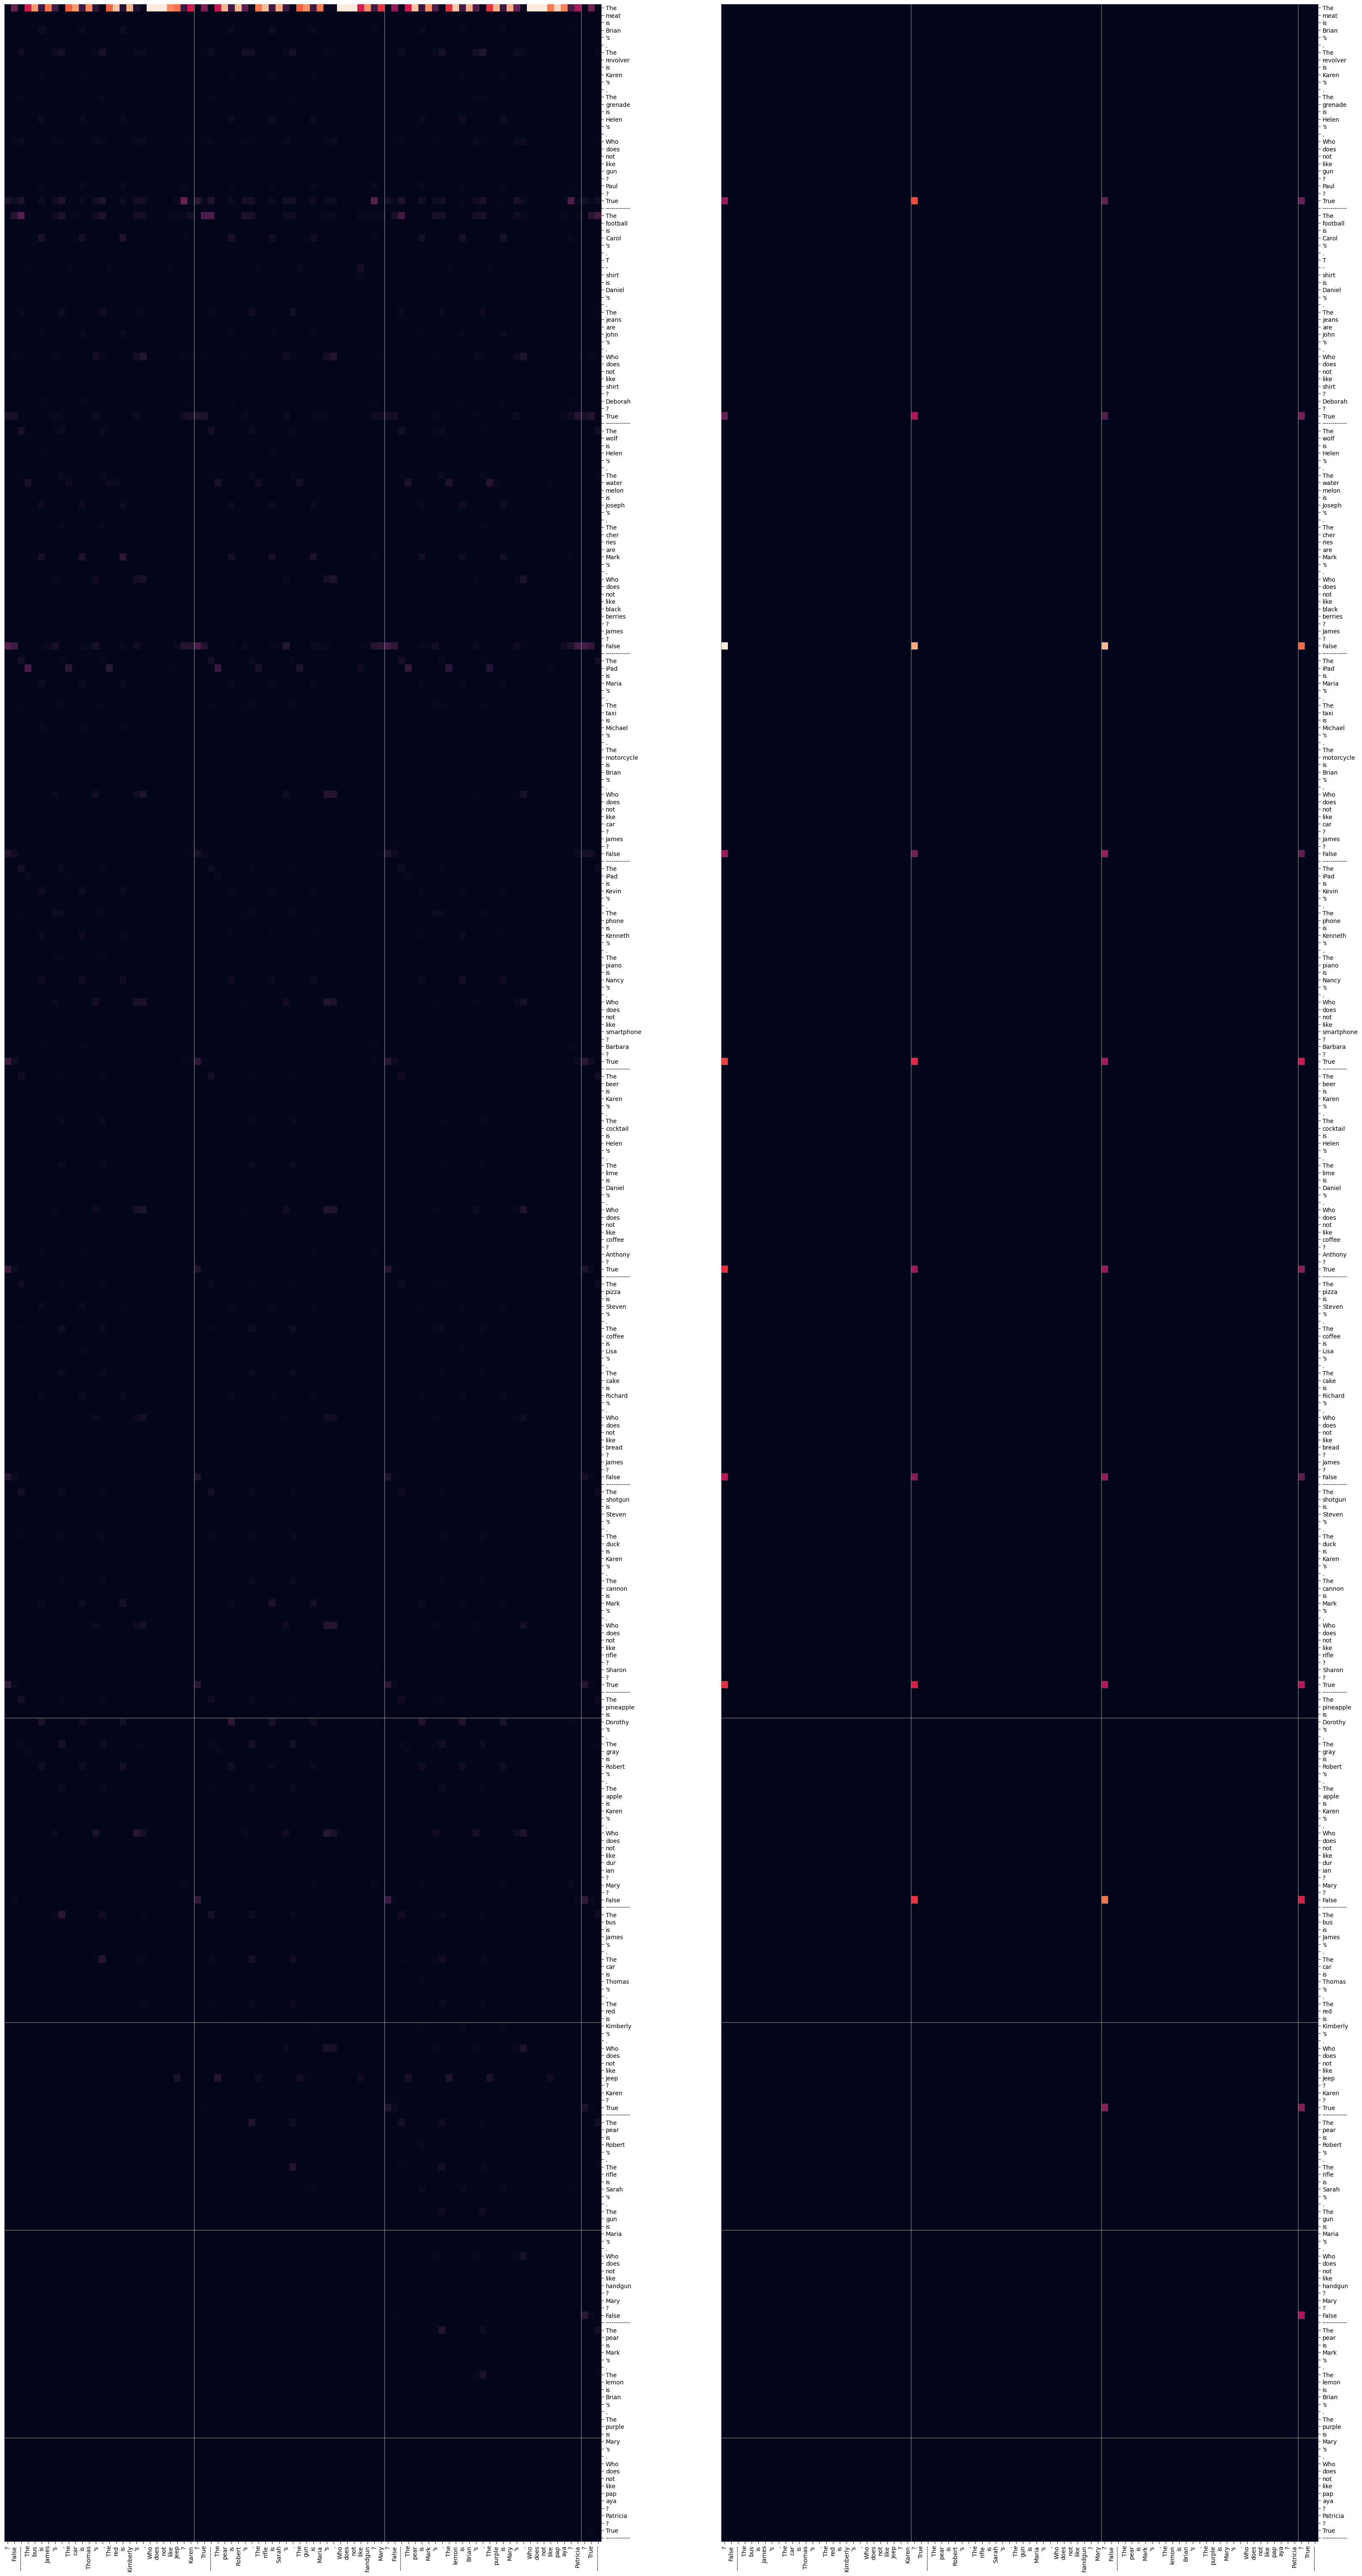

scaled_logprobs = tensor([-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09])
 ĠTrue 0.0 {'ĠRonald': 0.839, 'ĠMary': 0.161, '"': 0.0, '$': 0.0} 	 The steak is Deborah's. The gray is Joseph's. The hamburger is Sarah's. Who does not like meat? Ronald? True ĠMary:-0.523 ĠRonald:1.126 ĠMary:-0.523
 ĠFalse 0.0 {'ĠJason': 0.938, 'ĠJennifer': 0.049, 'ĠMary': 0.012, '"': 0.0} 	 The kiwi is Mary's. The banana is Elizabeth's. The phone is Kevin's. Who does not like plum? Mary? False ĠJennifer:-0.321 ĠMary:-1.692 ĠJason:2.627
 ĠTrue 0.0 {'ĠRonald': 0.947, 'ĠMary': 0.053, '"': 0.0, '$': 0.0} 	 The jersey is Linda's. The uniform is Kimberly's. The rabbit is Christopher's. Who does not like pants? Ronald? True ĠMary:-1.255 ĠMary:-1.255 ĠRonald:1.620
 ĠTrue 0.0 {'ĠJames': 0.778, 'ĠCarol': 0.222, '"': 0.0, '$': 0.0} 	 The jeans are Betty's. The taxi is Anthony's. The bus is Kevin's. Who does not like Jeep? Carol? True ĠCarol:-0.730 ĠJames:0.525 ĠJames:0.525
 ĠTrue 0.0 {'ĠDorothy': 0.828, 'ĠJames': 0.

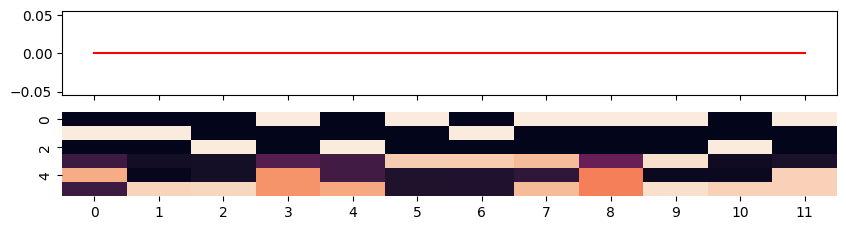

ap_scores = tensor([6.9526e-05, 1.9304e-05, 9.2781e-06, 1.4697e-05]) tensor(2.8201e-05)


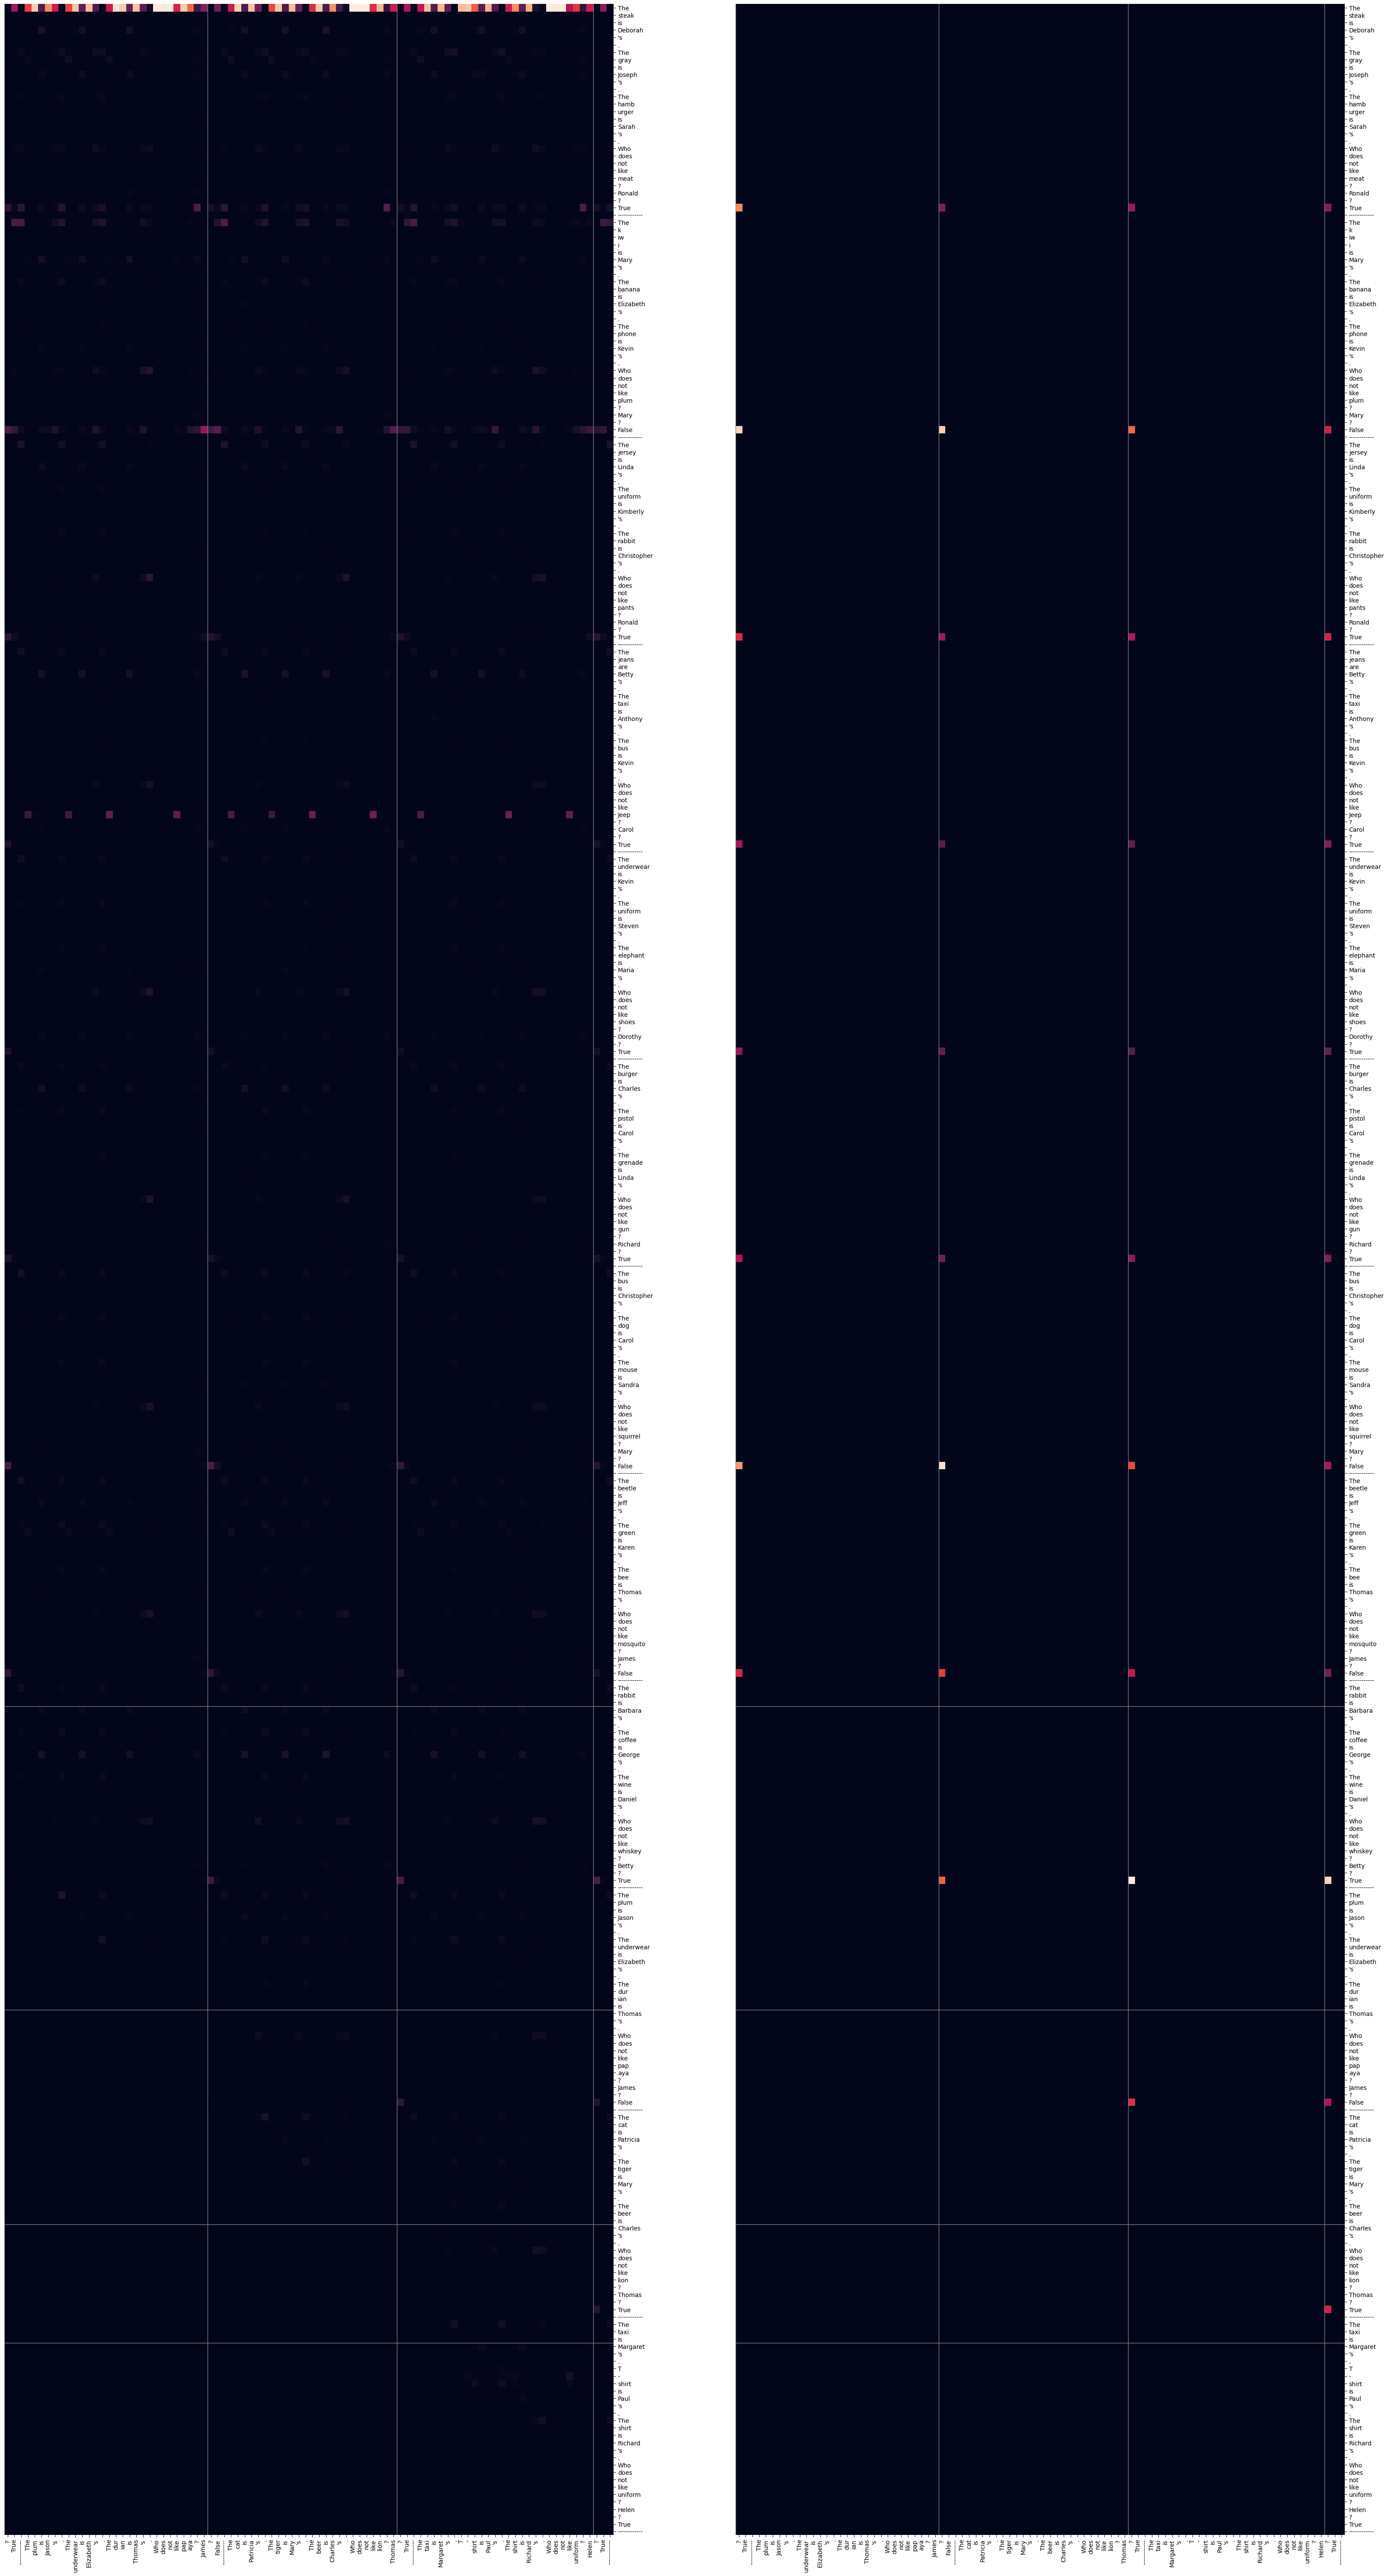

reduced_ap_scores = tensor([4.3590e-05, 1.3782e-05, 1.3399e-05, 1.5924e-05]) tensor(2.1674e-05)
18-15
scaled_logprobs = tensor([-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09])
 ĠTrue 0.0 {'ĠPaul': 0.89, 'ĠMary': 0.11, '"': 0.0, '$': 0.0} 	 The meat is Brian's. The revolver is Karen's. The grenade is Helen's. Who does not like gun? Paul? True ĠPaul:3.279 ĠMary:1.184 ĠMary:1.184
 ĠTrue 0.0 {'ĠDeborah': 0.896, 'ĠJames': 0.104, '"': 0.0, '$': 0.0} 	 The football is Carol's. T-shirt is Daniel's. The jeans are John's. Who does not like shirt? Deborah? True ĠDeborah:3.243 ĠJames:1.085 ĠJames:1.085
 ĠFalse 0.0 {'ĠMichelle': 0.956, 'ĠJames': 0.044, '"': 0.0, '$': 0.0} 	 The wolf is Helen's. The watermelon is Joseph's. The cherries are Mark's. Who does not like blackberries? James? False ĠMichelle:3.206 ĠJames:0.117 ĠJames:0.117
 ĠFalse 0.0 {'ĠJames': 0.503, 'ĠSandra': 0.497, '"': 0.0, '$': 0.0} 	 The iPad is Maria's. The taxi is Michael's. The motorcycle is Brian's. Who does not like car? 

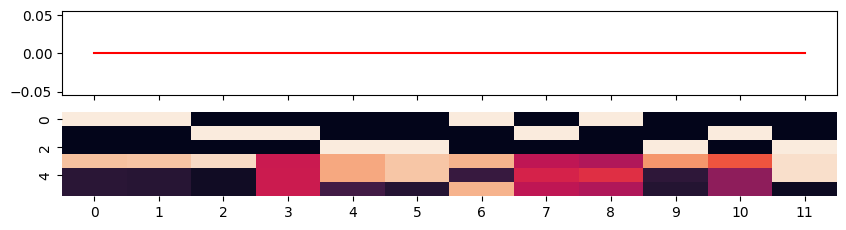

ap_scores = tensor([8.0218e-05, 2.2336e-05, 3.4340e-06, 1.2886e-05]) tensor(2.9719e-05)


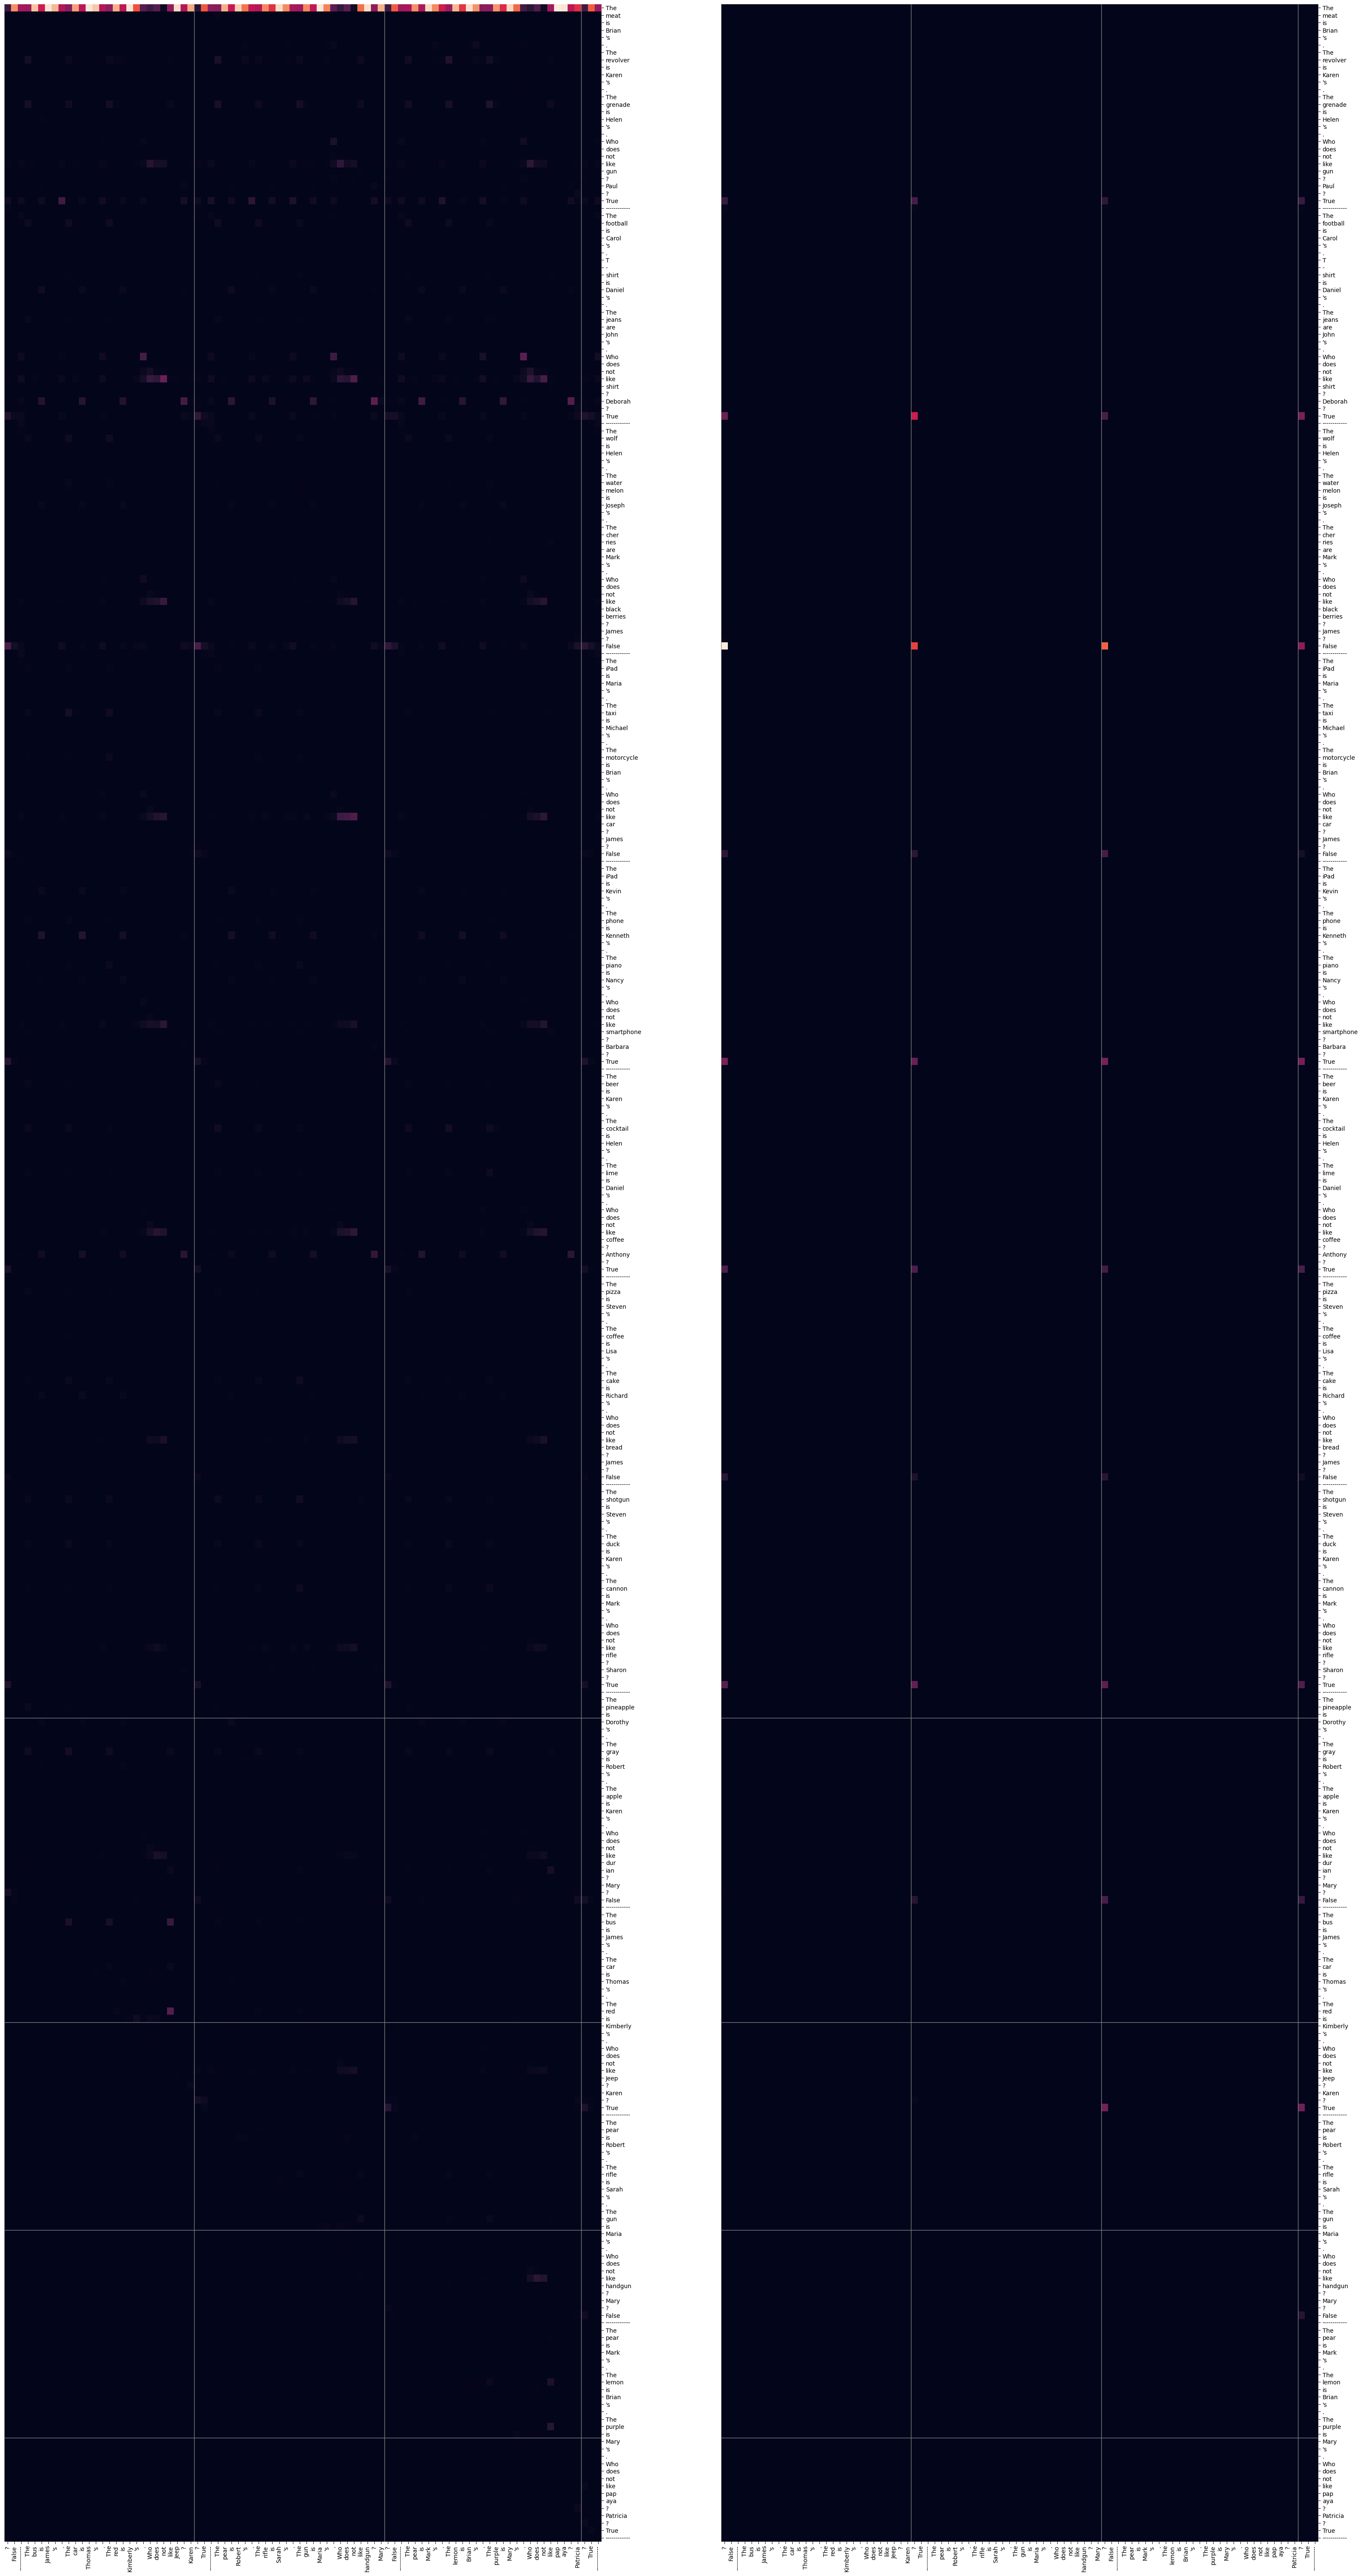

scaled_logprobs = tensor([-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09])
 ĠTrue 0.0 {'ĠMary': 0.881, 'ĠRonald': 0.119, '"': 0.0, '$': 0.0} 	 The steak is Deborah's. The gray is Joseph's. The hamburger is Sarah's. Who does not like meat? Ronald? True ĠMary:1.751 ĠRonald:-0.256 ĠMary:1.751
 ĠFalse 0.0 {'ĠMary': 0.464, 'ĠJason': 0.337, 'ĠJennifer': 0.199, '"': 0.0} 	 The kiwi is Mary's. The banana is Elizabeth's. The phone is Kevin's. Who does not like plum? Mary? False ĠJennifer:0.014 ĠMary:0.861 ĠJason:0.543
 ĠTrue 0.0 {'ĠMary': 0.939, 'ĠRonald': 0.061, '"': 0.0, '$': 0.0} 	 The jersey is Linda's. The uniform is Kimberly's. The rabbit is Christopher's. Who does not like pants? Ronald? True ĠMary:1.802 ĠMary:1.802 ĠRonald:-0.927
 ĠTrue 0.0 {'ĠJames': 0.758, 'ĠCarol': 0.242, '"': 0.0, '$': 0.0} 	 The jeans are Betty's. The taxi is Anthony's. The bus is Kevin's. Who does not like Jeep? Carol? True ĠCarol:-0.611 ĠJames:0.532 ĠJames:0.532
 ĠTrue 0.0 {'ĠDorothy': 0.759, 'ĠJames': 0.241,

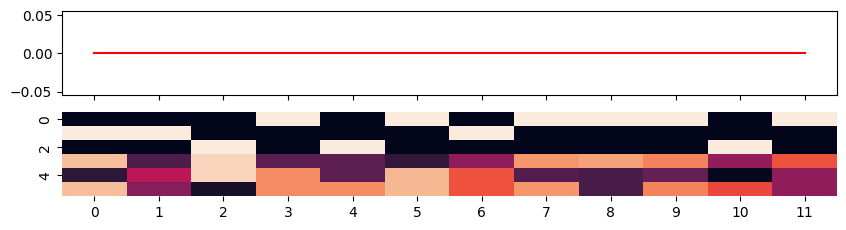

ap_scores = tensor([8.1929e-05, 3.2897e-05, 4.2866e-06, 1.5543e-05]) tensor(3.3664e-05)


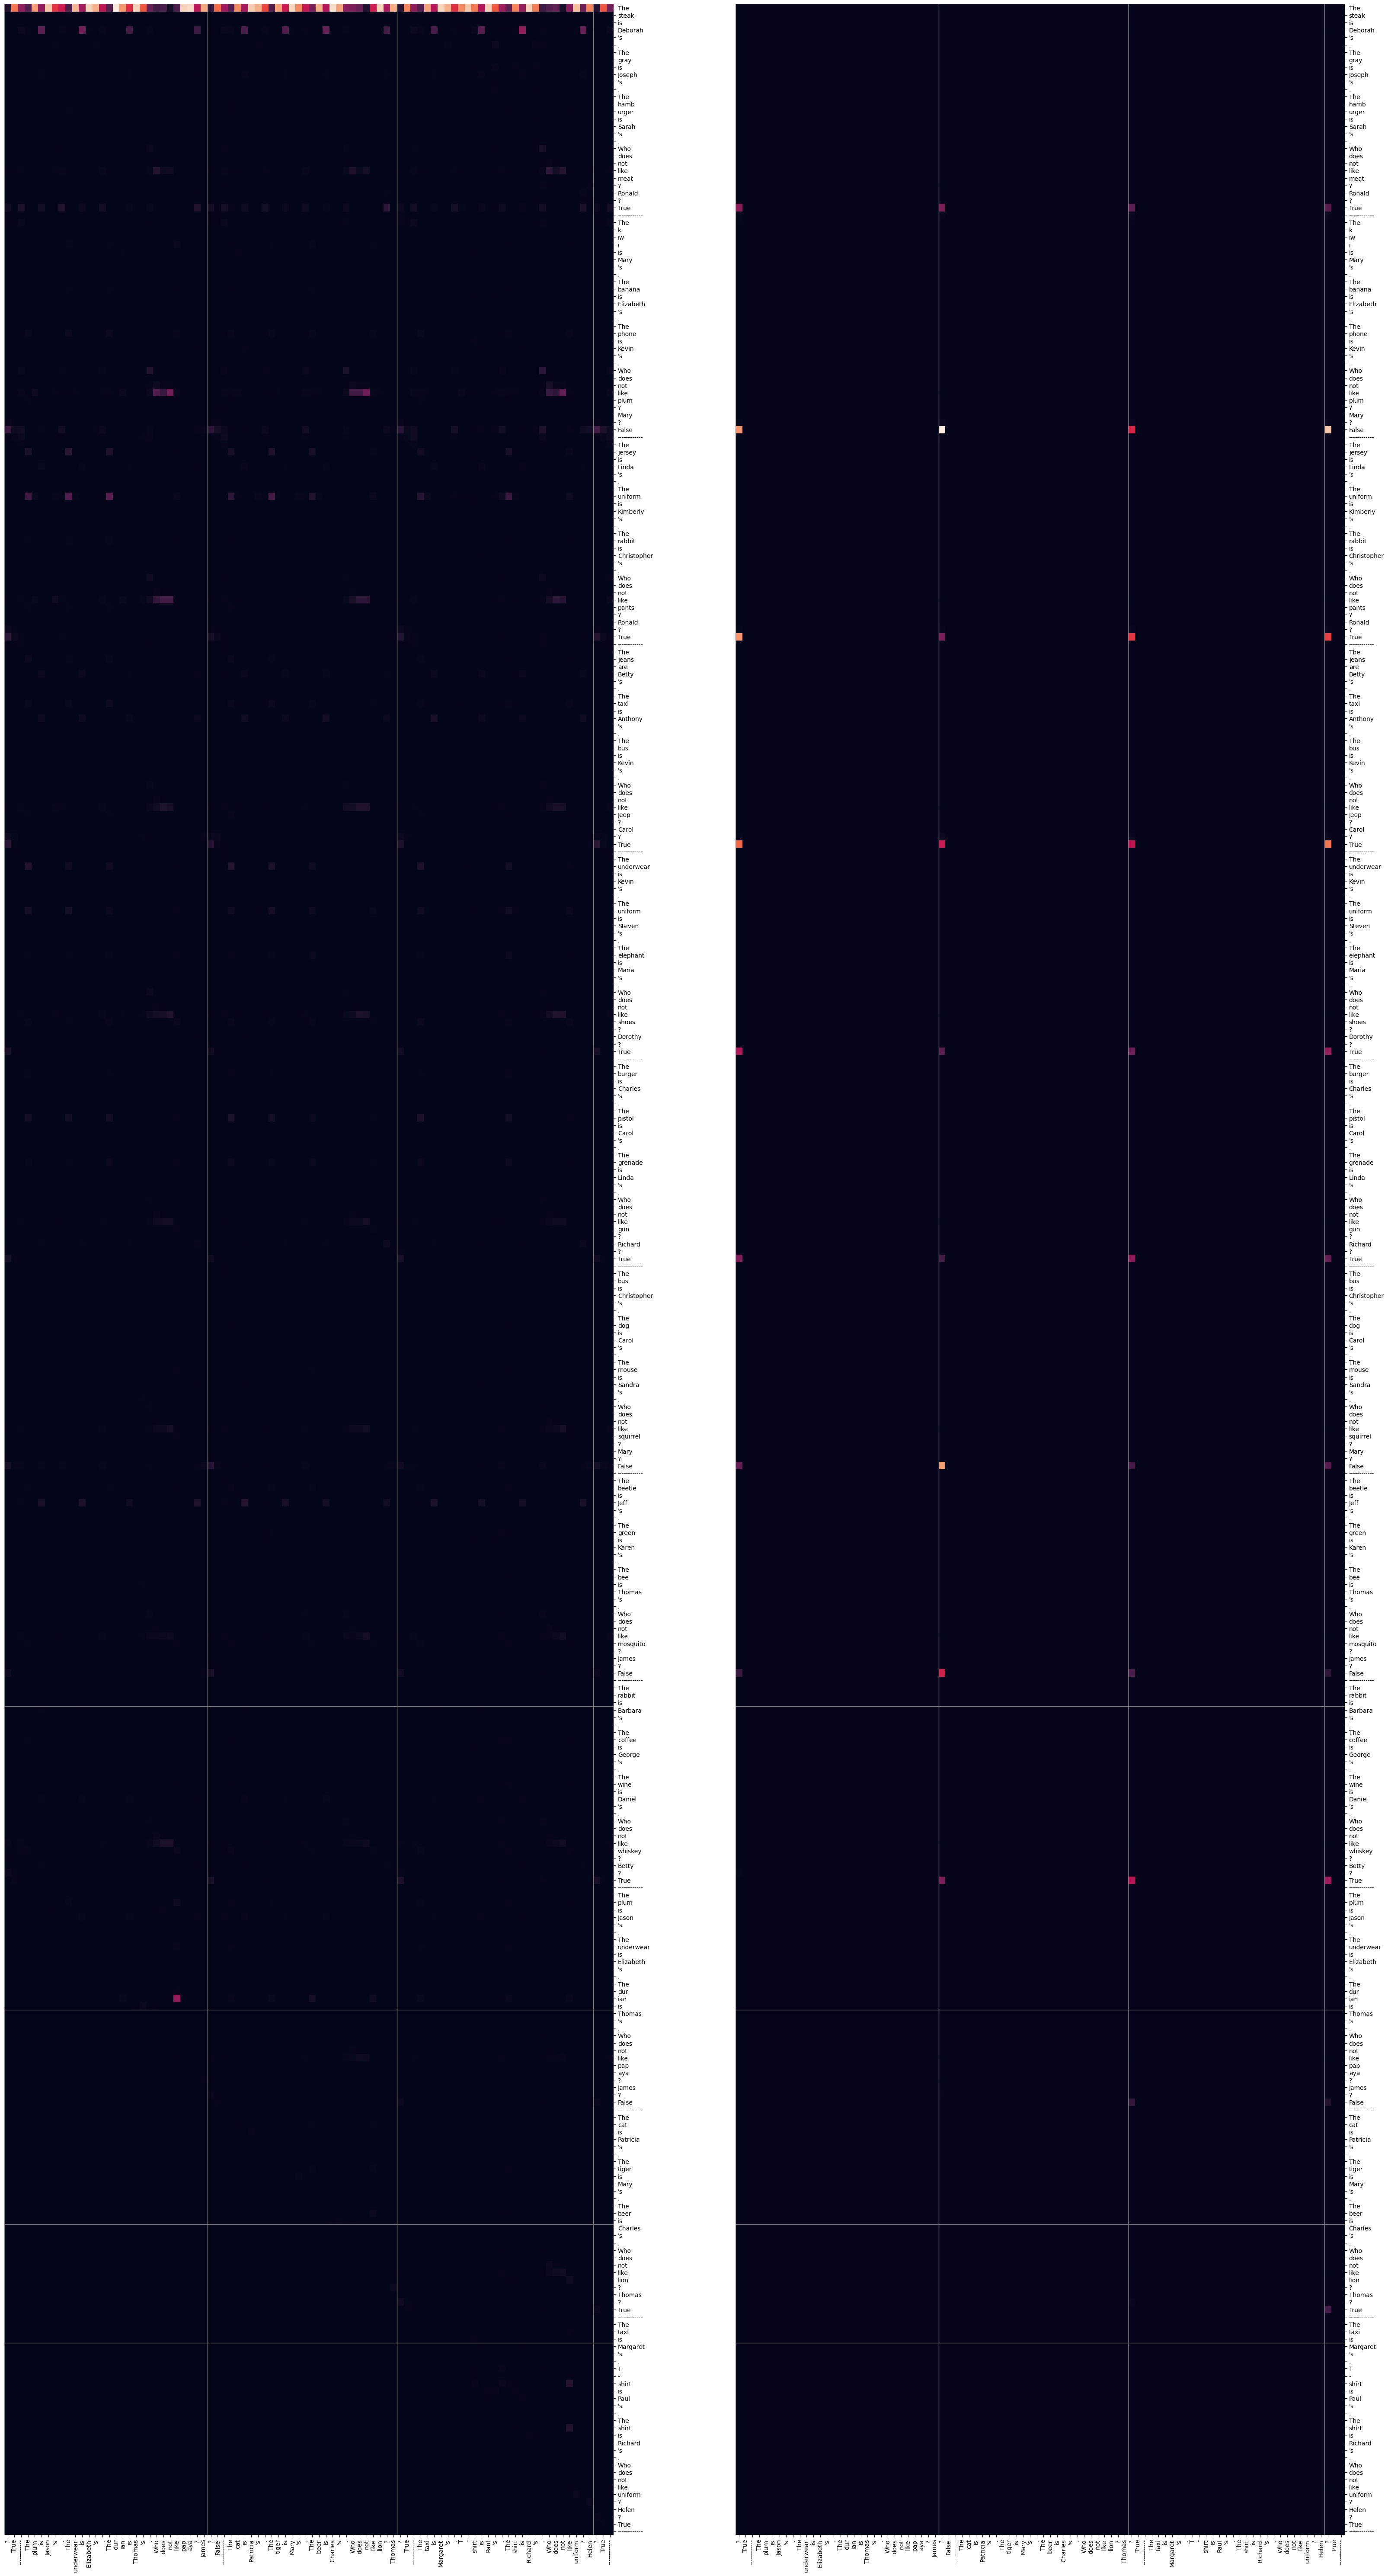

reduced_ap_scores = tensor([8.1074e-05, 2.7616e-05, 3.8603e-06, 1.4215e-05]) tensor(3.1691e-05)


In [65]:
node = r.root
plot_attn_attrs(r.data_tuples[:2], model, tokenizer, node, topi=[0,1], attn_patterns=['B->A0'], k_shot=8)

In [24]:
text = '''There are red, wolf, red. Which is not red? The wolf
There are pineapple, blue, blue. Which is not blue? The pineapple
There are pink, grapes, pink. Which is not pink? The grapes
'''
tokens = tokenizer.tokenize(text)

# attn_patterns_by_step = {
#     -1: ['bos->ans0'],
#     0: ['bos->ans]', 'bos->query', 'bos->ans0+', 'bos->tgt',
#         'bos->sep',  # 11-4
#         'bos->sep+',  # 13-11
#         'bos->query-', # 10-11?
#         ],
#     1: ['ans]->ans0]', 'ans]->ans0+', 'query->tgt','query->tgt+', 'query->ans0', 'tgt->ans0'],
#     2: ['ans0->tgt', 'ans0->tgt+'], 3: ['tgt+->tgt']
# }

In [26]:
tokens[13]

'ĠThe'

In [23]:

r.data_tuples[0][3][0]

'\nRuth has bread. Paul has cake. Richard has pizza. Paul likes cake\nGeorge has violin. Mary has rabbit. Ruth has costume. Ruth likes costume\nSandra has blueberries. Kenneth has shotgun. Paul has pear. Paul likes pear\n'

Ranges(bos=(13, 14), ans=(14, 15), ans0=(4, 5), query=(11, 12), tgt=(4, 5), sep=(7, 8), ans0s=(array([2, 4, 2]), array([3, 5, 3])), example=(0, 15))

 ┌@[0,2,3,4,5,6,7,8,9] 16-7,16-0,20-8,21-13,19-14,18-13,17-9,19-4,14-6 B->A0 83
 ├@[1] 24-10 B->B 10
 ├@0 16-7 100 B->A0 97/41/93/-2.5 attn/ans0s
 ├@0 16-7 100 B->A0 97/41/93/-2.5 attn:B->~<s>
 ├@2 16-0 79 B->A0 97/33/81/-2.6 attn/ans0s
 ├@2 16-0 79 B->A0 97/33/81/-2.6 attn:B->~<s>
 ├@3 20-8 65 B->A0 86/21/27/-3.0 attn/ans0s
 ├@4 21-13 65 B->A0 95/26/70/-3.2 attn/ans0s
 ├@4 21-13 65 B->A0 95/26/70/-3.2 attn:B->~<s>
 ├@5 19-14 42 B->A0 92/17/46/-3.7 attn/ans0s
 ├@6 18-13 42 B->A0 88/25/59/-3.4 attn/ans0s
 ├@6 18-13 42 B->A0 88/25/59/-3.4 attn:B->~<s>
 ├@7 17-9 37 B->A0 92/21/72/-3.7 attn/ans0s
 ├@7 17-9 37 B->A0 92/21/72/-3.7 attn:B->~<s>
 ├@8 19-4 36 B->A0 83/13/-18/-3.6 attn/ans0s
 ├@9 14-6 35 B->A0 98/62/68/-4.1 attn/ans0s
 ├@9 14-6 35 B->A0 98/62/68/-4.1 attn:B->~<s>
 ├@10 13-7 33 B->A0/40/75 attn/ans0s
 ├@10 13-7 33 B->A0/40/75 attn:B->~<s>
 ├@30 25-9 9 B->A0/35/61 attn/ans0s
 ├@30 25-9 9 B->A0/35/61 attn:B->~<s>
 ├@475 20-0 -91 B->A0/57/66 attn/ans0s
 ├@475 20-0 -91 B->A0/57/66 at

In [34]:
text = '''The bread is Ruth's. The cake is Paul's. The pizza is Richard's. Paul likes cake
The violin is George's. The rabbit is Mary's. The costume is Ruth's. Ruth likes costume
The blueberries are Sandra's. The shotgun is Kenneth's. The pear is Paul's. Paul likes pear
The pig is George's. The phone is Betty's. The yellow is Linda's. Linda likes yellow
The juice is Steven's. The apple is Maria's. The burger is Jennifer's. Jennifer likes burger
The grapes is Sandra's. The shoes are Joseph's. The squirrel is Jason's. Joseph likes shoes
The mosquito is Sharon's. The sheep is George's. The pistol is Thomas's. George likes sheep
The mango is John's. The beetle is George's. The pants is Paul's. George likes beetle
The donkey is Susan's. The pizza is Carol's. The jeans is Sarah's. Susan likes donkey
The burger is Dorothy's. The strawberries is Ruth's. The lime is Joseph's. Joseph likes lime
The bus is Deborah's. The pink is Ronald's. The goose is Michelle's. Michelle likes goose
The deer is Laura's. The blueberries are Joseph's. The goat is Nancy's. Laura likes deer
'''.strip().split('\n')

In [13]:
o = Ranges()

In [18]:
isinstance(o,dict)

False

In [36]:
'@@'.join(text)

"The bread is Ruth's. The cake is Paul's. The pizza is Richard's. Paul likes cake@@The violin is George's. The rabbit is Mary's. The costume is Ruth's. Ruth likes costume@@The blueberries are Sandra's. The shotgun is Kenneth's. The pear is Paul's. Paul likes pear@@The pig is George's. The phone is Betty's. The yellow is Linda's. Linda likes yellow@@The juice is Steven's. The apple is Maria's. The burger is Jennifer's. Jennifer likes burger@@The grapes is Sandra's. The shoes are Joseph's. The squirrel is Jason's. Joseph likes shoes@@The mosquito is Sharon's. The sheep is George's. The pistol is Thomas's. George likes sheep@@The mango is John's. The beetle is George's. The pants is Paul's. George likes beetle@@The donkey is Susan's. The pizza is Carol's. The jeans is Sarah's. Susan likes donkey@@The burger is Dorothy's. The strawberries is Ruth's. The lime is Joseph's. Joseph likes lime@@The bus is Deborah's. The pink is Ronald's. The goose is Michelle's. Michelle likes goose@@The deer i

In [74]:
# r.data_tuples[0][-1].inputs_embeds.shape
r.data_tuples[0][-1].attentions[0].shape
# r.data_tuples[0][-1].attn_outputs.shape

torch.Size([1, 16, 266, 266])

In [24]:
from pt_model_recorder import BatchShareMemRecorder
recorder = BatchShareMemRecorder(prefix="LLAMA-7B_0313_")

In [26]:
batch_logits = list(recorder._load('output-output')[0].unsqueeze(1))

In [29]:
batch_logits[0].shape

torch.Size([1, 268, 32000])

In [ ]:
'''
tok_embeddings-output
'''

In [ ]:
# 先去拼接哪里
# list 每个 list 是一个 o


In [126]:
len(sets_rules)

34

In [35]:
layers = 40
hidden_states_rules = ['tok_embeddings-output'] + [layer + str(number) + name for layer, number, name in product(['layers.'], range(layers), ['-output'])] +['norm-output']
mlp_rules = [layer + str(number)  + name for layer, number, name in product(['layers.'], range(layers), ['.feed_forward-output'])]
attention_rules = [layer + str(number)  + name for layer, number, name in product(['layers.'], range(layers), ['.attention-output'])]

In [36]:
batch_all_hidden_states, batch_mlp_outputs, batch_attn_outputs, batch_all_attentions, batch_values, batch_attn_outs = [], [], [], [], [], []
batch_all_hidden_states = [list(recorder._load(key)[0].unsqueeze(1)) for key in hidden_states_rules]
batch_mlp_outputs = [list(recorder._load(key)[0].unsqueeze(1)) for key in mlp_rules]
unsqueeze_dim1 = partial(torch.unsqueeze, dim = 1)
def converse(values):
    return [list(value.unsqueeze(dim = 1)) for value in values]
aa = zip(*[converse(recorder._load(key)) for key in attention_rules])

# batch_attn_outputs, batch_all_attentions, batch_values, batch_attn_outs# for key in attention_rules:
batch_logits = list(recorder._load('output-output')[0].unsqueeze(1))

BadZipFile: Bad CRC-32 for file 'arr_1.npy'

In [353]:
len(list(aa)[0])

IndexError: list index out of range

In [343]:
attn_fwd_output = zip(*batch_all_hidden_states), zip(*batch_mlp_outputs),zip(*batch_attn_outputs),zip(*batch_all_attentions),zip(*batch_values),zip(*batch_attn_outs), batch_logits
batch_outputs = []
for all_hidden_states, mlp_outputs, attn_outputs, all_attentions, values, attn_outs,logits in zip(*attn_fwd_output):
    o = Outputs(
        inputs_embeds=all_hidden_states[0], 
        attn_outputs=attn_outputs, values=values, attn_outs=attn_outs,mlp_outputs=mlp_outputs,
        hidden_states=all_hidden_states, attentions=all_attentions, 
        logits= logits)
    batch_outputs.append(o)

In [339]:
len(batch_outputs[0].hidden_states)

34

In [326]:
aa= list(zip(*batch_all_attentions))

In [327]:
aa[0][0].shape

torch.Size([1, 32, 389, 389])

In [292]:
for (logits) in zip(*batch_logits):
    print(len(logits))

8


In [285]:
batch_outputs[0].logits.shape

torch.Size([1, 389, 32000])

In [273]:
 all_hidden_states = tuple(hidden_states[:,:10,:] for hidden_states in batch_outputs[0].hidden_states)
# len(batch_outputs[0].hidden_states)

In [276]:
all_hidden_states[0].shape

torch.Size([1, 10, 4096])

In [228]:
aa = recorder._load('tok_embeddings-output')

torch.Size([1, 389, 4096])

In [217]:
batch_outputs[0].logits.shape

torch.Size([1, 389, 32000])

In [251]:
llamatokenizer.convert_ids_to_tokens(3)

'<0x00>'

In [193]:
from openai_utils import *

In [21]:
import pickle

In [97]:
with open('/nas/xd/projects/transformers/notebooks/lxy/task_accuary_gpt_neox.pickle', 'rb') as file:   #用with的优点是可以不用写关闭文件操作
    dict_gpt_neox = pickle.load(file)
with open('/nas/xd/projects/transformers/notebooks/lxy/task_accuary_gptj.pickle', 'rb') as file:   #用with的优点是可以不用写关闭文件操作
    dict_gptj = pickle.load(file)
with open('/nas/xd/projects/transformers/notebooks/lxy/task_accuary_llama_7B.pickle', 'rb') as file:   #用with的优点是可以不用写关闭文件操作
    dict_llama_7B = pickle.load(file)
with open('/nas/xd/projects/transformers/notebooks/lxy/task_accuary_text_davinci003.pickle', 'rb') as file:   #用with的优点是可以不用写关闭文件操作
    dict_davinci = pickle.load(file)

In [86]:
len(results)

188

In [98]:
accury = 0
for key, value in dict_gpt_neox.items():
    accury += value['mean_acc']
print(accury / len(dict_gpt_neox))
accury = 0
for key, value in dict_gptj.items():
    accury += value['mean_acc']
print(accury / len(dict_gptj))
accury = 0
for key, value in dict_llama_7B.items():
    accury += value['mean_acc']
print(accury / len(dict_llama_7B))
accury = 0
for key, value in dict_davinci.items():
    accury += value['mean_acc']
print(accury / len(dict_davinci))

0.46261820330969283
0.46317228132387683
0.615211288416076
0.6729831560283688


In [87]:
keys = list(dict_davinci.keys())

In [88]:
keys

['MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]',
 'g2c[MlM_gen][genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]',
 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]',
 'g2c[MlM_gen][genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]',
 'MlM_gen[genders_of_persons.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3]',
 'g2c[MlM_gen][genders_of_persons.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3]',
 'MlM_gen[genders_of_persons.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]',
 'g2c[MlM_gen][genders_of_persons.TreeSet.neg_equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]']

In [141]:
key1 = 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]'

In [142]:
dict_llama_7B[key1]
# results[key1]

{'texts': ("The bread is  Ruth's. The cake is Paul's. The pizza is Richard's. Paul likes cake\nThe violin is George's. The rabbit is Mary's. The costume is Ruth's. Ruth likes costume\nThe blueberries are Sandra's. The shotgun is Kenneth's. The pear is Paul's. Paul likes pear\nThe pig is George's. The phone is Betty's. The yellow is Linda's. Linda likes yellow\nThe juice is Steven's. The apple is Maria's. The burger is Jennifer's. Jennifer likes burger\nThe grapes are Sandra's. The shoes are Joseph's. The squirrel is Jason's. Joseph likes shoes\nThe mosquito is Sharon's. The sheep are George's. The pistol is Thomas's. George likes sheep\nThe mango is John's. The beetle is George's. The pants are Paul's. George likes beetle\nThe donkey is Susan's. The pizza is Carol's. The jeans are Sarah's. Susan likes donkey\nThe burger is Dorothy's. The strawberries are Ruth's. The lime is Joseph's. Joseph likes lime\nThe bus is Deborah's. The pink is Ronald's. The goose is Michelle's. Michelle likes 

In [56]:
dictnew = {}
for key in keys:
    dictnew[key] = {'texts': dict_llama_7B[key]['texts'], 'acc_cha' : dict_llama_7B[key]['mean_acc'] - dict_davinci[key]['mean_acc']}
listss = sorted(dictnew.items(), key = lambda x: x[1]['acc_cha'], reverse = True)

In [58]:
listss[0]

('rm_query[MlM_gen][genders_of_persons.TreeSet.neg_equal,types_of_things.TreeSet.child][cxt_len=3]',
 {'texts': ('Barbara has bread. Barbara has a cocktail. Daniel has a goat. Which is different? The animal\nRuth has a mosquito. Ruth has pizza. Sharon has a T-shirt. Which is different? The clothing\nKevin has a hamburger. John has a Jeep. John has cherries. Which is different? The food\nKevin has a baseball. Kevin has a duck. Michelle has a phone. Which is different? The electronics\nThomas has a rabbit. Thomas has bread. Mark has wine. Which is different? The drink\nRichard has a piano. Brian has blue. Richard has a donkey. Which is different? The color\nJeff has a Jeep. John has pants. Jeff has a bus. Which is different? The clothing\nElizabeth has a gun. Elizabeth has blackberries. Ronald has sheep. Which is different? The animal\nJeff has soda. Mark has a bus. Jeff has a mouse. Which is different? The vehicle\nBetty has a motorcycle. Mark has a guitar. Betty has a tiger. Which is d

Text(0.5, 0, 'gptj - llama 7B')

Text(0, 0.5, 'mean_acc')

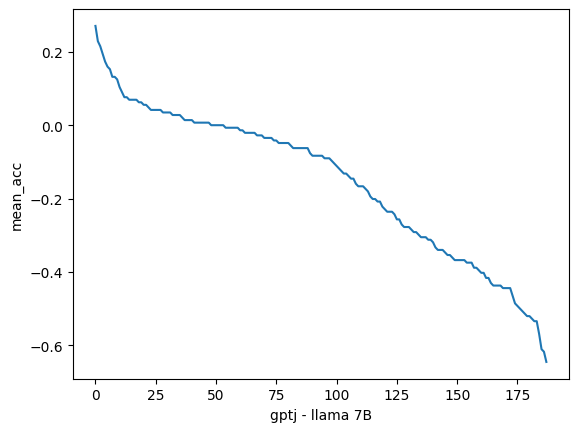

In [70]:
x_y = [(line[0],line[1]['acc_cha'] )for line in listss]
x = [i[0] for i in x_y]
y = [i[1] for i in x_y]
plt.plot(range(len(y)),y)
plt.xlabel('gptj - llama 7B')
plt.ylabel('mean_acc')
plt.show()

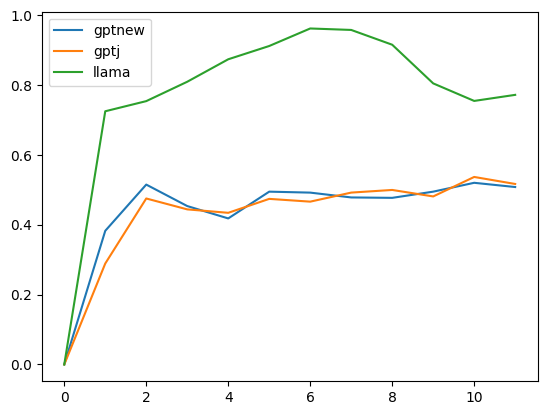

In [34]:
plt.plot(dict_get1[a]['answer_probs'],label = 'gptnew')
plt.plot(dict_get2[a]['answer_probs'],label = 'gptj')
plt.plot(dict_get3[a]['answer_probs'],label = 'llama')
plt.legend()
plt.show()

In [35]:
dict_get1[a]

{'texts': ('Edward has a duck. Steven has a duck. Nancy has a Jeep. Who is different? The boy? False\nPaul has red. Barbara has a goat. Jennifer has a goat. Who is different? The girl? False\nCharles has a laptop. Lisa has another dog. Daniel has a laptop. Who is different? The boy? False\nWilliam has a fox. Robert has a fox. Betty has a donkey. Who is different? The boy? False\nDeborah has a bus. Christopher has a pear. Helen has a bus. Who is different? The boy? True\nDavid has a piano. Linda has a donkey. Laura has a donkey. Who is different? The girl? False\nDeborah has blueberries. Susan has blueberries. Anthony has a cow. Who is different? The boy? True\nKaren has soda. Kevin has a piano. Brian has a piano. Who is different? The boy? False\nMargaret has a revolver. Kenneth has trousers. Christopher has trousers. Who is different? The girl? True\nLinda has a pear. Christopher has a bee. George has a bee. Who is different? The girl? True\nPatricia has underwear. Kevin has a bee. Do

In [33]:
# a = 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]'
# a = 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]'
a = 'g2c[rm_query[MlM_gen]][types_of_things.TreeSet.neg_equal,genders_of_persons.TreeSet.child][cxt_len=3]'

In [21]:
import matplotlib as plt

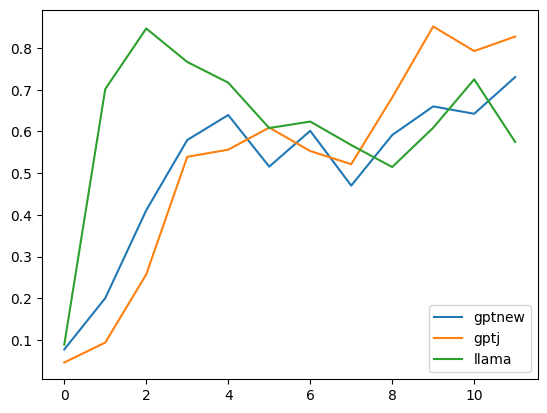

In [28]:

plt.plot(dict_get1[a]['answer_probs'],label = 'gptnew')
plt.plot(dict_get2[a]['answer_probs'],label = 'gptj')
plt.plot(dict_get3[a]['answer_probs'],label = 'llama')
plt.legend()
plt.show()

In [29]:
dict_get1[a]
dict_get2[a]
dict_get3[a]

{'texts': ('Ruth has bread. Paul has cake. Richard has pizza. Paul likes cake\nGeorge has a violin. Mary has a rabbit. Ruth has a costume. Ruth likes costume\nSandra has blueberries. Kenneth has a shotgun. Paul has a pear. Paul likes pear\nGeorge has a pig. Betty has a phone. Linda has yellow. Linda likes yellow\nSteven has juice. Maria has an apple. Jennifer has a burger. Jennifer likes burger\nSandra has grapes. Joseph has shoes. Jason has a squirrel. Joseph likes shoes\nSharon has a mosquito. George has sheep. Thomas has a pistol. George likes sheep\nJohn has a mango. George has a beetle. Paul has pants. George likes beetle\nSusan has a donkey. Carol has pizza. Sarah has jeans. Susan likes donkey\nDorothy has a burger. Ruth has strawberries. Joseph has a lime. Joseph likes lime\nDeborah has a bus. Ronald has pink. Michelle has a goose. Michelle likes goose\nLaura has a deer. Joseph has blueberries. Nancy has a goat. Laura likes deer\n',),
 'mean_loss': 1.0037716384977102,
 'mean_acc

{'texts': ('Ruth has bread. Paul has cake. Richard has pizza. Paul likes cake\nGeorge has a violin. Mary has a rabbit. Ruth has a costume. Ruth likes costume\nSandra has blueberries. Kenneth has a shotgun. Paul has a pear. Paul likes pear\nGeorge has a pig. Betty has a phone. Linda has yellow. Linda likes yellow\nSteven has juice. Maria has an apple. Jennifer has a burger. Jennifer likes burger\nSandra has grapes. Joseph has shoes. Jason has a squirrel. Joseph likes shoes\nSharon has a mosquito. George has sheep. Thomas has a pistol. George likes sheep\nJohn has a mango. George has a beetle. Paul has pants. George likes beetle\nSusan has a donkey. Carol has pizza. Sarah has jeans. Susan likes donkey\nDorothy has a burger. Ruth has strawberries. Joseph has a lime. Joseph likes lime\nDeborah has a bus. Ronald has pink. Michelle has a goose. Michelle likes goose\nLaura has a deer. Joseph has blueberries. Nancy has a goat. Laura likes deer\n',),
 'mean_loss': 0.6420407760888338,
 'mean_acc

{'texts': ('Ruth has bread. Paul has cake. Richard has pizza. Paul likes cake\nGeorge has a violin. Mary has a rabbit. Ruth has a costume. Ruth likes costume\nSandra has blueberries. Kenneth has a shotgun. Paul has a pear. Paul likes pear\nGeorge has a pig. Betty has a phone. Linda has yellow. Linda likes yellow\nSteven has juice. Maria has an apple. Jennifer has a burger. Jennifer likes burger\nSandra has grapes. Joseph has shoes. Jason has a squirrel. Joseph likes shoes\nSharon has a mosquito. George has sheep. Thomas has a pistol. George likes sheep\nJohn has a mango. George has a beetle. Paul has pants. George likes beetle\nSusan has a donkey. Carol has pizza. Sarah has jeans. Susan likes donkey\nDorothy has a burger. Ruth has strawberries. Joseph has a lime. Joseph likes lime\nDeborah has a bus. Ronald has pink. Michelle has a goose. Michelle likes goose\nLaura has a deer. Joseph has blueberries. Nancy has a goat. Laura likes deer\n',),
 'mean_loss': 1.3742405227385461,
 'mean_acc

In [6]:
a

{'texts': ('Ruth has bread. Paul has cake. Richard has pizza. Paul likes cake\nGeorge has a violin. Mary has a rabbit. Ruth has a costume. Ruth likes costume\nSandra has blueberries. Kenneth has a shotgun. Paul has a pear. Paul likes pear\nGeorge has a pig. Betty has a phone. Linda has yellow. Linda likes yellow\nSteven has juice. Maria has an apple. Jennifer has a burger. Jennifer likes burger\nSandra has grapes. Joseph has shoes. Jason has a squirrel. Joseph likes shoes\nSharon has a mosquito. George has sheep. Thomas has a pistol. George likes sheep\nJohn has a mango. George has a beetle. Paul has pants. George likes beetle\nSusan has a donkey. Carol has pizza. Sarah has jeans. Susan likes donkey\nDorothy has a burger. Ruth has strawberries. Joseph has a lime. Joseph likes lime\nDeborah has a bus. Ronald has pink. Michelle has a goose. Michelle likes goose\nLaura has a deer. Joseph has blueberries. Nancy has a goat. Laura likes deer\n',),
 'mean_loss': 1.0037716384977102,
 'mean_acc

In [ ]:
The apple is here.
The coffee is here.
The shoes are here.
The red is here.
The blueberries are here.

In [181]:
query_openai('John has a mouse', 'text-davinci-003')

[INFO][2023-03-20 18:46:10][openai_utils.py:32] - In query_openai: John has a mouse -> 


''

In [182]:
_be('The animal')

[INFO][2023-03-20 18:52:27][openai_utils.py:32] - In query_openai: The animal  ->  is here.


'The animal is'

In [164]:
from openai_utils import *

In [165]:
# from model_utils_lxy import *
query_openai('aaa','text-davinci-003')

[INFO][2023-03-20 18:28:24][openai_utils.py:32] - In query_openai: aaa -> 


''

In [118]:
nrows, k_shot = 12, 3; cxt_len = 3; save_results = False
batch_size = 16; verbose = True # not save_results or batch_size <= 8

rel0_kwargs_list = [{'skip_inv_f': True},{'skip_inv_f': False}][:]
rel1_kwargs_list = [{'x_f': None, 'y_f': None, 'skip_inv_f': True}, {'x_f': _s, 'y_f': a_, 'skip_inv_f': True},
                    {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}][:]
for task,        rel0_kwargs,     rel1_kwargs, do_swap_qa, do_negate, do_rm_local_hop, do_rm_query, rev_item2str, do_g2c in product(
    tasks[1:2],rel0_kwargs_list,rel1_kwargs_list,[False, True],[False, True], [False, True], [False, True], [False,True], [False, True]):
#     seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_kwargs=rel0_kwargs, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_local_hop=do_rm_local_hop, do_rm_query=do_rm_query, do_g2c=do_g2c)
    task = transform_task(task, **trans_args)
    if task is None: print('task is None! skip.'); continue
    res_key = f'{task2str(task)}[{args2str(args)}]'# + composed_heads2str(model)
    
#     if key is not None and res_key != key: continue
    if not validate_args(task, args, trans_args): print('invalid args! skip.'); continue
#     if has_attribution_results(res_key): continue
    print(f'\n== {res_key} == {args2str(trans_args)}')
    

    r = results[res_key] if save_results and res_key in results else None
    args['max_length'] = 512
    r = generate_and_predict_batch(model, tokenizer, task, nrows, k_shot, batch_size,
                                trim=False, result=r, verbose=verbose, **args)
#     if save_results: results[res_key] = r
#     if not save_results or getattr(r, 'mean_acc', 0) < 0.45: continue
# #     load_attribution_results(r, res_key)
#     if True or r.root is None: r.root = add_node(None, layer=L, label_type='labels')
#     r.root = attribute_tree_on(r.data_tuples, model, r.root, 1, topk=20//2, k_shot=k_shot, device=device, verbose=True)
#     with Timer('save_attribution_results'): save_attribution_results(r, res_key)
#     r.data_tuples = [dt[:-1] + [trim_outputs(dt[-1])] for dt in r.data_tuples] # to save mem. data_tuple is list!


== MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3] == rel0_kwargs=(skip_inv_f),rel1_kwargs=(skip_inv_f)
Steven has rabbit. Jason has lime. Jennifer has laptop. Jennifer likes laptop
Mary has fox. George has apricot. Donald has taxi. Mary likes fox
Steven has plum. Edward has beetle. Michelle has laptop. Michelle likes laptop
David has wolf. Nancy has baseball. Brian has peach. Nancy likes baseball
William has duck. Michelle has laptop. Kimberly has phone. William likes duck
Donald has duck. Carol has pants. Robert has cherry. Carol likes pants
Charles has piano. Deborah has shoes. Anthony has cannon. Deborah likes shoes
Linda has meat. Dorothy has costume. Kevin has bee. Kevin likes bee
Elizabeth has smartphone. Joseph has gun. William has mosquito. Elizabeth likes smartphone
Elizabeth has whiskey. George has kiwi. Jason has white. Elizabeth likes whiskey
Brian has bee. Kenneth has sweater. Dorothy has lion. Dorothy likes lion
Linda has duck. Daniel 

There are wine, coffee, a pear. Which is pear? The pear
There are coffee, pink, a fox. Which is pink? The pink
There are a cat, spaghetti, strawberries. Which is spaghetti? The spaghetti
There are a squirrel, a wolf, a baseball. Which is baseball? The baseball
There are meat, T-shirt, a mosquito. Which is mosquito? The mosquito
There are coffee, a cherry, a shotgun. Which is shotgun? The shotgun
There are a guitar, a laptop, purple. Which is purple? The purple
There are a uniform, an orange, a pig. Which is orange? The orange
There are meat, a pear, a uniform. Which is meat? The meat
There are a laptop, a basketball, a cannon. Which is laptop? The laptop
There are juice, a beetle, a car. Which is car? The car
There are cake, a watermelon, a cherry. Which is cake? The cake


== g2c(MlM_gen)[types_of_things.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3] == rel0_kwargs=(skip_inv_f),rel1_kwargs=(skip_inv_f),do_swap_qa,do_rm_local_hop,do_g2c
There are a guitar, a fox, a uniform. Wh

There are a laptop, meat, an iPad. Which is different? The meat
There are an iPad, shoes, a smartphone. Which is different? The shoes
There are white, red, a shotgun. Which is different? The shotgun
There are underwear, a basketball, a baseball. Which is different? The underwear
There are a guitar, bread, a pizza. Which is different? The guitar
There are a goat, whiskey, wine. Which is different? The goat
There are a laptop, an iPad, a mouse. Which is different? The mouse
There are a beetle, a bee, a hamburger. Which is different? The hamburger
There are a football, a basketball, a jersey. Which is different? The jersey
There are underwear, a shirt, a guitar. Which is different? The guitar
There are a papaya, a kiwi, a bus. Which is different? The bus
There are a plum, wine, vodka. Which is different? The plum


== g2c('rm_query'[MlM_gen])[types_of_things.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3] == rel0_kwargs=(skip_inv_f),rel1_kwargs=(skip_inv_f),do_swap_qa,do_negate,do

The sheep is Richard's. The cannon is Karen's. The pizza is John's. Karen does not like cannons
The vodka is Donald's. The shotgun is Brian's. The bread is Donna's. Donna does not like bread
The donkey is George's. The shotgun is David's. The lime is Nancy's. Nancy does not like limes
The jeans is Mark's. The guitar is Betty's. The coffee is Christopher's. Betty does not like guitars
The basketball is Ronald's. The blue is Susan's. The cake is Maria's. Ronald does not like basketball
The papaya is Jeff's. The baseball is Sarah's. The banana is Kevin's. Sarah does not like baseball
The black is Linda's. The blue is Sharon's. The fox is Daniel's. Daniel does not like foxes
The lime is Mary's. The steak is David's. The sheep is Steven's. Mary does not like limes
The peach is Nancy's. The cannon is Daniel's. The basketball is Sandra's. Daniel does not like cannons
The phone is Daniel's. The revolver is Lisa's. The dog is John's. Lisa does not like revolvers
The cat is Sharon's. The shotgun

Lisa has pants. Betty has a costume. Donald has a football. Who likes football? Donald
Mary has a T-shirt. Brian has a bee. Karen has a horse. Who likes bees? Brian
Karen has a lemon. Kenneth has gray. Jennifer has a papaya. Who likes gray? Kenneth
William has purple. Karen has a cow. Jennifer has an apricot. Who likes purple? William
Joseph has a taxi. Betty has a basketball. Edward has coffee. Who likes basketball? Betty
Susan has bread. Joseph has a beetle. Donna has an apricot. Who likes beetles? Joseph
Karen has a cherry. George has a rifle. Betty has jeans. Who likes rifles? George
Helen has an apricot. Joseph has an elephant. William has a goose. Who likes apricots? Helen
George has a mango. Nancy has a rabbit. Barbara has a cocktail. Who likes mangoes? George
Joseph has a motorcycle. Jennifer has a plum. Michelle has a kiwi. Who likes motorcycles? Joseph
Betty has white. Karen has tea. Joseph has a baseball. Who likes baseball? Joseph
Kevin has vodka. Brian has a pear. Jennifer

Deborah has coffee. Edward has red. Paul has black. Who does not like coffee? Deborah
Sarah has a piano. Laura has a violin. Richard has a taxi. Who does not like taxis? Richard
Barbara has a pig. Mark has a guitar. John has a piano. Who does not like pigs? Barbara
Michael has juice. Maria has a phone. Margaret has a smartphone. Who does not like juice? Michael
Michael has shoes. Carol has a cherry. Kevin has a T-shirt. Who does not like cherries? Carol
Mark has a football. Steven has a basketball. Betty has a piano. Who does not like pianos? Betty
Dorothy has a horse. David has a shotgun. John has a cannon. Who does not like horses? Dorothy
Betty has a beetle. Lisa has a bee. John has a piano. Who does not like pianos? John
Thomas has jeans. Donald has trousers. Donna has cake. Who does not like cake? Donna
Donna has a rabbit. Paul has a laptop. Sarah has a tiger. Who does not like laptops? Paul
Edward has a pig. Jason has a donkey. Donna has a Jeep. Who does not like Jeeps? Donna
Eli

There are wine, a piano, a guitar. Which is not wine? The wine
There are cake, a bee, a beetle. Which is not cake? The cake
There are a violin, a revolver, a guitar. Which is not revolvers? The a revolver
There are strawberries, soda, grapes. Which is not soda? The soda
There are a baseball, whiskey, a basketball. Which is not whiskey? The whiskey
There are a Jeep, a taxi, a football. Which is not football? The a football
There are a Jeep, a piano, a car. Which is not pianos? The a piano
There are a taxi, a jersey, a Jeep. Which is not jerseys? The a jersey
There are a mango, a bus, a pear. Which is not buses? The a bus
There are a mosquito, a piano, a guitar. Which is not mosquitoes? The a mosquito
There are beer, soda, a horse. Which is not horses? The a horse
There are a squirrel, spaghetti, cake. Which is not squirrels? The a squirrel


== g2c(MlM_gen)[types_of_things.TreeSet.equal[x_f=_s,y_f=a_],types_of_things.TreeSet.equal][cxt_len=3] == rel0_kwargs=(skip_inv_f),rel1_kwargs=(x_f

James has a handgun. Jason has a football. Sarah has a guitar. Sarah does not like weapons? False
Jeff has a gun. Helen has tea. Steven has a watermelon. Helen does not like drinks? True
Dorothy has a piano. Thomas has a baseball. Richard has a grenade. Dorothy does not like sports? False
Sharon has a baseball. Elizabeth has jeans. Jeff has a bee. Jeff does not like sports? False
Helen has a uniform. Deborah has a taxi. James has yellow. James does not like colors? True
Patricia has bread. Betty has a handgun. Ronald has underwear. Ronald does not like weapons? False
Margaret has a cannon. Patricia has coffee. James has a bus. James does not like vehicles? True
Linda has a pistol. Carol has a beetle. Charles has a Jeep. Charles does not like vehicles? True
Jennifer has a mouse. George has a shotgun. David has a mosquito. Jennifer does not like animals? True
Christopher has a horse. Donna has a costume. Paul has a banana. Donna does not like clothing? True
Jennifer has green. Jason has 


== g2c('rm_query'[MlM_gen])[genders_of_persons.TreeSet.equal,genders_of_persons.TreeSet.equal][cxt_len=3] == rel0_kwargs=(skip_inv_f),rel1_kwargs=(x_f=_s,y_f=a_),do_negate,do_rm_local_hop,do_rm_query,do_g2c
There are Ruth, Charles, Donna. Who is different? Donna? False
There are Betty, Laura, Charles. Who is different? Laura? False
There are Betty, Kenneth, Donna. Who is different? Kenneth? True
There are Anthony, Nancy, Dorothy. Who is different? Dorothy? False
There are Elizabeth, Kimberly, Daniel. Who is different? Elizabeth? False
There are Betty, Nancy, Robert. Who is different? Nancy? False
There are Deborah, Michael, Nancy. Who is different? Deborah? False
There are Christopher, Linda, Paul. Who is different? Paul? False
There are Deborah, Ruth, Brian. Who is different? Deborah? False
There are Brian, Susan, Thomas. Who is different? Brian? False
There are Richard, Daniel, Jennifer. Who is different? Jennifer? True
There are Michelle, Brian, James. Who is different? Michelle? T

There are a jersey, a cow, a fox. Which is clothing? The a cow? False
There are a wolf, a piano, underwear. Which is music? The underwear? False
There are a basketball, a baseball, a duck. Which is animals? The a baseball? False
There are a beetle, tea, bread. Which is drinks? The tea? True
There are an elephant, a mosquito, an orange. Which is insects? The a mosquito? True
There are a piano, a peach, a laptop. Which is music? The a piano? True
There are a pig, a cow, a car. Which is vehicles? The a car? True
There are a uniform, a lion, a rifle. Which is weapons? The a rifle? True
There are a shirt, a bus, green. Which is clothing? The a bus? False
There are coffee, a guitar, a goose. Which is music? The a guitar? True
There are red, a costume, a piano. Which is music? The red? False
There are a durian, a piano, a laptop. Which is electronics? The a durian? False

invalid args! skip.
invalid args! skip.

transform_task failed: invalid rel for rm_query['child', 'equal'] (rel0_kwargs=(s

Mark has beer. Thomas has juice. Deborah has a bee. Who is different? Deborah? True
Margaret has a cherry. Christopher has gray. Joseph has pink. Who is different? Margaret? True
Charles has a bee. Robert has a beetle. Sharon has a cocktail. Who is different? Charles? False
Jason has an apple. Patricia has a revolver. Mary has a rifle. Who is different? Mary? False
Donna has a bee. Sharon has a mosquito. Ronald has a shotgun. Who is different? Donna? False
Deborah has a cocktail. Jennifer has coffee. Charles has a revolver. Who is different? Charles? True
Carol has pink. William has a squirrel. Maria has blue. Who is different? William? True
Sandra has coffee. Charles has a pistol. Ronald has a cannon. Who is different? Charles? False
Carol has a pear. Mary has a pineapple. Paul has a goose. Who is different? Mary? False
Kevin has a shirt. Karen has tea. Susan has a cocktail. Who is different? Kevin? True
Mark has a basketball. Daniel has a baseball. Kimberly has a monkey. Who is diffe


== MlM_gen[genders_of_persons.TreeSet.neg_child,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str] == rel0_kwargs=(),rel1_kwargs=(skip_inv_f),do_negate
The shoes is Thomas's. The guitar is Helen's. The pear is Kenneth's. The boys do not like guitar
The piano is Barbara's. The pink is Jason's. The motorcycle is Linda's. The girls do not like pink
The cat is Nancy's. The cannon is Daniel's. The beer is John's. The boys do not like cat
The T-shirt is Sandra's. The pineapple is Donald's. The sheep is Anthony's. The boys do not like T-shirt
The cow is Elizabeth's. The pear is Patricia's. The cake is Donald's. The girls do not like cake
The basketball is Brian's. The guitar is Laura's. The horse is Ronald's. The boys do not like guitar
The motorcycle is Jeff's. The car is William's. The jeans is Maria's. The boys do not like jeans
The gun is Donna's. The horse is Ronald's. The coffee is David's. The boys do not like gun
The lion is Mark's. The beetle is Patricia's. The fox is Jeff's. Th

The beer is Joseph's. The monkey is Betty's. The juice is Donald's. Who is different? the girl
The juice is Robert's. The whiskey is Brian's. The apricot is Margaret's. Who is different? the girl
The gray is Edward's. The plum is Sharon's. The yellow is Donald's. Who is different? the girl
The mango is Sarah's. The guitar is Daniel's. The piano is Jason's. Who is different? the girl
The red is Betty's. The blue is Sandra's. The mango is Jason's. Who is different? the boy
The wolf is Donna's. The vodka is Mark's. The gorilla is Dorothy's. Who is different? the boy
The horse is Mary's. The wine is Ronald's. The dog is Margaret's. Who is different? the boy
The guitar is Jennifer's. The piano is Elizabeth's. The apricot is George's. Who is different? the boy
The rifle is Margaret's. The donkey is Edward's. The pistol is Sharon's. Who is different? the boy
The apple is Donna's. The football is Robert's. The basketball is John's. Who is different? the girl
The mosquito is Deborah's. The bee 

Christopher has green. Richard has an orange. Kimberly has a taxi. The boys do not like taxis
John has a monkey. Maria has shoes. Michelle has coffee. The girls do not like monkeys
Steven has a laptop. Helen has a rabbit. Thomas has blueberries. The boys do not like rabbits
Thomas has beer. Brian has an elephant. Deborah has a car. The boys do not like cars
Richard has red. Maria has juice. John has a pig. The boys do not like juice
Paul has a goose. Patricia has a sweater. Steven has a violin. The boys do not like sweaters
John has a beetle. Dorothy has grapes. Sarah has strawberries. The girls do not like beetles
Kenneth has a peach. Lisa has a smartphone. Robert has a pizza. The boys do not like smartphones
Ronald has a handgun. Carol has a kiwi. William has a Jeep. The boys do not like kiwis
Margaret has a guitar. Donna has a revolver. Anthony has a uniform. The girls do not like uniforms
Kimberly has a rifle. George has a bus. Jeff has a mosquito. The boys do not like rifles
Jeff 

The blueberries is Sarah's. The sweater is David's. The meat is Ronald's. Which is different? The meat? False
The sheep is Linda's. The pink is Mark's. The gun is Brian's. Which is different? The sheep? True
The T-shirt is George's. The donkey is John's. The car is Elizabeth's. Which is different? The donkeys? False
The orange is Michael's. The soda is James's. The violin is Helen's. Which is different? The soda? False
The donkey is Maria's. The trousers is Anthony's. The kiwi is Edward's. Which is different? The donkeys? True
The dog is Robert's. The purple is Helen's. The wolf is Mark's. Which is different? The purple? True
The basketball is Laura's. The shirt is Daniel's. The plum is Sarah's. Which is different? The shirts? True
The cake is Sarah's. The plum is Joseph's. The grenade is Jeff's. Which is different? The plums? False
The fox is Daniel's. The pants is Sarah's. The vodka is Laura's. Which is different? The foxes? True
The gray is Susan's. The apricot is Paul's. The mouse 


== g2c(MlM_gen)[types_of_things.TreeSet.equal[x_f=_s,y_f=a_],types_of_things.TreeSet.equal][cxt_len=3] == rel0_kwargs=(),rel1_kwargs=(x_f=_s,y_f=a_,skip_inv_f),do_swap_qa,do_rm_local_hop,do_g2c
There are vodka, a shirt, a banana. Which is vodka? The a shirt? False
There are a rifle, an elephant, a bus. Which is buses? The a rifle? False
There are a guitar, a jersey, a sheep. Which is guitars? The a guitar? True
There are a banana, a bus, a basketball. Which is bananas? The a basketball? False
There are a durian, a cow, a steak. Which is steak? The a cow? False
There are a cocktail, a cow, a papaya. Which is papayas? The a cow? False
There are a shotgun, a kiwi, a fox. Which is shotguns? The a shotgun? True
There are a horse, a smartphone, a fox. Which is smartphones? The a horse? False
There are jeans, a durian, a burger. Which is jeans? The jeans? True
There are a hamburger, a guitar, a peach. Which is hamburgers? The a guitar? False
There are wine, shoes, a duck. Which is shoes? The

Jason has a mosquito. Elizabeth has a jersey. Christopher has a beetle. Who is different? the boy? False
Michael has a laptop. Edward has an iPad. Dorothy has a duck. Who is different? the boy? False
Anthony has a handgun. Donna has a mosquito. Patricia has a bee. Who is different? the boy? True
Kenneth has a goose. Michael has a wolf. Margaret has tea. Who is different? the girl? True
Joseph has a Jeep. Sandra has a pistol. Robert has a taxi. Who is different? the boy? False
Linda has a basketball. Jason has tea. Lisa has a football. Who is different? the boy? True
Donald has trousers. Edward has shoes. Deborah has a pizza. Who is different? the girl? True
Joseph has a pistol. Carol has a piano. Karen has a guitar. Who is different? the girl? False
Linda has black. Richard has a wolf. John has a duck. Who is different? the girl? True
Donna has a baseball. Anthony has a cannon. Nancy has a football. Who is different? the boy? True
Karen has a tiger. Daniel has a mosquito. Anthony has a

Nancy has a cow. Jason has strawberries. James has an orange. The girl likes animals? True
Charles has a cannon. Jennifer has a violin. Richard has a hamburger. The girl likes food? False
Carol has a violin. Karen has a durian. Paul has a pizza. The boy likes food? True
Helen has a beetle. Brian has a pineapple. Kevin has a grenade. The girl likes fruit? False
Lisa has a dog. Jason has a basketball. Dorothy has a lime. The boy likes sports? True
Jennifer has a gun. Donald has black. Kevin has a motorcycle. The girl likes weapons? True
Susan has a durian. Mary has a papaya. Jeff has wine. The boy likes drinks? True
James has coffee. Michelle has a phone. Daniel has a mango. The girl likes electronics? True
Donald has a blackberry. Margaret has a guitar. Jeff has yellow. The girl likes music? True
Susan has coffee. Kevin has a car. Richard has a basketball. The girl likes drinks? True
John has a taxi. Sharon has a fox. Nancy has a handgun. The boy likes animals? False
Richard has a beetl

James has a wolf. Maria has grapes. Sandra has a motorcycle. Which is different? The animals
Sharon has a shotgun. Maria has a kiwi. Daniel has a jacket. Which is different? The clothing
Jason has purple. Maria has a violin. Michael has a motorcycle. Which is different? The music
David has an apple. Jason has a burger. Michelle has a basketball. Which is different? The sports
Elizabeth has black. Anthony has a donkey. Charles has grapes. Which is different? The colors
James has a grenade. Sarah has a taxi. William has a cherry. Which is different? The vehicles
Barbara has a piano. Donald has a lion. Paul has purple. Which is different? The music
Karen has a tiger. Anthony has an iPad. Nancy has a pistol. Which is different? The electronics
Christopher has a pistol. Elizabeth has a pineapple. Carol has a T-shirt. Which is different? The weapons
Thomas has a cat. Anthony has a handgun. Sandra has blue. Which is different? The colors
Daniel has a mango. Mark has a costume. Sharon has a pi

Kevin has yellow. George has coffee. Patricia has a pizza. Who likes food? the girl? True
Mark has red. Donna has a costume. Brian has a pizza. Who likes clothing? the girl? True
William has a sweater. Susan has a fox. Carol has spaghetti. Who likes clothing? the boy? True
Dorothy has an orange. Mark has a wolf. Jeff has a violin. Who likes fruit? the boy? False
Sandra has a beetle. Robert has black. Anthony has a gun. Who likes insects? the girl? True
Helen has wine. James has a laptop. Carol has pants. Who likes electronics? the girl? False
Sarah has strawberries. Jeff has a duck. Deborah has a plum. Who likes animals? the girl? False
Michael has beer. Joseph has a dog. Barbara has a basketball. Who likes sports? the girl? True
Mary has a cannon. Joseph has a monkey. Brian has a donkey. Who likes weapons? the girl? True
Donna has a baseball. Jeff has a lion. George has a cocktail. Who likes sports? the boy? False
Jennifer has a lemon. Steven has a mosquito. Kimberly has vodka. Who li

The cake is Steven's. The blue is Betty's. The hamburger is Kevin's. Who does not like food? the girl? True
The burger is Jason's. The goat is Elizabeth's. The steak is Kevin's. Who does not like food? the boy? False
The basketball is Deborah's. The cow is Thomas's. The football is Laura's. Who does not like sports? the boy? True
The mosquito is Donald's. The red is Betty's. The beetle is Thomas's. Who does not like insects? the girl? True
The lime is Richard's. The plum is Jeff's. The pizza is Maria's. Who does not like fruit? the girl? True
The yellow is Steven's. The apple is Jennifer's. The blue is Joseph's. Who does not like colors? the girl? True
The juice is Maria's. The guitar is George's. The violin is Brian's. Who does not like music? the girl? True
The pear is Mary's. The apple is Jennifer's. The green is Daniel's. Who does not like fruit? the boy? True
The shirt is Laura's. The shoes is Sandra's. The tiger is Thomas's. Who does not like clothing? the boy? True
The donkey is

In [78]:
torch.zeros(30,5).sum(1).shape

torch.Size([30])

In [29]:
torch.ones(10,6,20,20)[(1,2)].shape

torch.Size([20, 20])

In [46]:
r.data_tuples[0][-1].attentions[0].shape

torch.Size([1, 16, 360, 360])

In [40]:
r.data_tuples[0][-1].attn_attr.keys()

odict_keys([''])

In [17]:
print_tree(r.root)

 ┌@[0,1,3,4,5,6,7,9] 20-8,19-4,18-5,25-12,23-7 30,22-9 26,17-9 25,20-6 24 B->A0 65
 ├@[2,8] 25-16,23-16 25 B->B 20
 │                                       ┌@[5,6] 15-16,6-16 B->B 29
 │                                       ├@:2 16-0,12-10 B->A] 10
 │                                       ├@[2] 13-11 B->S+ 4
 │                                       ├@[3,4] 16-12,17-1 unk 0
 │                                       ├@5 15-16 49 B->B/100
 │                                       ├@6 6-16 48 B->B/100
 │                                       ├@0 16-0 100 B->A] 0/1
 │                                       ├@1 12-10 88 B->A] 68/91
 │                                       ├@2 13-11 68 B->S+ 26/7/-5.1
 ├@0 20-8 100 B->A0 86/25/-3.4 attn/ans0s┤
 │                                       ├@3 16-12 53 B->A0 34/22/-5.4
 │                                       │                        ┌@[0,1,2,5] 13-16 100,0-16 86,9-16 66,4-3 53 T->T 50
 │                                       │                        

In [38]:
attn_labels = torch.zeros(5,5)

In [39]:
attn_labels[slice(0, 1),slice(1, 2)] = 1
attn_labels

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [19]:
r.data_tuples[0][3]

[Ranges(bos=(19, 20), ans=(20, 21), ans0=(13, 14), query=(18, 19), tgt=(15, 16), sep=(17, 18), ans0s=(array([ 1,  7, 13]), array([ 2,  8, 14])), example=(0, 21)),
 Ranges(bos=(41, 42), ans=(42, 43), ans0=(35, 36), query=(40, 41), tgt=(37, 38), sep=(39, 40), ans0s=(array([23, 29, 35]), array([24, 30, 36])), example=(22, 43)),
 Ranges(bos=(63, 64), ans=(64, 65), ans0=(45, 46), query=(62, 63), tgt=(47, 48), sep=(49, 50), ans0s=(array([45, 51, 57]), array([46, 52, 58])), example=(44, 65)),
 Ranges(bos=(85, 86), ans=(86, 87), ans0=(79, 80), query=(84, 85), tgt=(81, 82), sep=(83, 84), ans0s=(array([67, 73, 79]), array([68, 74, 80])), example=(66, 87)),
 Ranges(bos=(107, 108), ans=(108, 109), ans0=(95, 96), query=(106, 107), tgt=(97, 98), sep=(99, 100), ans0s=(array([ 89,  95, 101]), array([ 90,  96, 102])), example=(88, 109)),
 Ranges(bos=(129, 130), ans=(130, 131), ans0=(123, 124), query=(128, 129), tgt=(125, 126), sep=(127, 128), ans0s=(array([111, 117, 123]), array([112, 118, 124])), exam

In [ ]:
type(r)

In [300]:
nrows, k_shot = 16, 7; cxt_len = 3; save_results = True
batch_size = 8; verbose = False #not save_results or batch_size <= 8
rel0_kwargs_list = [{'skip_inv_f': True},{'skip_inv_f': False}]#[:1]
rel1_kwargs_list = [{'x_f': None, 'y_f': None, 'skip_inv_f': True}, {'x_f': _s, 'y_f': a_, 'skip_inv_f': True},
                    {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}]#[:1]
for task,        rel0_kwargs,     rel1_kwargs, do_swap_qa, do_negate, do_rm_local_hop, do_rm_query, rev_item2str in product(
#     tasks[1:2],rel0_kwargs_list,rel1_kwargs_list,[False,], [False,],  [True,],        [False,],    [False,]):
    tasks[1:2],rel0_kwargs_list,rel1_kwargs_list,[False,True],[False,], [False,],     [False,],   [False,True]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_kwargs=rel0_kwargs, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_local_hop=do_rm_local_hop, do_rm_query=do_rm_query)
    task = transform_task(task, **trans_args)
    if task is None: print('task is None! skip.'); continue
    res_key = f'{task2str(task)}[{args2str(args)}]'# + composed_heads2str(model)
    if key is not None and res_key != key: continue
    if not validate_args(task, args, trans_args): print('invalid args! skip.'); continue
#     if has_attribution_results(res_key): continue
    print(f'\n== {res_key} == {args2str(trans_args)}')
    r = results[res_key] if save_results and res_key in results else None
    r = generate_and_predict_batch(model, tokenizer, task, nrows, k_shot, batch_size,
                                trim=False, result=r, verbose=verbose, **args)
    if save_results: results[res_key] = r
    if not save_results or getattr(r, 'mean_acc', 0) < 0.45: continue
        
# #     load_attribution_results(r, res_key)
    if True or r.root is None: r.root = add_node(None, layer=L, label_type='labels')
    r.root = attribute_tree_on(r.data_tuples, model, r.root, 1, topk=20, k_shot=k_shot, device=device, verbose=True)
#     with Timer('save_attribution_results'): save_attribution_results(r, res_key)
#     r.data_tuples = [dt[:-1] + [trim_outputs(dt[-1])] for dt in r.data_tuples] # to save mem. data_tuple is list!


== MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str] == rel0_kwargs=(skip_inv_f),rel1_kwargs=(skip_inv_f)
The fox is Sharon's. The piano is Donna's. The meat is James's. James likes meat
The purple is James's. The jeans is Christopher's. The meat is Jennifer's. Jennifer likes meat
The gun is Nancy's. The phone is Edward's. The mouse is Kevin's. Nancy likes gun
attribute_tree ... In attribute_tree: attribute_step , topk=20 ... done 0:00:12.443862
In attribute_tree: attribute_step stage2  ... done 0:00:08.653664
get ap_scores ... done 0:00:04.113922
get attr_ap_scores ... done 0:00:00.529592
In _add_node: add @0 41-m 100
In _add_node: add @1 39-m 88
In _add_node: add @2 9-m 82
In _add_node: add @3 15-m 54
In _add_node: add @6 10-m 43
In _add_node: add @9 28-m 40
In _add_node: add @12 35-62 35 B->B 46/74/-9.4
In _add_node: add @16 0-m 31
In _add_node: add @4 29-39 45 B->A0 85/31/-8.2 attn/ans0s
In _add_node: add @5 25-43 44 B->A0 56/8/-9.4 at

In attribute_tree: attribute_step @6 16-45 39 B->T 12/13/-5.1, topk=7 ... done 0:00:03.865716
In attribute_tree: attribute_step stage2 @6 16-45 39 B->T 12/13/-5.1 ... done 0:00:06.039332
get ap_scores ... done 0:00:03.305747
get attr_ap_scores ... done 0:00:00.021859
In _add_node: add @:7 14-39 100,9-m 53,13-m 40,10-m 33,8-m,12-52,11-35 T->T 57
In attribute_tree: attribute_step @120 17-28 8 B->A0/70 attn/ans0s, topk=8 ... done 0:00:05.549304
In attribute_tree: attribute_step stage2 @120 17-28 8 B->A0/70 attn/ans0s ... done 0:00:06.098166
get ap_scores ... done 0:00:03.624621
get attr_ap_scores ... done 0:00:00.270996
In _add_node: add @1 9-m 67
In _add_node: add @3 12-m 64
In _add_node: add @7 10-m 31
In _add_node: add @2 12-35 65 B->T 39/26/-4.8
In _add_node: add @5 16-45 47 B->T 15/13/-4.8
In _add_node: add @0 15-38 100 B->Q] 38/60/-4.7
In _add_node: add @4 14-39 54 B->A0 28/23/-4.0
In _add_node: add @6 12-17 42 B->A] 2/6
In _add_node: add @[1,3,7] 9-m,12-m,10-m B->B 38
In _add_node:

In [ ]:
In generate_and_predict_batch: predict ... done 0:01:31.341952  # cpu
0.7979045361280441 0.7361111111111112
In generate_and_predict_batch: predict ... done 0:02:14.901858  # cpu custom
0.7978888042271137 0.7361111111111112
In generate_and_predict_batch: predict ... done 0:00:03.989033  # gpu
0.626735083758831 0.7777777777777778
In generate_and_predict_batch: predict ... done 0:00:26.205185  # gpu  custom
0.6506555993109941 0.75

 Ġmeat 0.096 {'Ġto': 0.329, 'Ġthe': 0.096, 'Ġmeat': 0.096} 	 The fox is Sharon's. The piano is Donna's. The meat is James's. James likes meat Ġfox:69.594 Ġpiano:68.270 *Ġmeat:73.377
*Ġmeat 0.844 {'Ġmeat': 0.844, 'Ċ': 0.025, 'Ġto': 0.017} 	 The purple is James's. The jeans is Christopher's. The meat is Jennifer's. Jennifer likes meat Ġpurple:70.324 Ġjeans:67.557 *Ġmeat:77.235
 Ġgun 0.001 {'Ġmice': 0.532, 'Ġmeat': 0.07, 'Ġthe': 0.056} 	 The gun is Nancy's. The phone is Edward's. The mouse is Kevin's. Nancy likes gun *Ġgun:68.416 Ġphone:70.710 Ġmouse:71.496
*Ġblack 0.625 {'Ġblack': 0.625, 'Ġjuice': 0.296, 'Ġpig': 0.046} 	 The juice is Jeff's. The pig is Richard's. The black is Michelle's. Michelle likes black Ġjuice:77.533 Ġpig:75.661 *Ġblack:78.279
 Ġviolin 0.007 {'Ġred': 0.98, 'Ġviolin': 0.007, 'Ġblack': 0.003} 	 The wolf is David's. The violin is Kimberly's. The red is Kenneth's. Kimberly likes violin Ġwolf:71.638 *Ġviolin:74.930 Ġred:79.810
*ĠiPad 0.949 {'ĠiPad': 0.949, 'Ġgoat': 0.02,

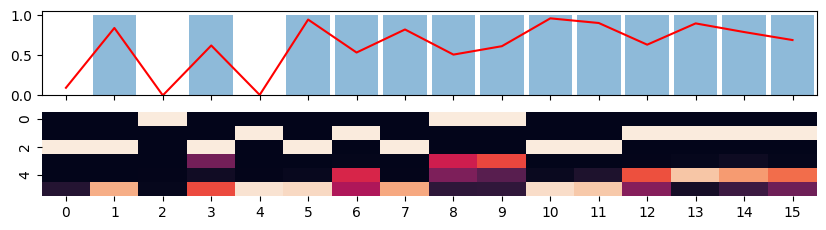

 Ġjersey 0.0 {'Ġthe': 0.285, 'Ġto': 0.189, 'Ġhis': 0.041} 	 The jersey is Charles's. The beetle is Patricia's. The duck is Deborah's. Charles likes jersey *Ġjersey:63.687 Ġbeet:71.698 Ġduck:69.759
*Ġh 0.547 {'Ġh': 0.547, 'Ġm': 0.182, 'Ġthe': 0.048} 	 The mango is Susan's. The bus is Laura's. The hamburger is George's. George likes hamburger Ġm:74.855 Ġbus:70.958 *Ġh:75.957
 Ġbeer 0.201 {'Ġyellow': 0.514, 'Ġcostume': 0.219, 'Ġbeer': 0.201} 	 The costume is Jeff's. The beer is Lisa's. The yellow is Mark's. Lisa likes beer Ġcostume:75.916 *Ġbeer:75.833 Ġyellow:76.771
 Ġmeat 0.352 {'Ġfootball': 0.391, 'Ġmeat': 0.352, 'Ġap': 0.197} 	 The meat is Margaret's. The apricot is Steven's. The football is Jason's. Margaret likes meat *Ġmeat:76.747 Ġap:76.166 Ġfootball:76.851
 Ġmeat 0.227 {'Ġbeer': 0.376, 'Ġgoat': 0.332, 'Ġmeat': 0.227} 	 The goat is Kevin's. The beer is George's. The meat is Margaret's. Margaret likes meat Ġgoat:76.719 Ġbeer:76.844 *Ġmeat:76.341
*Ġfootball 0.995 {'Ġfootball': 0.995

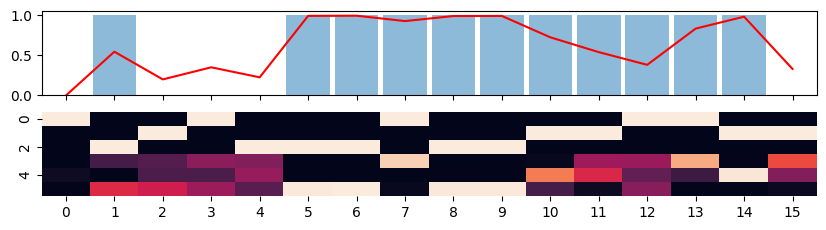

 Ġbaseball 0.078 {'Ġthe': 0.293, 'Ġto': 0.251, 'Ġbaseball': 0.078} 	 The baseball is Jason's. The white is Carol's. The purple is Lisa's. Jason likes baseball *Ġbaseball:73.540 Ġwhite:71.935 Ġpurple:72.657
*Ġpizza 0.822 {'Ġpizza': 0.822, 'Ġthe': 0.023, 'Ġto': 0.018} 	 The pizza is Thomas's. The gun is Helen's. The deer is Linda's. Thomas likes pizza *Ġpizza:76.763 Ġgun:71.328 Ġdeer:71.819
 Ġelephant 0.017 {'Ġbasketball': 0.545, 'Ġthe': 0.127, 'Ċ': 0.085} 	 The basketball is Jeff's. The costume is Christopher's. The elephant is Linda's. Linda likes elephant Ġbasketball:75.775 Ġcostume:73.632 *Ġelephant:72.332
*Ġblack 0.888 {'Ġblack': 0.888, 'Ġsoda': 0.073, 'Ġb': 0.005} 	 The soda is Michelle's. The black is Joseph's. The blackberry is Donna's. Joseph likes black Ġsoda:75.966 *Ġblack:78.466 *Ġblack:78.466
 Ġlaptop 0.088 {'Ġjeans': 0.67, 'Ġblue': 0.13, 'Ġlaptop': 0.088} 	 The blue is Anthony's. The laptop is Betty's. The jeans is Donald's. Betty likes laptop Ġblue:74.755 *Ġlaptop:74.367 Ġ

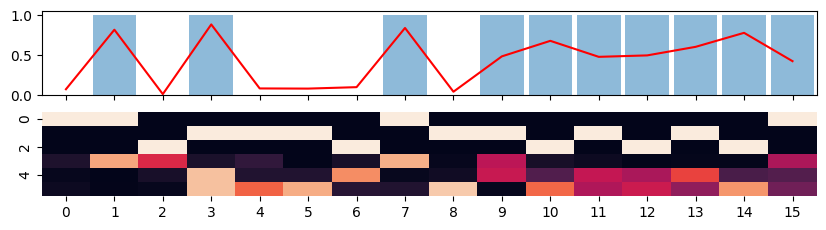

 Ġbeet 0.115 {'Ġto': 0.353, 'Ġthe': 0.148, 'Ġbeet': 0.115} 	 The basketball is Sharon's. The green is Nancy's. The beetle is Christopher's. Christopher likes beetle Ġbasketball:69.892 Ġgreen:70.897 *Ġbeet:73.576
*Ġrifle 0.837 {'Ġrifle': 0.837, 'Ġthe': 0.05, 'Ġgun': 0.02} 	 The iPad is Christopher's. The burger is James's. The rifle is Sarah's. Sarah likes rifle ĠiPad:68.004 Ġburger:71.408 *Ġrifle:76.347
 Ġpurple 0.096 {'Ġguitar': 0.715, 'Ġpurple': 0.096, 'ĠJe': 0.049} 	 The purple is Barbara's. The Jeep is Joseph's. The guitar is Mark's. Barbara likes purple *Ġpurple:74.490 ĠJe:73.822 Ġguitar:76.496
 Ġburger 0.381 {'Ġbasketball': 0.518, 'Ġburger': 0.381, 'Ġthe': 0.023} 	 The grapes is Kenneth's. The burger is Donna's. The basketball is Anthony's. Donna likes burger Ġgrapes:71.862 *Ġburger:76.043 Ġbasketball:76.350
 Ġbus 0.249 {'Ġphone': 0.497, 'Ġbus': 0.249, 'Ġmosquito': 0.175} 	 The bus is Richard's. The phone is Maria's. The mosquito is Sharon's. Richard likes bus *Ġbus:76.115 Ġphone

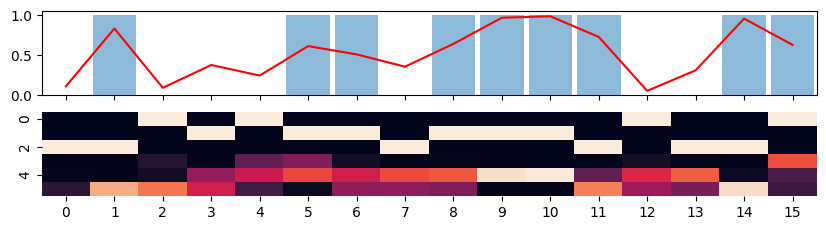

 Ġtaxi 0.008 {'Ġto': 0.341, 'Ġthe': 0.147, 'Ġtax': 0.06} 	 The beetle is Mark's. The cat is Joseph's. The taxi is Donna's. Donna likes taxi Ġbeet:70.273 Ġcat:68.084 *Ġtaxi:70.353
*Ġplum 0.646 {'Ġplum': 0.646, 'Ġpl': 0.183, 'Ċ': 0.037} 	 The laptop is James's. The costume is Kenneth's. The plum is Kimberly's. Kimberly likes plum Ġlaptop:67.097 Ġcostume:70.396 *Ġplum:76.103
 Ġmotorcycle 0.007 {'Ġtrousers': 0.818, 'Ġthe': 0.039, 'Ġtrous': 0.027} 	 The steak is Patricia's. The motorcycle is Jeff's. The trousers is Deborah's. Jeff likes motorcycle Ġsteak:67.239 *Ġmotorcycle:70.026 Ġtrousers:74.833
*Ġbus 0.567 {'Ġbus': 0.567, 'Ġbread': 0.326, 'Ġcoffee': 0.027} 	 The coffee is Christopher's. The bus is Elizabeth's. The bread is Michael's. Elizabeth likes bus Ġcoffee:74.016 *Ġbus:77.072 Ġbread:76.519
 Ġbus 0.069 {'Ġburger': 0.876, 'Ġbus': 0.069, 'Ġburgers': 0.033} 	 The shoes is Carol's. The bus is Robert's. The burger is Helen's. Robert likes bus Ġshoes:71.093 *Ġbus:76.774 Ġburger:79.319
*Ġbl

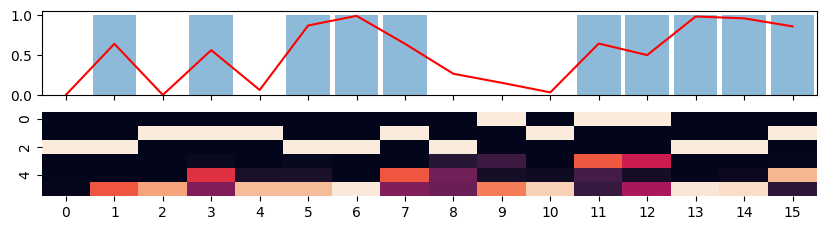

 Ġsmartphone 0.0 {'Ġthe': 0.248, 'Ġto': 0.22, 'Ġit': 0.042} 	 The smartphone is Michael's. The cat is Linda's. The shirt is Donna's. Michael likes smartphone *Ġsmartphone:64.917 Ġcat:67.113 Ġshirt:67.095
 Ġmotorcycle 0.167 {'ĠT': 0.273, 'Ġmotorcycle': 0.167, 'Ġsmartphone': 0.133} 	 The cow is Donald's. The T-shirt is Jeff's. The motorcycle is Elizabeth's. Elizabeth likes motorcycle Ġcow:71.814 ĠT:73.843 *Ġmotorcycle:73.355
 Ġmosquito 0.161 {'ĠT': 0.623, 'Ġmosquito': 0.161, 'Ġbasketball': 0.069} 	 The basketball is Brian's. The mosquito is Nancy's. The T-shirt is Christopher's. Nancy likes mosquito Ġbasketball:73.157 *Ġmosquito:74.007 ĠT:75.358
 Ġgoose 0.399 {'Ġpistol': 0.432, 'Ġgoose': 0.399, 'Ġplum': 0.121} 	 The goose is Patricia's. The plum is Anthony's. The pistol is Donald's. Patricia likes goose *Ġgoose:75.655 Ġplum:74.463 Ġpistol:75.734
 Ġshoes 0.03 {'Ġpurple': 0.673, 'Ġfootball': 0.287, 'Ġshoes': 0.03} 	 The purple is Ronald's. The football is Daniel's. The shoes is Carol's. Ca

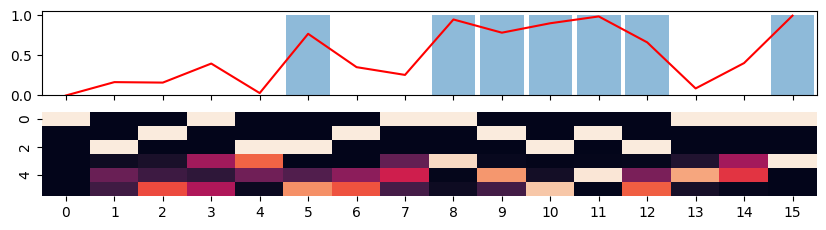

 Ġfootball 0.021 {'Ġthe': 0.347, 'Ġto': 0.273, 'Ġher': 0.036} 	 The football is Elizabeth's. The shotgun is Charles's. The lion is George's. Elizabeth likes football *Ġfootball:71.949 Ġshotgun:66.652 Ġlion:68.499
 Ġbus 0.015 {'Ġbread': 0.638, 'Ġthe': 0.097, 'Ġfootball': 0.088} 	 The trousers is Lisa's. The bread is Elizabeth's. The bus is William's. William likes bus Ġtrousers:71.545 Ġbread:75.930 *Ġbus:72.197
*Ġgrapes 0.911 {'Ġgrapes': 0.911, 'Ġh': 0.054, 'Ġgrape': 0.011} 	 The trousers is Barbara's. The hamburger is Laura's. The grapes is David's. David likes grapes Ġtrousers:67.343 Ġh:75.939 *Ġgrapes:78.771
 Ġguitar 0.104 {'Ġmosquito': 0.518, 'Ġmosquitoes': 0.24, 'Ġguitar': 0.104} 	 The meat is Thomas's. The guitar is Susan's. The mosquito is Brian's. Susan likes guitar Ġmeat:68.408 *Ġguitar:73.579 Ġmosquito:75.187
 Ġsmartphone 0.139 {'Ġpap': 0.647, 'Ġsmartphone': 0.139, 'Ġcow': 0.063} 	 The smartphone is Elizabeth's. The papaya is George's. The cow is Michael's. Elizabeth likes sma

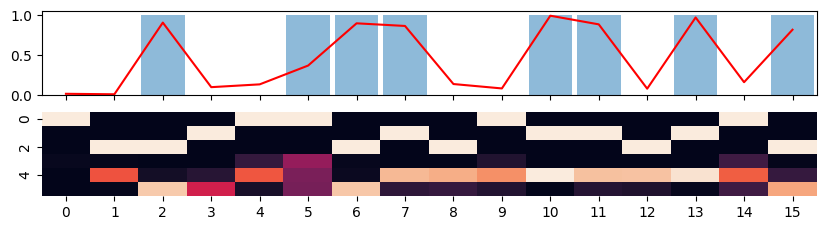

 Ġpink 0.018 {'Ġher': 0.146, 'Ġthe': 0.142, 'Ġto': 0.142} 	 The burger is Daniel's. The pink is Sarah's. The meat is Steven's. Sarah likes pink Ġburger:67.836 *Ġpink:71.525 Ġmeat:71.070
 Ġrev 0.085 {'Ġsquir': 0.334, 'Ġpink': 0.096, 'Ġrev': 0.085} 	 The laptop is Thomas's. The revolver is Carol's. The squirrel is Robert's. Carol likes revolver Ġlaptop:67.176 *Ġrev:73.355 Ġsquir:74.724
*Ġblue 0.513 {'Ġblue': 0.513, 'Ġjersey': 0.287, 'Ġdeer': 0.117} 	 The jersey is Carol's. The deer is Lisa's. The blueberries is Christopher's. Christopher likes blueberries Ġjersey:75.564 Ġdeer:74.671 *Ġblue:76.146
 Ġbee 0.009 {'Ġwaterm': 0.95, 'Ġhorse': 0.019, 'Ġbee': 0.009} 	 The bee is Steven's. The horse is Susan's. The watermelon is Dorothy's. Steven likes bee *Ġbee:74.272 Ġhorse:74.970 Ġwaterm:78.901
 Ġbread 0.243 {'Ġyellow': 0.716, 'Ġbread': 0.243, 'Ġunderwear': 0.012} 	 The underwear is Edward's. The yellow is Joseph's. The bread is Sandra's. Sandra likes bread Ġunderwear:73.716 Ġyellow:77.786 *Ġbr

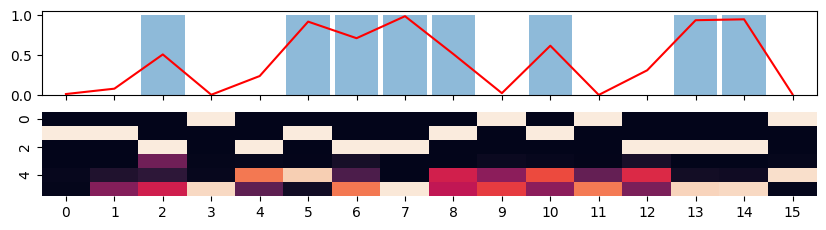

(0.7978888042271137, 0.7361111111111112)

In [38]:
show_predictions_by_data_tuples(model, tokenizer, r.data_tuples, k_shot)  # cpu

 Ġmeat 0.121 {'Ġthe': 0.309, 'Ġmeat': 0.121, 'Ġto': 0.089} 	 The fox is Sharon's. The piano is Donna's. The meat is James's. James likes meat Ġfox:69.312 Ġpiano:68.938 *Ġmeat:72.750
*Ġmeat 0.837 {'Ġmeat': 0.837, 'Ġsteak': 0.014, 'Ġto': 0.013} 	 The purple is James's. The jeans is Christopher's. The meat is Jennifer's. Jennifer likes meat Ġpurple:71.250 Ġjeans:69.375 *Ġmeat:76.750
 Ġgun 0.027 {'Ġguns': 0.273, 'Ġthe': 0.137, 'Ġmice': 0.121} 	 The gun is Nancy's. The phone is Edward's. The mouse is Kevin's. Nancy likes gun *Ġgun:71.688 Ġphone:70.688 Ġmouse:71.312
 Ġblack 0.393 {'Ġjuice': 0.572, 'Ġblack': 0.393, 'Ġpig': 0.013} 	 The juice is Jeff's. The pig is Richard's. The black is Michelle's. Michelle likes black Ġjuice:78.438 Ġpig:74.688 *Ġblack:78.062
 Ġviolin 0.046 {'Ġred': 0.934, 'Ġviolin': 0.046, 'Ġblack': 0.008} 	 The wolf is David's. The violin is Kimberly's. The red is Kenneth's. Kimberly likes violin Ġwolf:73.312 *Ġviolin:76.062 Ġred:79.062
*ĠiPad 0.9 {'ĠiPad': 0.9, 'Ġgoat': 0.

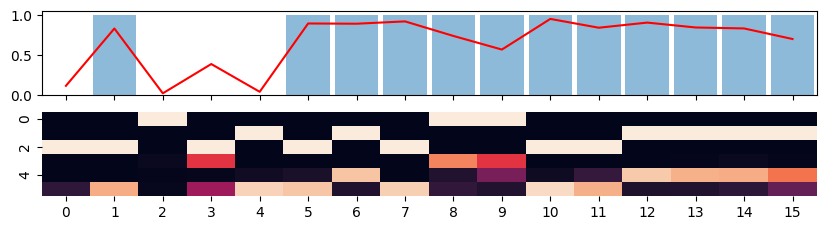

 Ġjersey 0.0 {'Ġthe': 0.407, 'Ġto': 0.11, 'Ġhis': 0.012} 	 The jersey is Charles's. The beetle is Patricia's. The duck is Deborah's. Charles likes jersey *Ġjersey:64.812 Ġbeet:69.812 Ġduck:68.938
*Ġh 0.3 {'Ġh': 0.3, 'Ġm': 0.281, 'Ġburger': 0.041} 	 The mango is Susan's. The bus is Laura's. The hamburger is George's. George likes hamburger Ġm:74.688 Ġbus:70.250 *Ġh:74.750
 Ġbeer 0.217 {'Ġyellow': 0.49, 'Ġbeer': 0.217, 'Ġcostume': 0.159} 	 The costume is Jeff's. The beer is Lisa's. The yellow is Mark's. Lisa likes beer Ġcostume:74.812 *Ġbeer:75.125 Ġyellow:75.938
 Ġmeat 0.361 {'Ġap': 0.596, 'Ġmeat': 0.361, 'Ġfootball': 0.005} 	 The meat is Margaret's. The apricot is Steven's. The football is Jason's. Margaret likes meat *Ġmeat:77.438 Ġap:77.938 Ġfootball:73.250
 Ġmeat 0.235 {'Ġgoat': 0.342, 'Ġbeer': 0.302, 'Ġmeat': 0.235} 	 The goat is Kevin's. The beer is George's. The meat is Margaret's. Margaret likes meat Ġgoat:76.562 Ġbeer:76.438 *Ġmeat:76.188
*Ġfootball 0.979 {'Ġfootball': 0.979, '

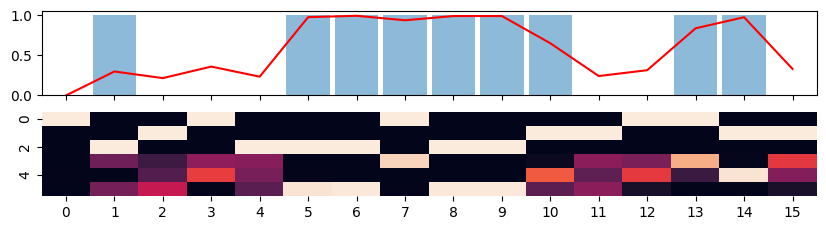

 Ġbaseball 0.238 {'Ġthe': 0.418, 'Ġbaseball': 0.238, 'Ġto': 0.05} 	 The baseball is Jason's. The white is Carol's. The purple is Lisa's. Jason likes baseball *Ġbaseball:74.000 Ġwhite:70.438 Ġpurple:71.188
*Ġpizza 0.886 {'Ġpizza': 0.886, 'Ġp': 0.017, 'Ġto': 0.013} 	 The pizza is Thomas's. The gun is Helen's. The deer is Linda's. Thomas likes pizza *Ġpizza:77.312 Ġgun:70.812 Ġdeer:70.875
 Ġelephant 0.01 {'Ġbasketball': 0.769, 'Ġcostume': 0.086, 'Ġthe': 0.056} 	 The basketball is Jeff's. The costume is Christopher's. The elephant is Linda's. Linda likes elephant Ġbasketball:76.812 Ġcostume:74.625 *Ġelephant:72.438
*Ġblack 0.669 {'Ġblack': 0.669, 'Ġsoda': 0.262, 'Ġbasketball': 0.013} 	 The soda is Michelle's. The black is Joseph's. The blackberry is Donna's. Joseph likes black Ġsoda:76.438 *Ġblack:77.375 *Ġblack:77.375
 Ġlaptop 0.351 {'Ġjeans': 0.423, 'Ġlaptop': 0.351, 'Ġblue': 0.137} 	 The blue is Anthony's. The laptop is Betty's. The jeans is Donald's. Betty likes laptop Ġblue:74.438 *Ġl

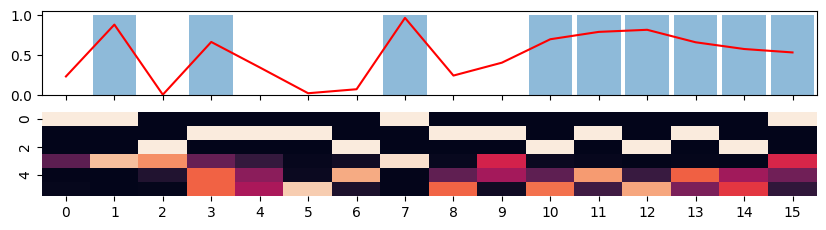

 Ġbeet 0.06 {'Ġthe': 0.326, 'Ġto': 0.186, 'Ġbeet': 0.06} 	 The basketball is Sharon's. The green is Nancy's. The beetle is Christopher's. Christopher likes beetle Ġbasketball:71.188 Ġgreen:71.312 *Ġbeet:72.188
*Ġrifle 0.92 {'Ġrifle': 0.92, 'Ġthe': 0.026, 'Ġgun': 0.007} 	 The iPad is Christopher's. The burger is James's. The rifle is Sarah's. Sarah likes rifle ĠiPad:68.938 Ġburger:70.688 *Ġrifle:76.938
 Ġpurple 0.047 {'Ġguitar': 0.833, 'Ġpurple': 0.047, 'Ġthe': 0.034} 	 The purple is Barbara's. The Jeep is Joseph's. The guitar is Mark's. Barbara likes purple *Ġpurple:73.938 ĠJe:73.125 Ġguitar:76.812
 Ġburger 0.061 {'Ġbasketball': 0.89, 'Ġburger': 0.061, 'Ġthe': 0.012} 	 The grapes is Kenneth's. The burger is Donna's. The basketball is Anthony's. Donna likes burger Ġgrapes:72.250 *Ġburger:75.188 Ġbasketball:77.875
*Ġbus 0.456 {'Ġbus': 0.456, 'Ġphone': 0.26, 'Ġmosquito': 0.179} 	 The bus is Richard's. The phone is Maria's. The mosquito is Sharon's. Richard likes bus *Ġbus:76.125 Ġphone:75

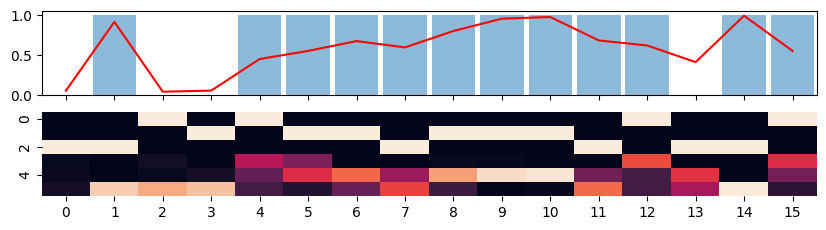

 Ġtaxi 0.014 {'Ġthe': 0.436, 'Ġto': 0.117, 'Ġher': 0.041} 	 The beetle is Mark's. The cat is Joseph's. The taxi is Donna's. Donna likes taxi Ġbeet:70.562 Ġcat:68.500 *Ġtaxi:70.812
*Ġplum 0.817 {'Ġplum': 0.817, 'Ġpl': 0.071, 'Ġcostume': 0.02} 	 The laptop is James's. The costume is Kenneth's. The plum is Kimberly's. Kimberly likes plum Ġlaptop:69.750 Ġcostume:72.500 *Ġplum:76.188
 Ġmotorcycle 0.049 {'Ġtrousers': 0.821, 'Ġmotorcycle': 0.049, 'Ġthe': 0.025} 	 The steak is Patricia's. The motorcycle is Jeff's. The trousers is Deborah's. Jeff likes motorcycle Ġsteak:68.062 *Ġmotorcycle:71.438 Ġtrousers:74.250
 Ġbus 0.416 {'Ġbread': 0.502, 'Ġbus': 0.416, 'Ġcoffee': 0.036} 	 The coffee is Christopher's. The bus is Elizabeth's. The bread is Michael's. Elizabeth likes bus Ġcoffee:74.438 *Ġbus:76.875 Ġbread:77.062
 Ġbus 0.007 {'Ġburger': 0.976, 'Ġburgers': 0.01, 'Ġbus': 0.007} 	 The shoes is Carol's. The bus is Robert's. The burger is Helen's. Robert likes bus Ġshoes:70.812 *Ġbus:75.562 Ġburger:

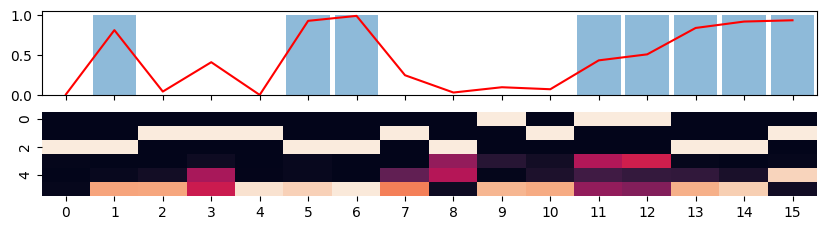

 Ġsmartphone 0.003 {'Ġthe': 0.347, 'Ġto': 0.077, 'ĠLinda': 0.057} 	 The smartphone is Michael's. The cat is Linda's. The shirt is Donna's. Michael likes smartphone *Ġsmartphone:68.438 Ġcat:66.500 Ġshirt:66.875
*Ġmotorcycle 0.296 {'Ġmotorcycle': 0.296, 'ĠT': 0.168, 'Ġthe': 0.08} 	 The cow is Donald's. The T-shirt is Jeff's. The motorcycle is Elizabeth's. Elizabeth likes motorcycle Ġcow:72.188 ĠT:73.125 *Ġmotorcycle:73.688
*Ġmosquito 0.685 {'Ġmosquito': 0.685, 'Ġbasketball': 0.099, 'ĠT': 0.06} 	 The basketball is Brian's. The mosquito is Nancy's. The T-shirt is Christopher's. Nancy likes mosquito Ġbasketball:73.312 *Ġmosquito:75.250 ĠT:72.812
*Ġgoose 0.572 {'Ġgoose': 0.572, 'Ġpistol': 0.27, 'Ġplum': 0.113} 	 The goose is Patricia's. The plum is Anthony's. The pistol is Donald's. Patricia likes goose *Ġgoose:76.000 Ġplum:74.375 Ġpistol:75.250
 Ġshoes 0.03 {'Ġpurple': 0.721, 'Ġfootball': 0.234, 'Ġshoes': 0.03} 	 The purple is Ronald's. The football is Daniel's. The shoes is Carol's. Carol 

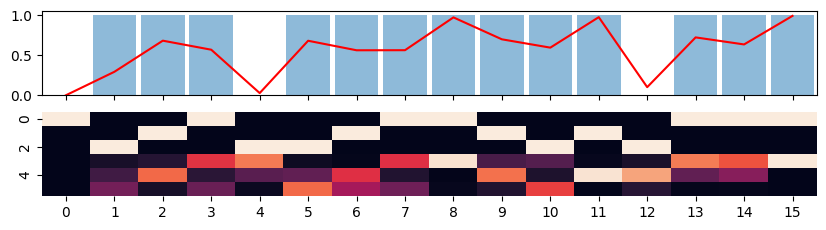

 Ġfootball 0.259 {'Ġthe': 0.294, 'Ġfootball': 0.259, 'Ġto': 0.115} 	 The football is Elizabeth's. The shotgun is Charles's. The lion is George's. Elizabeth likes football *Ġfootball:73.688 Ġshotgun:67.688 Ġlion:68.062
 Ġbus 0.008 {'Ġbread': 0.757, 'Ġthe': 0.055, 'Ġfootball': 0.035} 	 The trousers is Lisa's. The bread is Elizabeth's. The bus is William's. William likes bus Ġtrousers:71.375 Ġbread:75.875 *Ġbus:71.312
*Ġgrapes 0.96 {'Ġgrapes': 0.96, 'Ġgrape': 0.011, 'Ġh': 0.009} 	 The trousers is Barbara's. The hamburger is Laura's. The grapes is David's. David likes grapes Ġtrousers:67.188 Ġh:74.188 *Ġgrapes:78.812
*Ġguitar 0.336 {'Ġguitar': 0.336, 'Ġmosquito': 0.316, 'Ġmosquitoes': 0.103} 	 The meat is Thomas's. The guitar is Susan's. The mosquito is Brian's. Susan likes guitar Ġmeat:69.312 *Ġguitar:74.250 Ġmosquito:74.188
 Ġsmartphone 0.053 {'Ġpap': 0.64, 'Ġsmartphone': 0.053, 'Ġcow': 0.038} 	 The smartphone is Elizabeth's. The papaya is George's. The cow is Michael's. Elizabeth likes 

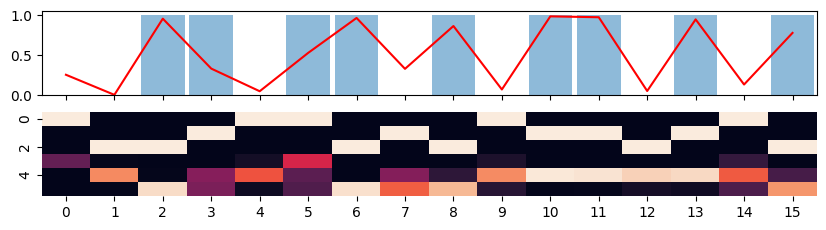

 Ġpink 0.013 {'Ġthe': 0.305, 'Ġto': 0.064, 'Ġit': 0.053} 	 The burger is Daniel's. The pink is Sarah's. The meat is Steven's. Sarah likes pink Ġburger:69.438 *Ġpink:71.000 Ġmeat:71.938
*Ġrev 0.444 {'Ġrev': 0.444, 'Ġpink': 0.112, 'Ġsquir': 0.099} 	 The laptop is Thomas's. The revolver is Carol's. The squirrel is Robert's. Carol likes revolver Ġlaptop:70.125 *Ġrev:75.062 Ġsquir:73.562
*Ġblue 0.789 {'Ġblue': 0.789, 'Ġjersey': 0.094, 'Ġdeer': 0.057} 	 The jersey is Carol's. The deer is Lisa's. The blueberries is Christopher's. Christopher likes blueberries Ġjersey:75.500 Ġdeer:75.000 *Ġblue:77.625
 Ġbee 0.051 {'Ġwaterm': 0.854, 'Ġbee': 0.051, 'Ġhorse': 0.038} 	 The bee is Steven's. The horse is Susan's. The watermelon is Dorothy's. Steven likes bee *Ġbee:75.688 Ġhorse:75.375 Ġwaterm:78.500
 Ġbread 0.226 {'Ġyellow': 0.741, 'Ġbread': 0.226, 'Ġunderwear': 0.004} 	 The underwear is Edward's. The yellow is Joseph's. The bread is Sandra's. Sandra likes bread Ġunderwear:72.875 Ġyellow:78.000 *Ġbr

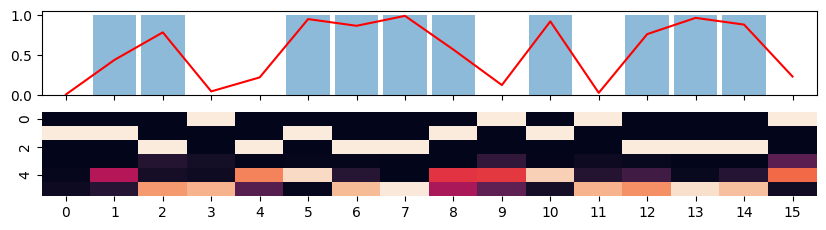

(0.6506555993109941, 0.75)

In [36]:
show_predictions_by_data_tuples(model, tokenizer, r.data_tuples, k_shot)  # gpu custom

 Ġmeat 0.12 {'Ġthe': 0.306, 'Ġmeat': 0.12, 'Ġto': 0.093} 	 The fox is Sharon's. The piano is Donna's. The meat is James's. James likes meat Ġfox:69.188 Ġpiano:68.750 *Ġmeat:72.750
*Ġmeat 0.834 {'Ġmeat': 0.834, 'Ġsteak': 0.013, 'Ġto': 0.013} 	 The purple is James's. The jeans is Christopher's. The meat is Jennifer's. Jennifer likes meat Ġpurple:71.500 Ġjeans:69.438 *Ġmeat:76.625
 Ġgun 0.031 {'Ġguns': 0.316, 'Ġmice': 0.132, 'Ġthe': 0.124} 	 The gun is Nancy's. The phone is Edward's. The mouse is Kevin's. Nancy likes gun *Ġgun:71.938 Ġphone:70.625 Ġmouse:71.438
 Ġblack 0.436 {'Ġjuice': 0.526, 'Ġblack': 0.436, 'Ġpig': 0.014} 	 The juice is Jeff's. The pig is Richard's. The black is Michelle's. Michelle likes black Ġjuice:78.312 Ġpig:74.688 *Ġblack:78.125
 Ġviolin 0.014 {'Ġred': 0.971, 'Ġviolin': 0.014, 'Ġblack': 0.006} 	 The wolf is David's. The violin is Kimberly's. The red is Kenneth's. Kimberly likes violin Ġwolf:72.938 *Ġviolin:75.250 Ġred:79.500
*ĠiPad 0.883 {'ĠiPad': 0.883, 'Ġgoat': 

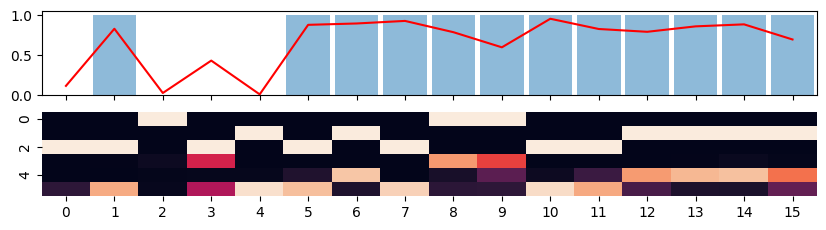

 Ġjersey 0.0 {'Ġthe': 0.407, 'Ġto': 0.11, 'Ġhis': 0.015} 	 The jersey is Charles's. The beetle is Patricia's. The duck is Deborah's. Charles likes jersey *Ġjersey:65.000 Ġbeet:69.562 Ġduck:69.125
*Ġh 0.276 {'Ġh': 0.276, 'Ġm': 0.243, 'Ġburger': 0.04} 	 The mango is Susan's. The bus is Laura's. The hamburger is George's. George likes hamburger Ġm:74.375 Ġbus:70.250 *Ġh:74.500
 Ġbeer 0.233 {'Ġyellow': 0.493, 'Ġbeer': 0.233, 'Ġcostume': 0.15} 	 The costume is Jeff's. The beer is Lisa's. The yellow is Mark's. Lisa likes beer Ġcostume:74.812 *Ġbeer:75.250 Ġyellow:76.000
 Ġmeat 0.271 {'Ġap': 0.691, 'Ġmeat': 0.271, 'Ġfruit': 0.005} 	 The meat is Margaret's. The apricot is Steven's. The football is Jason's. Margaret likes meat *Ġmeat:77.188 Ġap:78.125 Ġfootball:73.000
 Ġmeat 0.214 {'Ġgoat': 0.353, 'Ġbeer': 0.275, 'Ġmeat': 0.214} 	 The goat is Kevin's. The beer is George's. The meat is Margaret's. Margaret likes meat Ġgoat:76.500 Ġbeer:76.250 *Ġmeat:76.000
*Ġfootball 0.972 {'Ġfootball': 0.972, '

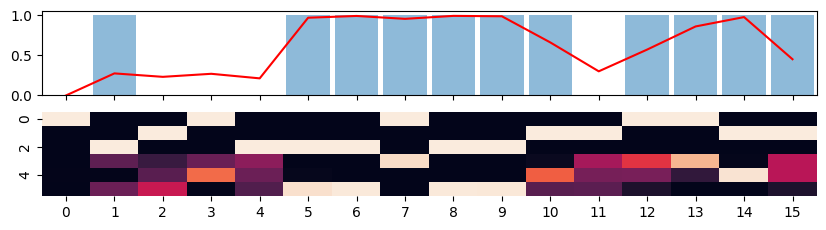

 Ġbaseball 0.235 {'Ġthe': 0.439, 'Ġbaseball': 0.235, 'Ġto': 0.046} 	 The baseball is Jason's. The white is Carol's. The purple is Lisa's. Jason likes baseball *Ġbaseball:73.938 Ġwhite:70.000 Ġpurple:70.625
*Ġpizza 0.877 {'Ġpizza': 0.877, 'Ġp': 0.018, 'Ġto': 0.013} 	 The pizza is Thomas's. The gun is Helen's. The deer is Linda's. Thomas likes pizza *Ġpizza:77.312 Ġgun:70.875 Ġdeer:70.875
 Ġelephant 0.008 {'Ġbasketball': 0.693, 'Ġcostume': 0.145, 'Ġthe': 0.078} 	 The basketball is Jeff's. The costume is Christopher's. The elephant is Linda's. Linda likes elephant Ġbasketball:76.812 Ġcostume:75.250 *Ġelephant:72.312
*Ġblack 0.636 {'Ġblack': 0.636, 'Ġsoda': 0.301, 'Ġbasketball': 0.009} 	 The soda is Michelle's. The black is Joseph's. The blackberry is Donna's. Joseph likes black Ġsoda:76.625 *Ġblack:77.375 *Ġblack:77.375
 Ġlaptop 0.258 {'Ġjeans': 0.514, 'Ġlaptop': 0.258, 'Ġblue': 0.138} 	 The blue is Anthony's. The laptop is Betty's. The jeans is Donald's. Betty likes laptop Ġblue:74.375 *

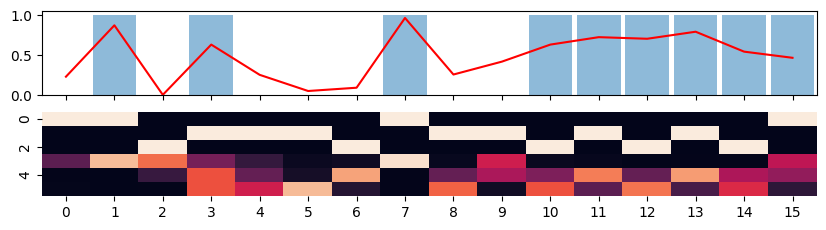

 Ġbeet 0.056 {'Ġthe': 0.323, 'Ġto': 0.184, 'Ġbeet': 0.056} 	 The basketball is Sharon's. The green is Nancy's. The beetle is Christopher's. Christopher likes beetle Ġbasketball:71.250 Ġgreen:71.250 *Ġbeet:72.125
*Ġrifle 0.918 {'Ġrifle': 0.918, 'Ġthe': 0.026, 'Ġgun': 0.008} 	 The iPad is Christopher's. The burger is James's. The rifle is Sarah's. Sarah likes rifle ĠiPad:68.750 Ġburger:70.688 *Ġrifle:76.938
 Ġpurple 0.073 {'Ġguitar': 0.789, 'Ġpurple': 0.073, 'Ġthe': 0.039} 	 The purple is Barbara's. The Jeep is Joseph's. The guitar is Mark's. Barbara likes purple *Ġpurple:74.375 ĠJe:73.500 Ġguitar:76.750
 Ġburger 0.034 {'Ġbasketball': 0.932, 'Ġburger': 0.034, 'Ġthe': 0.007} 	 The grapes is Kenneth's. The burger is Donna's. The basketball is Anthony's. Donna likes burger Ġgrapes:71.562 *Ġburger:75.000 Ġbasketball:78.312
*Ġbus 0.493 {'Ġbus': 0.493, 'Ġphone': 0.264, 'Ġmosquito': 0.15} 	 The bus is Richard's. The phone is Maria's. The mosquito is Sharon's. Richard likes bus *Ġbus:76.375 Ġpho

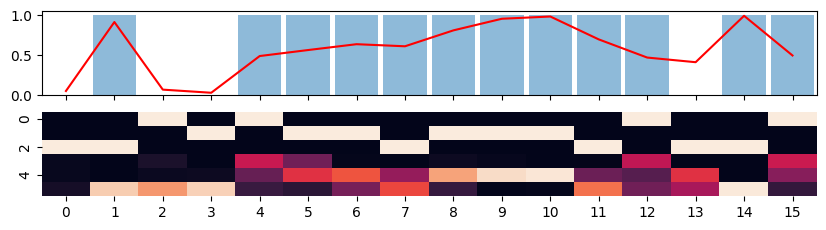

 Ġtaxi 0.016 {'Ġthe': 0.458, 'Ġto': 0.116, 'ĠMark': 0.043} 	 The beetle is Mark's. The cat is Joseph's. The taxi is Donna's. Donna likes taxi Ġbeet:70.750 Ġcat:68.375 *Ġtaxi:71.000
*Ġplum 0.803 {'Ġplum': 0.803, 'Ġpl': 0.08, 'Ġcostume': 0.021} 	 The laptop is James's. The costume is Kenneth's. The plum is Kimberly's. Kimberly likes plum Ġlaptop:70.000 Ġcostume:72.562 *Ġplum:76.188
 Ġmotorcycle 0.027 {'Ġtrousers': 0.852, 'Ġmotorcycle': 0.027, 'Ġthe': 0.026} 	 The steak is Patricia's. The motorcycle is Jeff's. The trousers is Deborah's. Jeff likes motorcycle Ġsteak:68.438 *Ġmotorcycle:70.938 Ġtrousers:74.375
*Ġbus 0.532 {'Ġbus': 0.532, 'Ġbread': 0.389, 'Ġcoffee': 0.034} 	 The coffee is Christopher's. The bus is Elizabeth's. The bread is Michael's. Elizabeth likes bus Ġcoffee:74.375 *Ġbus:77.125 Ġbread:76.812
 Ġbus 0.021 {'Ġburger': 0.957, 'Ġbus': 0.021, 'Ġburgers': 0.014} 	 The shoes is Carol's. The bus is Robert's. The burger is Helen's. Robert likes bus Ġshoes:71.000 *Ġbus:76.750 Ġburge

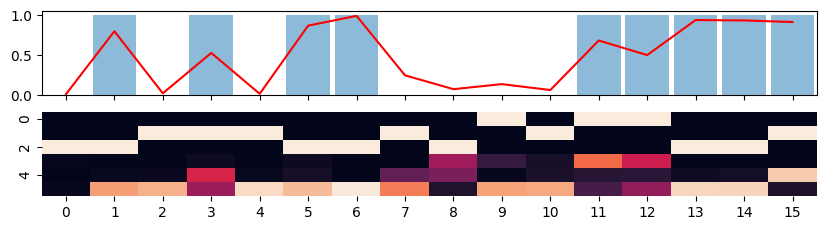

 Ġsmartphone 0.003 {'Ġthe': 0.331, 'Ġto': 0.079, 'ĠLinda': 0.065} 	 The smartphone is Michael's. The cat is Linda's. The shirt is Donna's. Michael likes smartphone *Ġsmartphone:68.312 Ġcat:66.688 Ġshirt:67.000
*Ġmotorcycle 0.278 {'Ġmotorcycle': 0.278, 'ĠT': 0.191, 'Ġthe': 0.08} 	 The cow is Donald's. The T-shirt is Jeff's. The motorcycle is Elizabeth's. Elizabeth likes motorcycle Ġcow:72.125 ĠT:73.250 *Ġmotorcycle:73.625
*Ġmosquito 0.566 {'Ġmosquito': 0.566, 'Ġbasketball': 0.112, 'ĠT': 0.098} 	 The basketball is Brian's. The mosquito is Nancy's. The T-shirt is Christopher's. Nancy likes mosquito Ġbasketball:73.250 *Ġmosquito:74.875 ĠT:73.125
 Ġgoose 0.421 {'Ġgoose': 0.421, 'Ġpistol': 0.421, 'Ġplum': 0.113} 	 The goose is Patricia's. The plum is Anthony's. The pistol is Donald's. Patricia likes goose *Ġgoose:75.750 Ġplum:74.438 Ġpistol:75.750
 Ġshoes 0.04 {'Ġpurple': 0.666, 'Ġfootball': 0.278, 'Ġshoes': 0.04} 	 The purple is Ronald's. The football is Daniel's. The shoes is Carol's. Caro

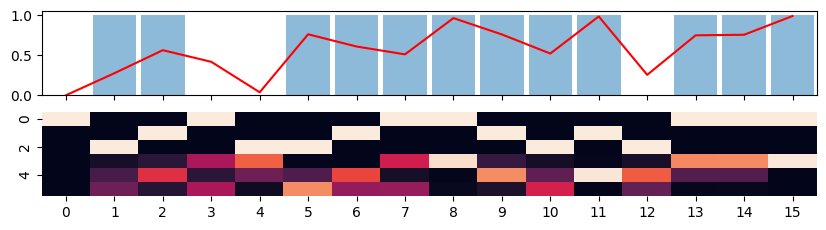

 Ġfootball 0.267 {'Ġthe': 0.284, 'Ġfootball': 0.267, 'Ġto': 0.118} 	 The football is Elizabeth's. The shotgun is Charles's. The lion is George's. Elizabeth likes football *Ġfootball:73.625 Ġshotgun:67.438 Ġlion:67.438
 Ġbus 0.008 {'Ġbread': 0.729, 'Ġthe': 0.064, 'Ġfootball': 0.034} 	 The trousers is Lisa's. The bread is Elizabeth's. The bus is William's. William likes bus Ġtrousers:71.062 Ġbread:75.688 *Ġbus:71.125
*Ġgrapes 0.958 {'Ġgrapes': 0.958, 'Ġgrape': 0.01, 'Ġh': 0.009} 	 The trousers is Barbara's. The hamburger is Laura's. The grapes is David's. David likes grapes Ġtrousers:67.312 Ġh:73.938 *Ġgrapes:78.625
 Ġguitar 0.249 {'Ġmosquito': 0.385, 'Ġguitar': 0.249, 'Ġmosquitoes': 0.117} 	 The meat is Thomas's. The guitar is Susan's. The mosquito is Brian's. Susan likes guitar Ġmeat:69.250 *Ġguitar:73.938 Ġmosquito:74.375
 Ġsmartphone 0.085 {'Ġpap': 0.631, 'Ġsmartphone': 0.085, 'Ġcow': 0.043} 	 The smartphone is Elizabeth's. The papaya is George's. The cow is Michael's. Elizabeth like

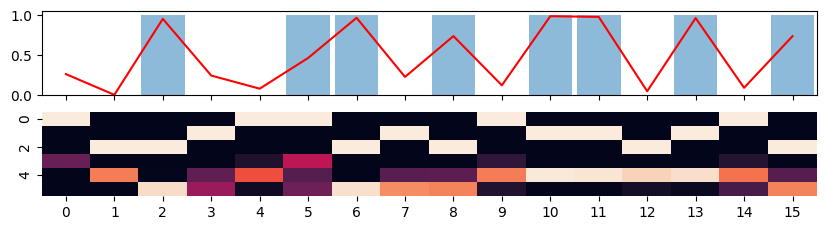

 Ġpink 0.013 {'Ġthe': 0.3, 'Ġto': 0.063, 'Ġit': 0.052} 	 The burger is Daniel's. The pink is Sarah's. The meat is Steven's. Sarah likes pink Ġburger:69.375 *Ġpink:71.000 Ġmeat:72.000
*Ġrev 0.396 {'Ġrev': 0.396, 'Ġpink': 0.146, 'Ġsquir': 0.094} 	 The laptop is Thomas's. The revolver is Carol's. The squirrel is Robert's. Carol likes revolver Ġlaptop:69.750 *Ġrev:75.000 Ġsquir:73.562
*Ġblue 0.792 {'Ġblue': 0.792, 'Ġjersey': 0.083, 'Ġdeer': 0.061} 	 The jersey is Carol's. The deer is Lisa's. The blueberries is Christopher's. Christopher likes blueberries Ġjersey:75.375 Ġdeer:75.062 *Ġblue:77.625
 Ġbee 0.031 {'Ġwaterm': 0.894, 'Ġbee': 0.031, 'Ġhorse': 0.027} 	 The bee is Steven's. The horse is Susan's. The watermelon is Dorothy's. Steven likes bee *Ġbee:75.250 Ġhorse:75.125 Ġwaterm:78.625
 Ġbread 0.236 {'Ġyellow': 0.728, 'Ġbread': 0.236, 'Ġunderwear': 0.005} 	 The underwear is Edward's. The yellow is Joseph's. The bread is Sandra's. Sandra likes bread Ġunderwear:72.812 Ġyellow:77.812 *Ġbrea

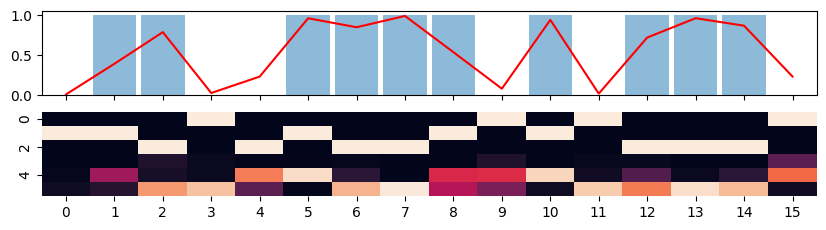

(0.626735083758831, 0.7777777777777778)

In [17]:
show_predictions_by_data_tuples(model, tokenizer, r.data_tuples, k_shot)  # gpu

In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.child(skip_inv_f), types_of_things.TreeSet.child(skip_inv_f)) (cxt_len=3)'
result = results[key]; print_tree(result.root)

In [29]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc:.3f}")

MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]: 0.296, 0.917
MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]: 1.237, 0.569
MlM_gen[types_of_things.TreeSet.equal,genders_of_persons.TreeSet.equal][cxt_len=3]: 1.466, 0.458
MlM_gen[types_of_things.TreeSet.equal,genders_of_persons.TreeSet.equal][cxt_len=3,rev_item2str]: 0.671, 0.722
MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal[x_f=_s,y_f=a_]][cxt_len=3]: 0.650, 0.833
MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal[x_f=_s,y_f=a_]][cxt_len=3,rev_item2str]: 1.830, 0.486
MlM_gen[types_of_things.TreeSet.equal[x_f=_s,y_f=a_],genders_of_persons.TreeSet.equal][cxt_len=3]: 1.263, 0.569
MlM_gen[types_of_things.TreeSet.equal[x_f=_s,y_f=a_],genders_of_persons.TreeSet.equal][cxt_len=3,rev_item2str]: 0.731, 0.708
MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.child[x_f=_s,y_f=a_]][cxt_len=3]: 2.357, 0.458


In [ ]:
key = 'MlM_gen(types_of_things.TreeSet.child, genders_of_persons.TreeSet.child) (cxt_len=3)'
result = results[key]; show_predictions_by_result(tokenizer, result, k_shot)

In [ ]:
nrows, k_shot = 16, 7; cxt_len=3; save_results = True
batch_size = 8; verbose = not save_results or batch_size <= 8
for task, replace_rel0, replace_rel1, do_swap_qa, do_negate, do_rm_local_hop, do_rm_query, rev_item2str in product(
    tasks[2:3], [0,  ], [0,     ],   [False,],[False,],[False,],[False,],[False,]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(replace_rel0=replace_rel0, replace_rel1=replace_rel1, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_local_hop=do_rm_local_hop, do_rm_query=do_rm_query)
    task = transform_task(task, **trans_args)
    if task is None: continue
    res_key = f"{task2str(task)} ({args2str(args)})" + composed_heads2str(model)
#     if not validate_args(task, args, trans_args): print('invalid args! skip.'); continue
#     if save_results and key is not None and res_key != key: continue
    if verbose: print(f'\n== {res_key} == {args2str(trans_args)}')
    if save_results and res_key in results:
        assert results[res_key].trans_args == trans_args, f'{res_key} {args2str(results[res_key].trans_args)} != {args2str(trans_args)}'
        result = results[res_key]; data_tuples = result.data_tuples
    else:
        all_examples, texts, all_bos_tokens = zip(*[generate(task, verbose=False, plot=False, nrows=nrows, **args)
                                                for i in range(batch_size)])
        result = Result(task, trans_args, args, all_examples, texts)
        for text in texts: print('\n'.join(text.split('\n')[:3]))

        data_tuples, eval_results = zip(*[predict(model, tokenizer, text, examples,
            k_shot=k_shot, bos_token=bos_tokens, verbose=verbose)
            for text, examples, bos_tokens in zip(texts, all_examples, all_bos_tokens)
            if True or any(s in text[24:] for s in ['dangerous'])])
        result.data_tuples = data_tuples
        loss, acc, *_ = zip(*eval_results)
        result.mean_loss, result.mean_acc = np.array(loss).mean(), np.array(join_lists(acc)).mean()
        if verbose: print(result.mean_loss, result.mean_acc)
        if save_results: results[res_key] = result
    if not save_results: continue

#     for node_name in ['node']:
#         node = getattr(result, node_name, None)
#         if node is None: node = result.node = result.root = add_node(node, label_type=node_name.replace('node', 'labels'))
#         node.data.attr = mr(attribute_step)(data_tuples[:], model, node)
#     node.data.scores = {ap: mr(get_head_matching_scores)(data_tuples, ap, k_shot=k_shot)
#         for ap in attn_patterns_by_step.get(node.data.step, [])} if 'g2c' not in res_key else None

In [146]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}") # codex

MlM_gen(genders_of_persons.TreeSet.child, types_of_things.TreeSet.equal) (cxt_len=3): 1.395, 0.5277777777777778
MlM_gen(genders_of_persons.TreeSet.child, nouns.things.wrap_noun.TreeSet.child) (cxt_len=3): 2.519, 0.4027777777777778
MlM_gen(genders_of_persons.TreeSet.child, things.TreeSet.equal) (cxt_len=3): 1.395, 0.5277777777777778
MlM_gen(genders_of_persons.TreeSet.child, things.TreeSet.child) (cxt_len=3): 1.395, 0.5277777777777778


In [18]:
device = torch.device('cuda:0')
_ = clone_model_to(model, device)
data_tuples_gpu = data_tuples_to(data_tuples, device)

In [31]:
print_tree(root)  # cpu

          ┌[0] @:6 24-10,21-13,22-5,19-15,21-14,19-m
          ├[0] 11-12 B->Q] argmax_attn┐
          │                           └[1] 8-1 B->A]
          │                           ┌[1] 11-12 B->Q]
          ├[0] 13-7 B->A0] argmax_attn┤
          │                           └[1] 12-10 B->A]
 [-1] root┤
          │                                  ┌[1] 11-12 B->Q]
          ├[0] @7 16-7 32% B->A0] argmax_attn┤
          │                                  ├[1] 12-10 B->A]
          │                                  └[1] 13-13 B->A]
          ├[0] @0 24-10 100% B->B argmax_attn
          └[0] @1 21-13 68% B->A0] argmax_attn


In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.child, types_of_things.TreeSet.equal) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=True)

In [ ]:
for data_tuple in data_tuples[:3]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 13, 7, attn_patterns=['bos->ans0]'], k_shot=0, plot_attr=False)

In [160]:
node = node.parent

In [164]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2,3,4])#layer=11, head=12, attn_pattern='bos->query]', label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.child, types_of_things.TreeSet.equal) (cxt_len=3)
Maria has gray. Dorothy has a cat. Christopher has a revolver. The boy likes revolver
                 ┌[0] 13-2 argmax_attn_labels┐
                 │                           └[1] top[0, 1] 12-10,8-1┐
                 │                                                   └[2] top[0] 1-7
 [-1] root labels┤
                 │                           ┌[1] top[0, 1, 2, 3] 11-12,12-10,9-14,9-5
                 ├[0] 13-7 argmax_attn_labels┤
                 │                           ├[1] top[2] 9-14┐
                 │                           │               └[2] top[0, 1] 8-7,6-2
                 │                           └[1] top[1] 12-10┐
                 │                                            └[2] top[0, 1] 8-7,0-mlp
                 │                            ┌[1] top[0, 1, 2] 0-mlp,9-14,8-1
                 └[0] 11-12 argmax_attn_labels┤
                                              └[

In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.child) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:3]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 13, 7, attn_patterns=['bos->ans0]'], k_shot=0, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=False)

In [112]:
node = result.root

In [117]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2])#, attn_pattern='bos->query]', label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.child) (cxt_len=3)
Nancy has blueberries. Mary has a wolf. Jennifer has wine. Mary likes animal
                 ┌[0] 11-12 argmax_attn_labels┐
                 │                            └*[1] top[0, 1, 2] 0-mlp,9-5,10-8...
                 │                                  ┌[1] top[0, 1, 2, 3, 4, 5, 6] 19-mlp,14-9,16-mlp,8-1,13-13,17-mlp,12-10
                 ├[0] top[2] 21-5 argmax_attn_labels┤
                 │                                  └[1] top[3, 4, 6] 8-1,13-13,12-10┐
                 │                                                                   └[2] top[0, 1] 3-12,5-12
 [-1] root labels┤
                 │                                  ┌[1] top[0, 1, 2, 3, 4, 5] 14-9,0-mlp,8-1,13-13,12-10,9-14
                 ├[0] top[3] 15-8 argmax_attn_labels┤
                 │                                  ├[1] top[2, 3, 4, 5] 8-1,13-13,12-10,9-14┐
                 │                                  │

In [367]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])#attn_pattern='bos->ans0]', label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.child) (cxt_len=3)
                 ┌[0] 11-12 argmax_attn_labels
 [-1] root labels┤
                 ├[0] 16-7 argmax_attn_labels┐
                 │                           └[1] top[0, 1] 13-13,12-10┐
                 │                                                     └*[2] top[0, 1, 2, 3, 4, 5] 0-mlp,10-4,12-mlp,6-2,7-9,10-mlp...
                 └[0] top[5] 13-7 argmax_attn_labels┐
                                                    └[1] top[1, 3] 12-10,8-1┐
                                                                            └[2] top[0] 3-12


In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.equal) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 11, 12, attn_patterns=['bos->query]'], k_shot=0, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1], k_shot=k_shot)

In [106]:
node = result.root

In [110]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2,3,4,5])#, label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.equal) (cxt_len=3)
Kimberly has a rabbit. Charles has white. Jason has a taxi. Kimberly likes rabbit
                 ┌[0] 11-12 argmax_attn_labels attr_k┐
                 │                                   └[1] top[0] 0-mlp
                 ├[0] 9-5 argmax_attn_labels┐
                 │                          └[1] top[0] 0-mlp
                 ├[0] 13-7 argmax_attn_labels┐
                 │                           └*[1] top[0, 1, 2, 3, 4, 5] 11-12,9-5,12-14,9-14,11-4,12-10...
 [-1] root labels┤
                 │                            ┌[1] top[0, 1, 2, 3] 8-1,0-mlp,9-14,9-5
                 ├[0] 11-12 argmax_attn_labels┤
                 │                            │              ┌[2] top[0, 1, 2, 3] 6-mlp,4-6,4-12,7-mlp
                 │                            └[1] top[0] 8-1┤
                 │                                           └[2] top[1] 4-6┐
                 │                             

In [345]:
print(key); node = result.node = add_node(node, topi=[0])#, attn_pattern='bos->query]', label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.equal) (cxt_len=3)
                 ┌[0] top[3] 16-7 argmax_attn_labels┐
                 │                                  └[1] top[0, 3, 4] 13-13,9-14,12-10┐
                 │                                                                    └[2] top[0, 1, 2] 8-7,6-2,1-7
                 ├[0] top[2] 16-0 argmax_attn_labels┐
                 │                                  └[1] top[0, 1, 2] 13-13,12-10,8-1┐
                 │                                                                   └[2] top[0, 1, 2, 3] 1-7,0-mlp,8-7,6-2
 [-1] root labels┤
                 ├[0] 11-12 argmax_attn_labels┐
                 │                            └[1] top[0, 2] 8-1,9-14┐
                 │                                                   └*[2] top[0] 4-6...
                 └[0] top[9] 13-7 argmax_attn_labels┐
                                                    └[1] top[1, 2] 12-10,9-14┐
                                

In [364]:
for head_chain in product([(8, 7), (6, 2)], [(13, 13), (9, 14), (12, 10)], [(16, 7)]):
    print(head_chain, plot_eigv(weightprod(model, list(head_chain), 'e vo vo qk e', weBTA=model.weBTAs[0]), plot=False))

((8, 7), (13, 13), (16, 7)) (0.9622409343719482, 0.9821789860725403)
((8, 7), (9, 14), (16, 7)) (0.9469795227050781, 0.9725989699363708)
((8, 7), (12, 10), (16, 7)) (0.9750146865844727, 0.9863405823707581)
((6, 2), (13, 13), (16, 7)) (0.9623928070068359, 0.9801956415176392)
((6, 2), (9, 14), (16, 7)) (0.9362690448760986, 0.9594190120697021)
((6, 2), (12, 10), (16, 7)) (0.954227864742279, 0.9754131436347961)


### person_adjs.opposite

In [1077]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0): 0.892, 0.7142857142857143
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0): 3.309, 0.2857142857142857
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8: 3.436, 0.21428571428571427
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9: 3.461, 0.23809523809523808


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6/6-10->4-8_1-7/6-2/8-7->7-9'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=False)

In [1155]:
node = result.root

In [1156]:
print(key); node = result.node = add_node(node, topi=[0,1])#, label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6/6-10->4-8_1-7/6-2/8-7->7-9
                 ┌*[0] top[1] 16-14 argmax_attn_labels...
 [-1] root labels┤
                 │                           ┌[1] top[4, 7] 9-14,12-10┐
                 │                           │                        └[2] top[0] 7-9
                 └[0] 16-7 argmax_attn_labels┤
                                             ├[1] top[7] 12-10┐
                                             │                └[2] top[0, 1] 1-7,11-mlp
                                             └[1] top[4] 9-14┐
                                                             └[2] top[0, 1] 6-2,7-9


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9'; result = results[key]
node, data_tuples = show_result(result)

In [1069]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [1076]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3]) #label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9
                 ┌[0] top[0] 16-14 argmax_attn_labels
 [-1] root labels┤
                 └[0] 11-12 argmax_attn_labels┐
                                              └[1] top[3] 8-1┐
                                                             └*[2] top[0, 1, 2, 3] 6-2,4-6,6-mlp,7-9...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [1042]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [1041]:
print(key); node = result.node = add_node(node, topi=[0,1], head_attr_fn=get_head_mlp_attr)#label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0] 8-1┐
                 │                                                  └[2] top[0] 7-9
 [-1] root labels┤
                 │                            ┌[1] top[0, 1, 2, 3, 4] 9-5,0-mlp,10-8,8-1,9-14
                 └[0] 11-12 argmax_attn_labels┤
                                              └[1] top[3] 8-1┐
                                                             └*[2] top[0, 1] 4-6,6-mlp...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,4,5], k_shot=k_shot)  # 

In [983]:
forked_node_k.k_node = q_node; forked_node_k.model = model
del forked_node_k.k_node; del forked_node_k.model

In [928]:
forked_node.k_node = k_node; forked_node.model = model
del forked_node.k_node; del forked_node.model

In [1097]:
node = node.parent.parent

In [1101]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3]) #label_type='attn_labels', attn_pattern='bos->query]', step=0, attribute_k=True) # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0)
 [-1] root labels┐
                 │                           ┌[0] top[0] 11-12 attn_labels attr_k┐
                 │                           │                                   └[1] top[0] 0-mlp
                 │                           ├[1] top[0] 9-14┐
                 │                           │               └[2] top[0, 1, 2] 1-7,8-7,6-10
                 │                           ├[1] top[5] 12-10┐
                 │                           │                └[2] top[0, 1] 1-7,10-7
                 └[0] top[1] 16-7 attn_labels┤
                                             │                            ┌[1] top[1] 9-14┐
                                             │                            │               └[2] top[0, 1, 2, 3] 7-6,4-6,8-7,6-2
                                             ├[0] top[0] 11-12 attn_labels┤
                                             │                           

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr, 

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)  # 

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 7, 9, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [661]:
node = node.children[1]

In [649]:
print(key); node = result.node = add_node(node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr)# label_type='attn_labels')  # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)
                 ┌[0] top[1] 14-7 attn_labels┐
                 │                           └*[1] top[0, 1, 2] 13-12,12-10,8-1...
                 │                            ┌[1] top[0] 13-12
                 ├[0] top[0] 16-14 attn_labels┤
                 │                            └[1] top[2] 14-9
 [-1] root labels┤
                 │                                    ┌[1] top[1, 2] 8-1,12-10┐
                 │                                    │                       └[2] top[0, 1] 7-9,0-mlp
                 └[0] top[0, 1] 16-14,14-7 attn_labels┤
                                                      │                ┌[2] top[0] 12-16┐
                                                      │                │                └[3] top[0, 1, 2, 3, 4, 5] 8-16,6-16,10-16,9-16,0-16,5-16
                                                      └[1] top[0] 13-12┤
                                              

### thing->type

In [574]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0): 0.376, 0.8333333333333334
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0): 3.889, 0.21428571428571427


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [990]:
node.name

'[0] top[0] 11-12 attn_labels attr_k'

In [552]:
print(key); node = result.node = add_node(node, topi=[0,2,4], head_attr_fn=get_head_mlp_attr)#, label_type='argmax_attn_labels')  # 

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
                 ┌[0] top[0] 16-0 attn_labels┐
                 │                           └[1] top[0, 1, 2, 3, 4] 13-2,12-10,11-12,13-13,8-1
                 ├[0] top[2] 13-2 attn_labels:┐
                 │                            └[1] top[0, 1] 8-1,12-10
 [-1] root labels┤
                 │                                  ┌[1] top[0] 9-14
                 ├[0] top[1] 16-7 argmax_attn_labels┤
                 │                                  └*[1] top[0, 2, 4] 9-14,12-10,13-13...
                 └[0] top[1] 16-7 attn_labels┐
                                             └[1] top[2] 12-10


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 16, 7, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [566]:
node = node.parent.parent

In [559]:
print(key); node = result.node = add_node(node, layer=16, head=7, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')  # 

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] 16-7 argmax_attn_labels┐
                                             └*[1] top[0] 12-10...


In [460]:
print(key); node = result.node = add_node(node, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] 16-7 attn_labels:
 [-1] root labels┤
                 └[0] 16-7 argmax_attn_labels┐
                                             └[1] top[0] 12-10┐
                                                              └*[2] top[0] 0-16...


### fr->en

In [155]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0): 0.091, 0.84375
MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=1): 0.109, 0.875
MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0): 2.069, 0.53125
MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=1): 1.034, 0.59375


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [173]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])

MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0, 1] 16-15,21-14 attn_labels┐
                                                       └[1] top[0, 1, 2] 12-10,8-1,9-14┐
                                                                                       └*[2] top[0, 1, 2, 3, 4, 5] 6-10,5-12,8-7,8-3,7-2,8-9...


[[(5, 12, -1.016), (8, 7, -0.743), (7, 2, -1.071)], [(12, 10, -2.065), (8, 1, -2.009), (9, 14, -2.1)], [(16, 15, -0.416), (21, 14, -0.719)]]


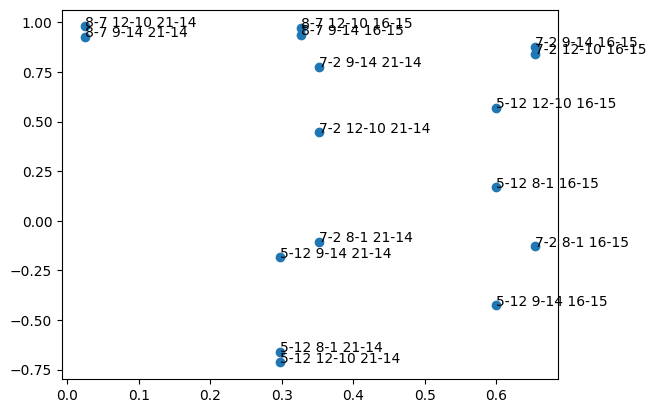

In [174]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0,1,2], k_shot=k_shot)

In [202]:
print(key); node = add_node_to_result(result, topi=[0,1,2], label_type='argmax_attn_labels')  # head_attr_fn=get_head_mlp_attr

MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
                 ┌[0] top[1, 2] 16-15,21-14 argmax_attn_labels┐
                 │                                            └[1] top[0, 1] 8-1,12-10┐
                 │                                                                    └*[2] top[0, 1, 2] 6-10,5-12,8-7...
 [-1] root labels┤
                 └[0] top[0] 20-5 argmax_attn_labels┐
                                                    └[1] top[0, 1] 12-10,8-1┐
                                                                            └[2] top[0, 1, 2] 6-10,5-12,8-7


[[(5, 12, -1.402), (8, 7, -0.846)], [(12, 10, -2.067), (8, 1, -1.974)], [(20, 5, -1.164)]]


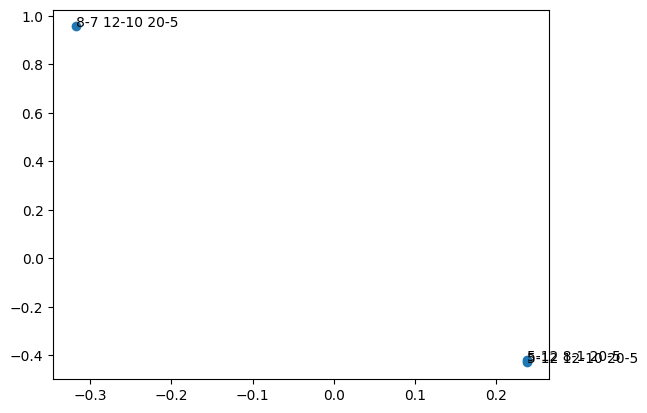

[(((5, 12), (12, 10), (20, 5)), -0.42940863966941833, 0.23799992),
 (((5, 12), (8, 1), (20, 5)), -0.4207330048084259, 0.23799992),
 (((8, 7), (12, 10), (20, 5)), 0.9564396142959595, -0.31800002)]

In [207]:
analyze_head_chains(model, get_head2scores(result.root.children[1].children[0].children[0]))

### did->does

In [20]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0): 0.613, 0.65625
MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=1): 0.650, 0.53125
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0): 0.056, 0.8125
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=1): 0.596, 0.5625
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0): 1.258, 0.53125
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=1): 1.894, 0.5


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0,1], head_attr_fn=get_head_mlp_attr, mix=True)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    show_predictions(tokenizer, *args, logits=o.logits, labels=labels, k_shot=k_shot, topk=3)[0]

In [ ]:
result.node = result.node.parent.parent.parent
result.node = result.root

In [80]:
print(key); node = add_node_to_result(result, topi=[1,0,2,7], head_attr_fn=get_head_mlp_attr, label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr

MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)
                 ┌[0] top3 21-16 labels┐
                 │                     └[1] top[0, 1, 2, 3, 4, 5] 19-16,8-16,13-13,17-16,7-16,6-16
                 ├[0] top[0] 17-9 attn_labels┐
                 │                           └[1] top[0, 1, 2] 12-10,8-1,13-13┐
                 │                                                            └[2] top[0] 6-10
 [-1] root labels┤
                 │                     ┌[1] top[0, 1, 2, 3, 4, 5] 18-16,13-13,14-7,16-16,12-10,17-16
                 ├[0] top0 19-16 labels┤
                 │                     └[1] top0 18-16┐
                 │                                    └[2] top0 17-16┐
                 │                                                   └[3] top[0, 1] 16-16,15-16
                 └[0] top[1] 14-7 attn_labels┐
                                             └[1] top[0, 1] 8-1,12-10┐
                                                          

In [ ]:
for data_tuple in data_tuples:
    plot_attn_attr(data_tuple, model, tokenizer, node, 17, 16, attn_patterns=None, k_shot=0, plot_attr=False)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node.parent, topi=[0,1,6,7,10])

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=10)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 7], head_attr_fn=get_head_mlp_attr)

In [89]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3])

MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1, 2, 3, 4] 9-14,13-13,15-5,8-1,12-10┐
                                                                                              └*[2] top[0, 1, 2, 3] 6-10,1-7,3-12,6-2...


[[(6, 2, -0.6)], [(9, 14, -2.579), (13, 13, -2.123), (15, 5, -2.675), (8, 1, -1.939), (12, 10, -2.034)], [(16, 7, -1.086)]]


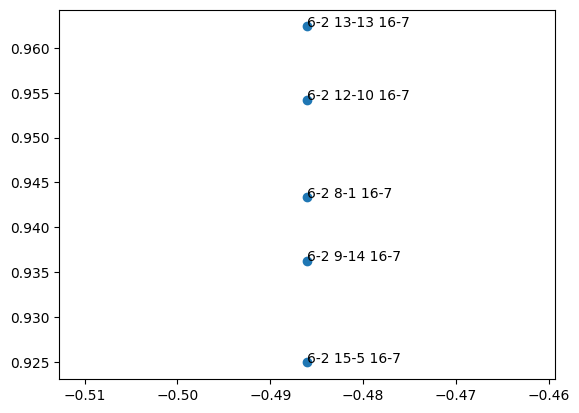

In [93]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [107]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3], label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr, 

MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top2 19-16 labels┐
                 │                     └[1] top[0, 1, 2, 3, 4, 5, 6] 13-13,18-16,0-16,17-16,16-16,13-7,12-10
 [-1] root labels┤
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1, 2, 3, 4] 9-14,8-1,13-13,15-5,12-10┐
                                                                                              └*[2] top[0, 1, 2, 3] 6-10,1-7,3-12,6-2...


### thing->capability

In [1067]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0): 0.536, 0.71875
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=1): 1.068, 0.375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0): 0.434, 0.9375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=1): 0.939, 0.59375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0): 2.783, 0.375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=1): 2.983, 0.3125


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1])

In [964]:
print(key); node = add_node_to_result(result, topi=[0,1])

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)
                 ┌[0] top[0] 13-15 attn_labels┐
                 │                            └[1] top[0, 1] 8-1,12-10┐
                 │                                                    └[2] top[0, 1] 5-12,6-5
 [-1] root labels┤
                 └[0] top[3] 21-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0, 1] 3-12,5-12...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [1062]:
print(key); node = add_node_to_result(result, topi=[2,1,3,0])

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 9-14,12-10┐
                                                                      └*[2] top[2, 1, 3, 0] 8-7,1-7,6-10,3-12...


[[(8, 7, -0.282)], [(9, 14, -2.228), (12, 10, -2.236)], [(16, 7, -1.271)]]


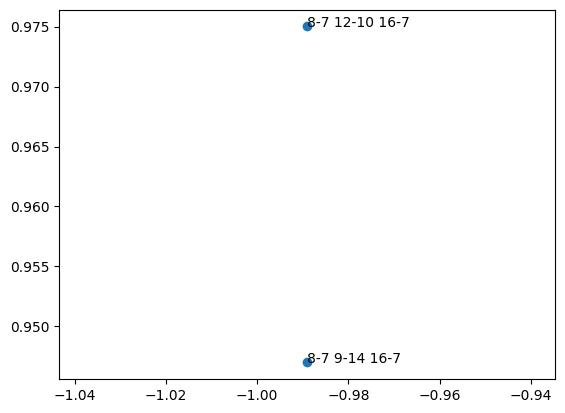

In [1063]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [988]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
        tokenizer, *args, logits=o.logits, labels=labels, loss_reduction='mean',
        candidates=None, k_shot=k_shot, topk=3, verbose=True)
    print(loss)

*Ġplay 0.133 {'Ġplay': 0.133, 'Ġshoot': 0.058, 'âĢ': 0.057} 	 Justice has a piano. Chance has a gun. Justice can play
*Ġbake 0.241 {'Ġbake': 0.241, 'Ġfly': 0.136, 'Ġcook': 0.128} 	 Tyler has an oven. London has a plane. Tyler can bake
 Ġfly 0.04 {'Ġprint': 0.727, 'Ġtype': 0.046, 'Ġfly': 0.04} 	 India has a printer. Eva has a glider. Eva can fly
*Ġwash 0.606 {'Ġwash': 0.606, 'Ġdry': 0.074, 'Ġclean': 0.062} 	 Jamie has a phone. Dream has washing machine. Dream can wash
 Ġstab 0.219 {'Ġopen': 0.324, 'Ġstab': 0.219, 'Ġcut': 0.21} 	 Angel has an opener. Laura has a dagger. Laura can stab
 Ġwatch 0.0 {'Ġstab': 0.975, 'Ġkill': 0.005, 'Ġcut': 0.002} 	 Anna has a TV. Michael has a dagger. Anna can watch
 Ġcut 0.077 {'Ġcook': 0.286, 'Ġsaw': 0.119, 'Ġchop': 0.082} 	 King has a saw. Amy has a pot. King can cut
 Ġcook 0.075 {'Ġdrive': 0.37, 'Ġcook': 0.075, 'Ġfix': 0.045} 	 Georgia has a pot. Thomas has a car. Georgia can cook
3.0769495964050293
 Ġchop 0.063 {"'t": 0.073, 'âĢ': 0.069, 'Ġchop': 0.063

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0], k_shot=k_shot)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2, 3], k_shot=k_shot, plot_attr=False)

In [1047]:
print(key); node = add_node_to_result(result, topi=[1,2,0], label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
                 ┌[0] top[1] 21-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └*[2] top[1, 2, 0] 5-12,1-7,3-12...
 [-1] root labels┤
                 └[0] top[0] 13-15 argmax_attn_labels┐
                                                     └[1] top[0, 1] 8-1,12-10┐
                                                                             └[2] top[2, 3, 1, 0] 6-5,3-7,5-12,3-12


### capital->country

In [470]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=1, abstract=0): 0.068, 0.8125
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=1, abstract=1): 0.111, 0.84375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0): 0.866, 0.65625
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=1): 1.251, 0.5
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0): 0.093, 0.84375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=1): 0.119, 0.8125
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0): 1.386, 0.4375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=1): 2.561, 0.4375


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [843]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

16 0
(0.9464224576950073, 0.9693313837051392)
Berlin->['Germany'] {'ĠBerlin': 34, 'ĠFriedrich': 22, 'ĠGermany': 19, 'ĠReich': 19, 'ĠGerman': 19}
Cairo->['Egypt'] {'ĠCairo': 40, 'Egypt': 39, 'ĠEgypt': 39, 'ĠEgyptian': 38, 'ĠEgyptians': 37}
Ankara->['Turkey'] {'ĠAnkara': 42, 'ĠTurkish': 38, 'ĠErdogan': 37, 'ĠTurkey': 36, 'Turkish': 35}
Athens->['Greece'] {'ĠAthens': 42, 'ĠAthen': 33, 'ĠAthena': 30, 'ĠGreece': 30, 'ĠGreek': 29}
London->['England'] {'ĠLondon': 26, 'London': 26, 'ĠNotting': 25, 'ĠThames': 24, 'ĠBarcl': 19}
Manila->['the Philippines'] {'ĠManila': 34, 'ĠFilipino': 31, 'ĠPhilippines': 31, 'ĠPhilippine': 29, 'ĠFilip': 27}
Ottawa->['Canada'] {'ĠOttawa': 36, 'Ott': 26, 'ĠCanadians': 24, 'ĠCanadian': 24, 'ĠQuebec': 22}
Bern->['Switzerland'] {'Bern': 30, 'ĠBernstein': 30, 'ĠBern': 25, 'bern': 24, 'ĠBernard': 21}
Seoul->['South Korea'] {'ĠSeoul': 39, 'ĠKoreans': 36, 'ĠKorean': 36, 'ĠKorea': 33, 'ĠYong': 29}
Lisbon->['Portugal'] {'ĠLisbon': 40, 'ĠPortuguese': 38, 'ĠPortugal': 37, 'ĠP

In [875]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[2] 19-12 attn_labels┐
                                              └[1] top[0, 1, 2, 3] 13-13,8-1,12-10,11-0┐
                                                                                       └*[2] top[0] 5-12...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [880]:
print(key); node = add_node_to_result(result, topi=[0,1])

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0, 1] 16-0,16-7 attn_labels┐
                                                     └[1] top[0, 1, 2] 8-1,13-13,12-10┐
                                                                                      └*[2] top[0, 1] 6-2,1-7...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [677]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 16-0,12-7,19-12 attn_labels┐
                 │                                            └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                 │                                                                                             └[2] top[0, 1, 3] 5-12,3-12,1-7
 [-1] root labels┤
                 └[0] top[0, 1, 3] 16-0,12-7,19-12 argmax_attn_labels┐
                                                                     └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                                                                                                                      └*[2] top[0, 1, 2] 5-12,1-7,3-12...


### person_adjs.opposite

In [343]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=0): 0.027, 0.9375
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=1): 0.102, 0.90625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0): 1.261, 0.5625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=1): 1.538, 0.46875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0): 0.451, 0.625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=1): 0.349, 0.75
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0): 3.566, 0.3125
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=1): 3.773, 0.25


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [370]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [385]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3,4])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 12-10,8-1┐
                                                                     └*[2] top[0, 1, 2, 3, 4] 6-2,8-7,3-12,1-7,6-10...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [412]:
print(key); node = add_node_to_result(result, topi=[0,])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └[2] top[0] 7-9
 [-1] root labels┤
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


### thing->type

In [315]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")  # old full

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=0): 0.032, 1.0
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=1): 0.117, 0.90625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0): 0.594, 0.65625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=1): 1.354, 0.53125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0): 0.793, 0.625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=1): 0.286, 0.8125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0): 2.174, 0.46875
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=1): 1.824, 0.46875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=0): 0.048, 0.875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=1): 0.191, 0.90625
MlM_gen(persons

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1, 2])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [151]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0] 12-10┐
                                                              └*[2] top[0, 1, 2, 3, 4] 8-7,6-2,6-10,3-12,1-7...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [206]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                 │                                                  └[1] top[0, 1] 8-1,12-10┐
                 │                                                                          └[2] top[0, 1, 3] 5-12,3-12,7-2
 [-1] root labels┤
                 ├[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └[1] top[0, 1] 8-1,12-10┐
                 │                                                                   └*[2] top[0, 1, 2] 5-12,3-12,7-2...
                 └[0] 11-9 attn_labels┐
                                      └[1] top[0] 8-1┐
                                                     └[2] top[0, 1] 3-12,7-2


In [ ]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [156]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B/cpu 0.4444444444444444
accuracies EleutherAI/gpt-neox-20b 0.5555555555555556
accuracies text-curie-001 0.3333333333333333
losses EleutherAI/gpt-j-6B/cpu 3.0475401878356934
losses EleutherAI/gpt-neox-20b 2.3752387364705405
losses text-curie-001 5.4890399882962955


In [129]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [47]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

 ... done 0:00:02.348918
 ... done 0:00:01.659792
 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.626 {'ĠA': 0.626, 'ĠI': 0.225, 'ĠY': 0.11} 	 Y A I -> A


 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.62

In [176]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B 0.4976851851851852
accuracies EleutherAI/gpt-neox-20b 0.5023148148148148
accuracies text-davinci-001 0.48148148148148145
accuracies text-davinci-002 0.9675925925925926
losses EleutherAI/gpt-j-6B 1.3536101162543572
losses EleutherAI/gpt-neox-20b 1.1634638377252957
losses text-davinci-001 1.687816629922939
losses text-davinci-002 0.1085046497381794


In [136]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

accuracies EleutherAI/gpt-j-6B 0.6203703703703703
accuracies EleutherAI/gpt-neox-20b 0.7083333333333334
accuracies text-curie-001 0.5879629629629629
losses EleutherAI/gpt-j-6B 1.5619440356433054
losses EleutherAI/gpt-neox-20b 1.0779137232247094
losses text-curie-001 3.1073556870623844


In [ ]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [11]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [81]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [80]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'Yes': 0.35, 'No': 0.226, 'Yeah': 0.078, 'I': 0.078, 'Y': 0.021}

In [75]:
get_prob_dist(logits.top_logprobs[-1], 5)

{'No': 0.824, 'Yes': 0.115, 'I': 0.04, 'What': 0.006, ' No': 0.003}

In [155]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

[('▁The', 37),
 ('▁capital', 1784),
 ('▁of', 13),
 ('▁Canada', 1894),
 ('▁is', 19),
 ('</s>', 1)]

'Ottawa. It is the largest city in Canada'

In [478]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [197]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

EleutherAI/gpt-j-6B ... done 0:00:01
* C 0.842 {' C': 0.842, ' A': 0.041, ' B': 0.04} 	 D -> C
* Thursday 0.778 {' Thursday': 0.778, ' Wednesday': 0.064, ' Friday': 0.063} 	 Friday -> Thursday
* a 0.742 {' a': 0.742, ' c': 0.051, ' A': 0.036} 	 b -> a
* four 0.472 {' four': 0.472, ' three': 0.246, ' one': 0.105} 	 five -> four
tensor(0.3677, grad_fn=<NllLossBackward>) True 

0.3677041530609131


In [24]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [385]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

Instruction: replace with the other. For example:
G H G G G -> H G H H H
I I I I M -> M M M M I
A A F A A -> F F A F F
9 9 9 I I -> I I I 9 9

Instruction: replace with the other. For example:
V Q Q V V -> Q V V Q Q
G L L G L -> L G G L G
G 2 2 2 G -> 2 G G G 2
I I Z Z Z -> Z Z I I I

Instruction: replace with the other. For example:
R H H H R -> H R R R H
B 9 9 B B -> 9 B B 9 9
D 2 2 2 D -> 2 D D D 2
A A A A W -> W W W W A



In [368]:
sum(s.count('Yes') for s in input_strs)

370

In [322]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [121]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [329]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [330]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [333]:
trainer.place_model_on_device

True

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [6]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])